In [1]:
!pip3 install awswrangler nltk progressbar2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/380.7 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 12.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset

from collections import Counter

import awswrangler as wr

import re

import progressbar

In [3]:
nltk.download('punkt');
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sagemaker-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
torch.manual_seed(1);

In [5]:
word_counter = Counter();

In [6]:
df = wr.s3.read_csv("s3://insight-62326441-datascience-projects");

In [7]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [8]:
df = df[:int(len(df)/10)]; ## Limit the rows down to 1/50 of the entire dataset. Total of 5685 rows.

In [9]:
def text_cleansing(text):
    # Convert the words in lowercases.
    text = text.lower();

    # Remove punctuations and special characters.
    text = re.sub(r"[^a-zA-Z\s]", "", text);

    return text;

In [10]:
def stopword_cleansing(text):
    # Cleanse the Text
    cleaned_text = text_cleansing(text)

    # Remove Tokenize the cleaned text
    tokens = word_tokenize(cleaned_text)
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

In [11]:
def extract_adjectives(text):
  pos_tags = nltk.pos_tag(text)
  return [word for word, pos in pos_tags if pos in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VB', 'VBD')]

# POS Tags for preprocessing
# JJ: Adjective, numeral, or ordinal
# JJR: Adjective, comparative
# JJS: Adjective, superlative
# RB: Adverb
# RBR: Adverb, comparative
# RBS: Adverb, superlative
# VB: Verb
# VBD: Verb, past tense

In [12]:
# Ensure 'Text' column exists
if 'Text' in df.columns:
    # Fill any missing values in 'Text' with empty strings
    df['Text'] = df['Text'].fillna('')

    # Ensure all values in 'Text' are strings
    df['Text'] = df['Text'].astype(str)

    # Clean the words using custom function
    df['tokenized'] = df['Text'].apply(lambda x: stopword_cleansing(x))

    # We extract the adjectives that are more likely describing the state of emotions
    df['adjectives'] = df['tokenized'].apply(lambda x: extract_adjectives(x))

    # # Apply tokenization
    # df["tokenized"] = df["Text"].apply(word_tokenize)

else:
    raise KeyError("'Text' column not found in DataFrame")

/tmp/ipykernel_40/1237852769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].fillna('')
/tmp/ipykernel_40/1237852769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].astype(str)


/tmp/ipykernel_40/1237852769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized'] = df['Text'].apply(lambda x: stopword_cleansing(x))


/tmp/ipykernel_40/1237852769.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['adjectives'] = df['tokenized'].apply(lambda x: extract_adjectives(x))


In [13]:
# Indexing and Numericalization
word_counter = Counter()
for tokens in df['adjectives']:
    word_counter.update(tokens)

In [14]:
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counter.most_common())}
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token

In [15]:
df['numericalized'] = df['adjectives'].apply(lambda x: [vocab.get(token, vocab['<UNK>']) for token in x])

/tmp/ipykernel_40/1569804081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['numericalized'] = df['adjectives'].apply(lambda x: [vocab.get(token, vocab['<UNK>']) for token in x])


In [16]:
# Padding
max_len = max(map(len, df['numericalized']))
df['padded'] = df['numericalized'].apply(lambda x: x + [vocab['<PAD>']] * (max_len - len(x)))

/tmp/ipykernel_40/1441114284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['padded'] = df['numericalized'].apply(lambda x: x + [vocab['<PAD>']] * (max_len - len(x)))


In [17]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super(CustomDataset, self).__init__();
        self.X = X;
        self.y = y;

    def __len__(self):
        return len(self.X);

    def __getitem__(self, index):
        return self.X[index], self.y[index];

In [18]:
df['Score'] = df['Score'] - 1
# Load the data, padded versions.
X = torch.tensor(df["padded"].tolist());
y = torch.tensor(df["Score"].tolist());
# y = torch.tensor(df["Score"].tolist()).long();

/tmp/ipykernel_40/1730702270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Score'] = df['Score'] - 1


In [19]:
dataset = CustomDataset(X, y);
n = len(dataset);

In [20]:
batch_size = 200;
train_size = int(0.75 * n);
validation_size = int(0.15 * n);
test_size = n - train_size - validation_size;

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

# Create DataLoader for each train, validation, and test datasets.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4);
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [21]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional = True, num_layers = 3, dropout = 0.5):
        super(Model, self).__init__();
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2 if bidirectional else hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Concatenate the outputs from both directions if bidirectional
        if self.bidirectional:
            lstm_out = torch.cat((lstm_out[:, -1, :self.hidden_dim], lstm_out[:, 0, self.hidden_dim:]), dim=1)
        else:
            lstm_out = lstm_out[:, -1, :]
        
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.batch_norm(lstm_out)
        out = self.fc1(lstm_out)
        out = self.dropout(out)
        # out = self.fc2(out)
        out = self.fc2(out)
        
        return out;

In [22]:
# Defining hyperparameters
vocab_size = len(vocab);
embedding_dim = 100;
hidden_dim = 128;
output_dim = 5;

In [23]:
model = Model(vocab_size, embedding_dim, hidden_dim, output_dim);

In [24]:
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=0.001);

In [25]:
num_epochs = 25;

trainingEpoch_loss = [];
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}')
    model.train()  # Train the model
    total_loss = 0  # Initialize the Loss to 0

    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        # print(f'Processing batch {batch_idx+1}')
        optimizer.zero_grad()  # Clearing out the Gradient Descent

        # Forward pass
        inputs = inputs.to(torch.int64)
        labels = labels.to(torch.int64)
        outputs = model(inputs)

        # # Debugging shapes and types
        # print(f'Outputs shape: {outputs.shape}, Labels shape: {labels.shape}')
        # print(f'Outputs dtype: {outputs.dtype}, Labels dtype: {labels.dtype}')

        # Calculate the loss
        try:
            loss = criterion(outputs, labels)
            print(f'Batch: {batch_idx + 1} Loss: {loss.item()}')
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        except Exception as e:
            print(f'Error in loss calculation: {e}')
            break  # Exit the loop if there's an error in loss calculation

        trainingEpoch_loss.append(loss.item());
        total_loss += loss.item();

    # Print average loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}');

Starting epoch 1


Batch: 1 Loss: 1.6737468242645264


Batch: 2 Loss: 1.6237167119979858


Batch: 3 Loss: 1.6058632135391235


Batch: 4 Loss: 1.6235133409500122


Batch: 5 Loss: 1.6167699098587036


Batch: 6 Loss: 1.6306333541870117


Batch: 7 Loss: 1.5887930393218994


Batch: 8 Loss: 1.5932626724243164


Batch: 9 Loss: 1.5751066207885742


Batch: 10 Loss: 1.5630521774291992


Batch: 11 Loss: 1.6477606296539307


Batch: 12 Loss: 1.575616478919983


Batch: 13 Loss: 1.5555081367492676


Batch: 14 Loss: 1.5442081689834595


Batch: 15 Loss: 1.5352473258972168


Batch: 16 Loss: 1.5302512645721436


Batch: 17 Loss: 1.4634504318237305


Batch: 18 Loss: 1.5361465215682983


Batch: 19 Loss: 1.5060371160507202


Batch: 20 Loss: 1.501513957977295


Batch: 21 Loss: 1.5967154502868652


Batch: 22 Loss: 1.4957852363586426


Batch: 23 Loss: 1.5767751932144165


Batch: 24 Loss: 1.4634279012680054


Batch: 25 Loss: 1.4725902080535889


Batch: 26 Loss: 1.479905128479004


Batch: 27 Loss: 1.4365342855453491


Batch: 28 Loss: 1.4243927001953125


Batch: 29 Loss: 1.4019016027450562


Batch: 30 Loss: 1.429518222808838


Batch: 31 Loss: 1.4612393379211426


Batch: 32 Loss: 1.3573646545410156


Batch: 33 Loss: 1.399043083190918


Batch: 34 Loss: 1.3818069696426392


Batch: 35 Loss: 1.342477560043335


Batch: 36 Loss: 1.3992379903793335


Batch: 37 Loss: 1.4529409408569336


Batch: 38 Loss: 1.3887243270874023


Batch: 39 Loss: 1.4358117580413818


Batch: 40 Loss: 1.4305671453475952


Batch: 41 Loss: 1.3030198812484741


Batch: 42 Loss: 1.3109668493270874


Batch: 43 Loss: 1.301957607269287


Batch: 44 Loss: 1.318821907043457


Batch: 45 Loss: 1.2966357469558716


Batch: 46 Loss: 1.324446678161621


Batch: 47 Loss: 1.3360637426376343


Batch: 48 Loss: 1.2377142906188965


Batch: 49 Loss: 1.2816940546035767


Batch: 50 Loss: 1.3274872303009033


Batch: 51 Loss: 1.2638407945632935


Batch: 52 Loss: 1.251635193824768


Batch: 53 Loss: 1.3058362007141113


Batch: 54 Loss: 1.2452183961868286


Batch: 55 Loss: 1.188965916633606


Batch: 56 Loss: 1.2031583786010742


Batch: 57 Loss: 1.3523756265640259


Batch: 58 Loss: 1.2699735164642334


Batch: 59 Loss: 1.3112547397613525


Batch: 60 Loss: 1.2639538049697876


Batch: 61 Loss: 1.2257345914840698


Batch: 62 Loss: 1.185696005821228


Batch: 63 Loss: 1.2400137186050415


Batch: 64 Loss: 1.2061793804168701


Batch: 65 Loss: 1.2614916563034058


Batch: 66 Loss: 1.308160662651062


Batch: 67 Loss: 1.2557880878448486


Batch: 68 Loss: 1.3502882719039917


Batch: 69 Loss: 1.118308186531067


Batch: 70 Loss: 1.1747736930847168


Batch: 71 Loss: 1.2414644956588745


Batch: 72 Loss: 1.2495030164718628


Batch: 73 Loss: 1.175939679145813


Batch: 74 Loss: 1.3103233575820923


Batch: 75 Loss: 1.16880464553833


Batch: 76 Loss: 1.2190866470336914


Batch: 77 Loss: 1.145378589630127


Batch: 78 Loss: 1.200188159942627


Batch: 79 Loss: 1.153112769126892


Batch: 80 Loss: 1.153279423713684


Batch: 81 Loss: 1.2745894193649292


Batch: 82 Loss: 1.2157562971115112


Batch: 83 Loss: 1.138188123703003


Batch: 84 Loss: 1.1598089933395386


Batch: 85 Loss: 1.1710623502731323


Batch: 86 Loss: 1.1285598278045654


Batch: 87 Loss: 1.2014294862747192


Batch: 88 Loss: 1.022247552871704


Batch: 89 Loss: 1.1316365003585815


Batch: 90 Loss: 1.148980736732483


Batch: 91 Loss: 1.148348331451416


Batch: 92 Loss: 0.9925622344017029


Batch: 93 Loss: 1.2087409496307373


Batch: 94 Loss: 1.0858142375946045


Batch: 95 Loss: 1.064345359802246


Batch: 96 Loss: 1.0942410230636597


Batch: 97 Loss: 1.0844695568084717


Batch: 98 Loss: 1.095959186553955


Batch: 99 Loss: 1.1693449020385742


Batch: 100 Loss: 1.216912031173706


Batch: 101 Loss: 1.2266438007354736


Batch: 102 Loss: 1.1006630659103394


Batch: 103 Loss: 1.1233805418014526


Batch: 104 Loss: 1.1968040466308594


Batch: 105 Loss: 1.1176717281341553


Batch: 106 Loss: 1.1032830476760864


Batch: 107 Loss: 1.2009326219558716


Batch: 108 Loss: 1.1522936820983887


Batch: 109 Loss: 1.1510106325149536


Batch: 110 Loss: 1.0607659816741943


Batch: 111 Loss: 1.1975321769714355


Batch: 112 Loss: 1.0940971374511719


Batch: 113 Loss: 1.1355619430541992


Batch: 114 Loss: 1.163954734802246


Batch: 115 Loss: 1.0581998825073242


Batch: 116 Loss: 1.0994739532470703


Batch: 117 Loss: 1.0334089994430542


Batch: 118 Loss: 1.0939241647720337


Batch: 119 Loss: 1.047310471534729


Batch: 120 Loss: 1.032014012336731


Batch: 121 Loss: 0.9384562969207764


Batch: 122 Loss: 1.1019139289855957


Batch: 123 Loss: 1.038938283920288


Batch: 124 Loss: 1.1676561832427979


Batch: 125 Loss: 1.0324143171310425


Batch: 126 Loss: 1.1425142288208008


Batch: 127 Loss: 1.1485785245895386


Batch: 128 Loss: 1.1155762672424316


Batch: 129 Loss: 1.0457172393798828


Batch: 130 Loss: 1.209708571434021


Batch: 131 Loss: 1.0750524997711182


Batch: 132 Loss: 1.0469468832015991


Batch: 133 Loss: 1.1299047470092773


Batch: 134 Loss: 1.1047378778457642


Batch: 135 Loss: 1.0837067365646362


Batch: 136 Loss: 0.9742984771728516


Batch: 137 Loss: 0.9783890247344971


Batch: 138 Loss: 1.0209163427352905


Batch: 139 Loss: 1.1401559114456177


Batch: 140 Loss: 1.0596450567245483


Batch: 141 Loss: 1.1176655292510986


Batch: 142 Loss: 1.075303554534912


Batch: 143 Loss: 1.1118488311767578


Batch: 144 Loss: 1.165555715560913


Batch: 145 Loss: 1.0402112007141113


Batch: 146 Loss: 1.0936145782470703


Batch: 147 Loss: 1.120476245880127


Batch: 148 Loss: 0.9200681447982788


Batch: 149 Loss: 1.0620477199554443


Batch: 150 Loss: 1.0874583721160889


Batch: 151 Loss: 1.039477825164795


Batch: 152 Loss: 1.0727771520614624


Batch: 153 Loss: 1.1440932750701904


Batch: 154 Loss: 1.059302568435669


Batch: 155 Loss: 1.0971226692199707


Batch: 156 Loss: 1.0803227424621582


Batch: 157 Loss: 0.9609462022781372


Batch: 158 Loss: 1.06768798828125


Batch: 159 Loss: 1.0618342161178589


Batch: 160 Loss: 1.0240626335144043


Batch: 161 Loss: 1.0923413038253784


Batch: 162 Loss: 1.0066256523132324


Batch: 163 Loss: 1.061478614807129


Batch: 164 Loss: 1.0782074928283691


Batch: 165 Loss: 1.1040716171264648


Batch: 166 Loss: 1.0783146619796753


Batch: 167 Loss: 0.9968864917755127


Batch: 168 Loss: 1.0272858142852783


Batch: 169 Loss: 1.1130914688110352


Batch: 170 Loss: 1.1495468616485596


Batch: 171 Loss: 1.0182178020477295


Batch: 172 Loss: 1.1857889890670776


Batch: 173 Loss: 1.2343049049377441


Batch: 174 Loss: 1.023903727531433


Batch: 175 Loss: 1.070657730102539


Batch: 176 Loss: 1.0795609951019287


Batch: 177 Loss: 1.0477262735366821


Batch: 178 Loss: 1.196466326713562


Batch: 179 Loss: 1.0326191186904907


Batch: 180 Loss: 1.1457910537719727


Batch: 181 Loss: 1.0313527584075928


Batch: 182 Loss: 0.9863801002502441


Batch: 183 Loss: 1.039976954460144


Batch: 184 Loss: 1.041865348815918


Batch: 185 Loss: 1.0425350666046143


Batch: 186 Loss: 1.0656728744506836


Batch: 187 Loss: 1.1530488729476929


Batch: 188 Loss: 0.9975765943527222


Batch: 189 Loss: 1.0011717081069946


Batch: 190 Loss: 0.9500231146812439


Batch: 191 Loss: 0.9413438439369202


Batch: 192 Loss: 1.0193936824798584


Batch: 193 Loss: 1.0353492498397827


Batch: 194 Loss: 1.185427188873291


Batch: 195 Loss: 1.0083526372909546


Batch: 196 Loss: 1.10369873046875


Batch: 197 Loss: 1.0580456256866455


Batch: 198 Loss: 1.1129027605056763


Batch: 199 Loss: 0.9021080732345581


Batch: 200 Loss: 1.0043259859085083


Batch: 201 Loss: 1.026017189025879


Batch: 202 Loss: 1.0719287395477295


Batch: 203 Loss: 0.9814508557319641


Batch: 204 Loss: 0.9204075336456299


Batch: 205 Loss: 1.0538218021392822


Batch: 206 Loss: 1.0240999460220337


Batch: 207 Loss: 1.108580231666565


Batch: 208 Loss: 1.0066643953323364


Batch: 209 Loss: 0.8671174645423889


Batch: 210 Loss: 1.0182663202285767


Batch: 211 Loss: 1.0599992275238037


Batch: 212 Loss: 0.9558641314506531


Batch: 213 Loss: 1.0436512231826782


Batch: 214 Loss: 1.0341479778289795


Epoch 1/25, Loss: 1.191822320501381
Starting epoch 2


Batch: 1 Loss: 1.0189316272735596


Batch: 2 Loss: 1.0005748271942139


Batch: 3 Loss: 1.02802312374115


Batch: 4 Loss: 1.089781403541565


Batch: 5 Loss: 0.8933627605438232


Batch: 6 Loss: 0.9524857997894287


Batch: 7 Loss: 1.0542776584625244


Batch: 8 Loss: 1.0748087167739868


Batch: 9 Loss: 0.9677717089653015


Batch: 10 Loss: 0.9867774248123169


Batch: 11 Loss: 1.0728938579559326


Batch: 12 Loss: 0.9342963695526123


Batch: 13 Loss: 0.9591891765594482


Batch: 14 Loss: 1.0241011381149292


Batch: 15 Loss: 1.0398012399673462


Batch: 16 Loss: 0.8925668597221375


Batch: 17 Loss: 0.9691960215568542


Batch: 18 Loss: 0.9445804357528687


Batch: 19 Loss: 0.9804205298423767


Batch: 20 Loss: 0.9688295125961304


Batch: 21 Loss: 1.019636869430542


Batch: 22 Loss: 0.8821815252304077


Batch: 23 Loss: 1.0046932697296143


Batch: 24 Loss: 1.01963210105896


Batch: 25 Loss: 1.0077441930770874


Batch: 26 Loss: 0.9294177889823914


Batch: 27 Loss: 0.9598846435546875


Batch: 28 Loss: 1.059592366218567


Batch: 29 Loss: 1.054627776145935


Batch: 30 Loss: 0.8536548614501953


Batch: 31 Loss: 0.9644898176193237


Batch: 32 Loss: 1.013208031654358


Batch: 33 Loss: 1.0009353160858154


Batch: 34 Loss: 0.9439994692802429


Batch: 35 Loss: 1.0638352632522583


Batch: 36 Loss: 1.037414312362671


Batch: 37 Loss: 0.9201382398605347


Batch: 38 Loss: 0.9874281287193298


Batch: 39 Loss: 0.9667638540267944


Batch: 40 Loss: 1.0355032682418823


Batch: 41 Loss: 1.0771275758743286


Batch: 42 Loss: 0.9897284507751465


Batch: 43 Loss: 0.8821094632148743


Batch: 44 Loss: 1.1124224662780762


Batch: 45 Loss: 0.9971891045570374


Batch: 46 Loss: 1.077712893486023


Batch: 47 Loss: 0.9834984540939331


Batch: 48 Loss: 0.9123474359512329


Batch: 49 Loss: 0.9689129590988159


Batch: 50 Loss: 0.9724020957946777


Batch: 51 Loss: 1.040663719177246


Batch: 52 Loss: 0.9782227873802185


Batch: 53 Loss: 0.9088259935379028


Batch: 54 Loss: 0.929231584072113


Batch: 55 Loss: 0.9877872467041016


Batch: 56 Loss: 0.9521711468696594


Batch: 57 Loss: 0.8281108140945435


Batch: 58 Loss: 1.0198166370391846


Batch: 59 Loss: 0.9445599913597107


Batch: 60 Loss: 0.8989495038986206


Batch: 61 Loss: 0.9808303713798523


Batch: 62 Loss: 0.9605734944343567


Batch: 63 Loss: 0.9415999054908752


Batch: 64 Loss: 0.9245498180389404


Batch: 65 Loss: 0.9968359470367432


Batch: 66 Loss: 1.0921226739883423


Batch: 67 Loss: 1.0190811157226562


Batch: 68 Loss: 0.993020236492157


Batch: 69 Loss: 0.9243523478507996


Batch: 70 Loss: 0.9691895842552185


Batch: 71 Loss: 1.0413658618927002


Batch: 72 Loss: 0.9403172135353088


Batch: 73 Loss: 0.928688108921051


Batch: 74 Loss: 0.9532719254493713


Batch: 75 Loss: 0.9484800100326538


Batch: 76 Loss: 0.9545767903327942


Batch: 77 Loss: 1.003713607788086


Batch: 78 Loss: 0.9528453946113586


Batch: 79 Loss: 0.8671486377716064


Batch: 80 Loss: 1.005111813545227


Batch: 81 Loss: 1.0310473442077637


Batch: 82 Loss: 1.0414336919784546


Batch: 83 Loss: 0.9034093618392944


Batch: 84 Loss: 0.9997050762176514


Batch: 85 Loss: 0.997779905796051


Batch: 86 Loss: 0.8215705156326294


Batch: 87 Loss: 0.942878246307373


Batch: 88 Loss: 0.9895707964897156


Batch: 89 Loss: 0.9994439482688904


Batch: 90 Loss: 0.9177777767181396


Batch: 91 Loss: 1.1399153470993042


Batch: 92 Loss: 0.9284924864768982


Batch: 93 Loss: 0.995025634765625


Batch: 94 Loss: 0.9857985973358154


Batch: 95 Loss: 0.9456949830055237


Batch: 96 Loss: 0.8717460036277771


Batch: 97 Loss: 1.0676709413528442


Batch: 98 Loss: 0.9745779633522034


Batch: 99 Loss: 0.9019906520843506


Batch: 100 Loss: 1.0028499364852905


Batch: 101 Loss: 0.9679690599441528


Batch: 102 Loss: 0.818006694316864


Batch: 103 Loss: 1.0962717533111572


Batch: 104 Loss: 0.8986783623695374


Batch: 105 Loss: 1.029948115348816


Batch: 106 Loss: 0.9267502427101135


Batch: 107 Loss: 0.8973739147186279


Batch: 108 Loss: 0.8946519494056702


Batch: 109 Loss: 1.0656450986862183


Batch: 110 Loss: 1.0162971019744873


Batch: 111 Loss: 0.8417003154754639


Batch: 112 Loss: 0.9937054514884949


Batch: 113 Loss: 1.0601142644882202


Batch: 114 Loss: 0.9904855489730835


Batch: 115 Loss: 1.0715641975402832


Batch: 116 Loss: 0.8668224811553955


Batch: 117 Loss: 0.8356021642684937


Batch: 118 Loss: 1.0105252265930176


Batch: 119 Loss: 0.9658766388893127


Batch: 120 Loss: 0.8485137224197388


Batch: 121 Loss: 0.9330283403396606


Batch: 122 Loss: 0.9219419956207275


Batch: 123 Loss: 0.8457707762718201


Batch: 124 Loss: 0.9898222088813782


Batch: 125 Loss: 1.061946988105774


Batch: 126 Loss: 0.880724310874939


Batch: 127 Loss: 1.0187227725982666


Batch: 128 Loss: 1.10305917263031


Batch: 129 Loss: 0.839883029460907


Batch: 130 Loss: 0.9589117169380188


Batch: 131 Loss: 0.9300327301025391


Batch: 132 Loss: 1.0288821458816528


Batch: 133 Loss: 0.9948914051055908


Batch: 134 Loss: 1.0019428730010986


Batch: 135 Loss: 0.9873580932617188


Batch: 136 Loss: 0.9285931587219238


Batch: 137 Loss: 0.9302169680595398


Batch: 138 Loss: 0.9120230078697205


Batch: 139 Loss: 1.016688346862793


Batch: 140 Loss: 0.9600186347961426


Batch: 141 Loss: 0.9077287316322327


Batch: 142 Loss: 1.0608224868774414


Batch: 143 Loss: 0.845085620880127


Batch: 144 Loss: 0.9351651668548584


Batch: 145 Loss: 0.8676199316978455


Batch: 146 Loss: 0.9169790148735046


Batch: 147 Loss: 0.8323866128921509


Batch: 148 Loss: 0.8861154317855835


Batch: 149 Loss: 1.0117756128311157


Batch: 150 Loss: 0.8534693121910095


Batch: 151 Loss: 0.9988338947296143


Batch: 152 Loss: 1.041550636291504


Batch: 153 Loss: 0.8219287991523743


Batch: 154 Loss: 0.8900607228279114


Batch: 155 Loss: 0.9056603312492371


Batch: 156 Loss: 0.9877813458442688


Batch: 157 Loss: 0.9384049773216248


Batch: 158 Loss: 1.0030512809753418


Batch: 159 Loss: 1.0457264184951782


Batch: 160 Loss: 0.9544245004653931


Batch: 161 Loss: 0.9712343811988831


Batch: 162 Loss: 1.0779777765274048


Batch: 163 Loss: 0.9191068410873413


Batch: 164 Loss: 0.9347262382507324


Batch: 165 Loss: 0.8808959126472473


Batch: 166 Loss: 0.9071913361549377


Batch: 167 Loss: 0.968762218952179


Batch: 168 Loss: 0.922678530216217


Batch: 169 Loss: 0.9872996807098389


Batch: 170 Loss: 0.8957652449607849


Batch: 171 Loss: 0.8485257625579834


Batch: 172 Loss: 0.8614919781684875


Batch: 173 Loss: 1.0022902488708496


Batch: 174 Loss: 0.9283490777015686


Batch: 175 Loss: 0.8999386429786682


Batch: 176 Loss: 0.811525285243988


Batch: 177 Loss: 1.0251847505569458


Batch: 178 Loss: 0.8631923198699951


Batch: 179 Loss: 0.948966383934021


Batch: 180 Loss: 0.9368999004364014


Batch: 181 Loss: 0.8005529642105103


Batch: 182 Loss: 0.9741743206977844


Batch: 183 Loss: 1.0283464193344116


Batch: 184 Loss: 1.0344005823135376


Batch: 185 Loss: 0.9786036014556885


Batch: 186 Loss: 0.9431539177894592


Batch: 187 Loss: 0.8765052556991577


Batch: 188 Loss: 0.9650996327400208


Batch: 189 Loss: 1.0052070617675781


Batch: 190 Loss: 0.8963955044746399


Batch: 191 Loss: 0.9575912356376648


Batch: 192 Loss: 0.8866497278213501


Batch: 193 Loss: 0.8589941263198853


Batch: 194 Loss: 0.9517025947570801


Batch: 195 Loss: 0.9636560082435608


Batch: 196 Loss: 1.0454283952713013


Batch: 197 Loss: 0.9114713072776794


Batch: 198 Loss: 0.9220045208930969


Batch: 199 Loss: 0.8969051837921143


Batch: 200 Loss: 0.919850766658783


Batch: 201 Loss: 1.066907525062561


Batch: 202 Loss: 1.1223427057266235


Batch: 203 Loss: 0.9892101287841797


Batch: 204 Loss: 0.9105989336967468


Batch: 205 Loss: 0.9093798995018005


Batch: 206 Loss: 0.8864594101905823


Batch: 207 Loss: 1.0297415256500244


Batch: 208 Loss: 0.882131040096283


Batch: 209 Loss: 0.854759693145752


Batch: 210 Loss: 0.9619638919830322


Batch: 211 Loss: 0.9860693216323853


Batch: 212 Loss: 1.015992522239685


Batch: 213 Loss: 0.9492629766464233


Batch: 214 Loss: 0.7608481645584106


Epoch 2/25, Loss: 0.9610990227382874
Starting epoch 3


Batch: 1 Loss: 0.9603767991065979


Batch: 2 Loss: 0.8749880194664001


Batch: 3 Loss: 0.9050356149673462


Batch: 4 Loss: 0.8385376930236816


Batch: 5 Loss: 0.8592275381088257


Batch: 6 Loss: 0.8429909348487854


Batch: 7 Loss: 1.0157071352005005


Batch: 8 Loss: 0.8491296172142029


Batch: 9 Loss: 0.8955284357070923


Batch: 10 Loss: 1.0131319761276245


Batch: 11 Loss: 0.8341870903968811


Batch: 12 Loss: 1.0046019554138184


Batch: 13 Loss: 0.8579207062721252


Batch: 14 Loss: 0.9708603620529175


Batch: 15 Loss: 0.8751348257064819


Batch: 16 Loss: 0.950570821762085


Batch: 17 Loss: 0.8163683414459229


Batch: 18 Loss: 0.9604796767234802


Batch: 19 Loss: 0.9896805286407471


Batch: 20 Loss: 0.8911303877830505


Batch: 21 Loss: 0.8879035115242004


Batch: 22 Loss: 0.9071533679962158


Batch: 23 Loss: 0.9428970217704773


Batch: 24 Loss: 0.8300033807754517


Batch: 25 Loss: 0.9409152865409851


Batch: 26 Loss: 0.8162716031074524


Batch: 27 Loss: 0.8883247971534729


Batch: 28 Loss: 0.8127626776695251


Batch: 29 Loss: 0.8151056170463562


Batch: 30 Loss: 0.9379479885101318


Batch: 31 Loss: 0.9174433946609497


Batch: 32 Loss: 0.8295454382896423


Batch: 33 Loss: 0.8867380619049072


Batch: 34 Loss: 0.9566306471824646


Batch: 35 Loss: 0.8134479522705078


Batch: 36 Loss: 0.9759650230407715


Batch: 37 Loss: 0.8920904397964478


Batch: 38 Loss: 0.8769890666007996


Batch: 39 Loss: 0.9662696123123169


Batch: 40 Loss: 0.7996907234191895


Batch: 41 Loss: 0.8279294371604919


Batch: 42 Loss: 0.9063042402267456


Batch: 43 Loss: 0.8734853863716125


Batch: 44 Loss: 0.8188077807426453


Batch: 45 Loss: 0.9079647660255432


Batch: 46 Loss: 0.9324610829353333


Batch: 47 Loss: 0.9425451755523682


Batch: 48 Loss: 0.9371051788330078


Batch: 49 Loss: 0.7927740216255188


Batch: 50 Loss: 0.8340081572532654


Batch: 51 Loss: 0.8999541997909546


Batch: 52 Loss: 1.0220152139663696


Batch: 53 Loss: 0.8617704510688782


Batch: 54 Loss: 0.7668201327323914


Batch: 55 Loss: 0.8428846001625061


Batch: 56 Loss: 0.8121947646141052


Batch: 57 Loss: 0.9502543807029724


Batch: 58 Loss: 0.8305585384368896


Batch: 59 Loss: 0.9863570332527161


Batch: 60 Loss: 0.9439575672149658


Batch: 61 Loss: 0.8114405870437622


Batch: 62 Loss: 1.0470001697540283


Batch: 63 Loss: 0.8162462711334229


Batch: 64 Loss: 0.8488881587982178


Batch: 65 Loss: 0.8123899102210999


Batch: 66 Loss: 0.9192408919334412


Batch: 67 Loss: 0.9177020788192749


Batch: 68 Loss: 0.9230716228485107


Batch: 69 Loss: 0.9849064350128174


Batch: 70 Loss: 0.8552030324935913


Batch: 71 Loss: 0.8929486870765686


Batch: 72 Loss: 0.936371386051178


Batch: 73 Loss: 0.748900830745697


Batch: 74 Loss: 0.9550569653511047


Batch: 75 Loss: 1.0004467964172363


Batch: 76 Loss: 0.8445315361022949


Batch: 77 Loss: 0.9027337431907654


Batch: 78 Loss: 0.7858537435531616


Batch: 79 Loss: 0.8269807696342468


Batch: 80 Loss: 0.8406960964202881


Batch: 81 Loss: 0.8024593591690063


Batch: 82 Loss: 0.8334639668464661


Batch: 83 Loss: 0.8282272815704346


Batch: 84 Loss: 0.8093521595001221


Batch: 85 Loss: 0.8820339441299438


Batch: 86 Loss: 0.8878461718559265


Batch: 87 Loss: 0.8920028209686279


Batch: 88 Loss: 0.8543881773948669


Batch: 89 Loss: 0.9213998317718506


Batch: 90 Loss: 1.0171408653259277


Batch: 91 Loss: 1.035918951034546


Batch: 92 Loss: 0.7980283498764038


Batch: 93 Loss: 0.872590184211731


Batch: 94 Loss: 1.0278042554855347


Batch: 95 Loss: 0.8883436322212219


Batch: 96 Loss: 0.966494083404541


Batch: 97 Loss: 0.8033394813537598


Batch: 98 Loss: 0.9223349690437317


Batch: 99 Loss: 0.8635736107826233


Batch: 100 Loss: 0.947551965713501


Batch: 101 Loss: 0.958789587020874


Batch: 102 Loss: 0.9077581763267517


Batch: 103 Loss: 0.8624902963638306


Batch: 104 Loss: 1.0330122709274292


Batch: 105 Loss: 0.8705093860626221


Batch: 106 Loss: 0.969723641872406


Batch: 107 Loss: 0.9364082217216492


Batch: 108 Loss: 0.8690345287322998


Batch: 109 Loss: 0.862328290939331


Batch: 110 Loss: 1.0014469623565674


Batch: 111 Loss: 0.8212267160415649


Batch: 112 Loss: 0.9376598596572876


Batch: 113 Loss: 0.9220262765884399


Batch: 114 Loss: 0.8178922533988953


Batch: 115 Loss: 0.8202680945396423


Batch: 116 Loss: 0.8841925859451294


Batch: 117 Loss: 0.8721736073493958


Batch: 118 Loss: 0.8798747062683105


Batch: 119 Loss: 0.8137485980987549


Batch: 120 Loss: 0.784524142742157


Batch: 121 Loss: 0.8905802965164185


Batch: 122 Loss: 0.889377772808075


Batch: 123 Loss: 0.813143253326416


Batch: 124 Loss: 1.0255948305130005


Batch: 125 Loss: 0.8999119400978088


Batch: 126 Loss: 0.8537794351577759


Batch: 127 Loss: 0.8477927446365356


Batch: 128 Loss: 1.068312168121338


Batch: 129 Loss: 1.0011136531829834


Batch: 130 Loss: 0.8433992862701416


Batch: 131 Loss: 0.8535884618759155


Batch: 132 Loss: 0.8451423048973083


Batch: 133 Loss: 0.8871919512748718


Batch: 134 Loss: 0.8322145938873291


Batch: 135 Loss: 1.0392098426818848


Batch: 136 Loss: 0.7594423890113831


Batch: 137 Loss: 0.9783463478088379


Batch: 138 Loss: 0.8524975776672363


Batch: 139 Loss: 0.8681656122207642


Batch: 140 Loss: 0.986869215965271


Batch: 141 Loss: 0.9354968070983887


Batch: 142 Loss: 0.9393911957740784


Batch: 143 Loss: 0.8120485544204712


Batch: 144 Loss: 0.8790144920349121


Batch: 145 Loss: 0.9868060350418091


Batch: 146 Loss: 0.964491605758667


Batch: 147 Loss: 0.8981966972351074


Batch: 148 Loss: 0.9487860798835754


Batch: 149 Loss: 0.8511142730712891


Batch: 150 Loss: 0.9000338912010193


Batch: 151 Loss: 0.819425106048584


Batch: 152 Loss: 0.869917094707489


Batch: 153 Loss: 0.8211850523948669


Batch: 154 Loss: 0.8691774010658264


Batch: 155 Loss: 0.7742968797683716


Batch: 156 Loss: 0.8150745630264282


Batch: 157 Loss: 0.8403894305229187


Batch: 158 Loss: 0.8149335980415344


Batch: 159 Loss: 0.9671807885169983


Batch: 160 Loss: 0.9766128659248352


Batch: 161 Loss: 0.8672816753387451


Batch: 162 Loss: 0.9834736585617065


Batch: 163 Loss: 0.805240273475647


Batch: 164 Loss: 0.9032576084136963


Batch: 165 Loss: 0.8470107913017273


Batch: 166 Loss: 1.079891324043274


Batch: 167 Loss: 0.8420735001564026


Batch: 168 Loss: 0.8922727108001709


Batch: 169 Loss: 0.9266902804374695


Batch: 170 Loss: 0.992828905582428


Batch: 171 Loss: 0.8567831516265869


Batch: 172 Loss: 0.9686031341552734


Batch: 173 Loss: 0.8991432189941406


Batch: 174 Loss: 0.9080603718757629


Batch: 175 Loss: 0.9043129682540894


Batch: 176 Loss: 0.8374605774879456


Batch: 177 Loss: 0.7852745652198792


Batch: 178 Loss: 0.8688848614692688


Batch: 179 Loss: 0.8958478569984436


Batch: 180 Loss: 0.9561083912849426


Batch: 181 Loss: 0.9210983514785767


Batch: 182 Loss: 0.8908694386482239


Batch: 183 Loss: 0.8256877660751343


Batch: 184 Loss: 0.9404195547103882


Batch: 185 Loss: 1.0074090957641602


Batch: 186 Loss: 0.9101172089576721


Batch: 187 Loss: 0.8205552697181702


Batch: 188 Loss: 0.8754872679710388


Batch: 189 Loss: 0.8244454860687256


Batch: 190 Loss: 0.9973517060279846


Batch: 191 Loss: 0.8657371997833252


Batch: 192 Loss: 0.9043990969657898


Batch: 193 Loss: 0.8497927188873291


Batch: 194 Loss: 0.8188960552215576


Batch: 195 Loss: 0.8345262408256531


Batch: 196 Loss: 0.7261294722557068


Batch: 197 Loss: 0.8121215105056763


Batch: 198 Loss: 0.9776442050933838


Batch: 199 Loss: 0.8365221619606018


Batch: 200 Loss: 0.8095086812973022


Batch: 201 Loss: 0.797293484210968


Batch: 202 Loss: 0.7356202602386475


Batch: 203 Loss: 0.8174386620521545


Batch: 204 Loss: 0.8096840381622314


Batch: 205 Loss: 0.8788429498672485


Batch: 206 Loss: 0.9374511241912842


Batch: 207 Loss: 0.9145538806915283


Batch: 208 Loss: 0.8774883151054382


Batch: 209 Loss: 0.8951320648193359


Batch: 210 Loss: 0.8003965616226196


Batch: 211 Loss: 0.8371683359146118


Batch: 212 Loss: 0.787028968334198


Batch: 213 Loss: 0.9137159585952759


Batch: 214 Loss: 0.8651672601699829


Epoch 3/25, Loss: 0.8878283851614622
Starting epoch 4


Batch: 1 Loss: 0.7900431156158447


Batch: 2 Loss: 0.7649034261703491


Batch: 3 Loss: 0.7848858833312988


Batch: 4 Loss: 0.9064983129501343


Batch: 5 Loss: 0.8898925185203552


Batch: 6 Loss: 0.7398640513420105


Batch: 7 Loss: 0.7414335012435913


Batch: 8 Loss: 0.7539985179901123


Batch: 9 Loss: 0.8103466033935547


Batch: 10 Loss: 1.0049943923950195


Batch: 11 Loss: 0.806496798992157


Batch: 12 Loss: 0.920173704624176


Batch: 13 Loss: 0.8061371445655823


Batch: 14 Loss: 0.8063438534736633


Batch: 15 Loss: 0.8048068881034851


Batch: 16 Loss: 0.7231962084770203


Batch: 17 Loss: 0.8789771795272827


Batch: 18 Loss: 0.6991578936576843


Batch: 19 Loss: 0.777558445930481


Batch: 20 Loss: 0.8977019786834717


Batch: 21 Loss: 0.7828889489173889


Batch: 22 Loss: 0.8665322661399841


Batch: 23 Loss: 0.8323541879653931


Batch: 24 Loss: 0.9069079756736755


Batch: 25 Loss: 0.82356858253479


Batch: 26 Loss: 0.8877070546150208


Batch: 27 Loss: 0.7825875878334045


Batch: 28 Loss: 0.8133707642555237


Batch: 29 Loss: 0.8106536269187927


Batch: 30 Loss: 0.9187150597572327


Batch: 31 Loss: 0.7822986841201782


Batch: 32 Loss: 0.7992733120918274


Batch: 33 Loss: 0.7907220721244812


Batch: 34 Loss: 0.7597078680992126


Batch: 35 Loss: 0.8404111266136169


Batch: 36 Loss: 0.8478072881698608


Batch: 37 Loss: 0.818280041217804


Batch: 38 Loss: 0.8119623064994812


Batch: 39 Loss: 0.782269299030304


Batch: 40 Loss: 0.8441308736801147


Batch: 41 Loss: 0.8317313194274902


Batch: 42 Loss: 0.9287334680557251


Batch: 43 Loss: 0.9207106828689575


Batch: 44 Loss: 0.8440701961517334


Batch: 45 Loss: 0.8358096480369568


Batch: 46 Loss: 0.9090067148208618


Batch: 47 Loss: 0.7906326055526733


Batch: 48 Loss: 0.934018075466156


Batch: 49 Loss: 0.8398054242134094


Batch: 50 Loss: 0.8103992938995361


Batch: 51 Loss: 0.8240533471107483


Batch: 52 Loss: 0.7514763474464417


Batch: 53 Loss: 0.7866695523262024


Batch: 54 Loss: 0.8000964522361755


Batch: 55 Loss: 0.8220901489257812


Batch: 56 Loss: 0.8832883238792419


Batch: 57 Loss: 0.7998425960540771


Batch: 58 Loss: 0.8182019591331482


Batch: 59 Loss: 0.7474220991134644


Batch: 60 Loss: 0.7756021022796631


Batch: 61 Loss: 0.9582086801528931


Batch: 62 Loss: 0.870888352394104


Batch: 63 Loss: 0.790733814239502


Batch: 64 Loss: 0.8532260656356812


Batch: 65 Loss: 0.8885999321937561


Batch: 66 Loss: 0.9357652068138123


Batch: 67 Loss: 0.815812349319458


Batch: 68 Loss: 0.8213908672332764


Batch: 69 Loss: 0.8488309383392334


Batch: 70 Loss: 0.7969126105308533


Batch: 71 Loss: 0.7557266354560852


Batch: 72 Loss: 0.7117860317230225


Batch: 73 Loss: 0.7561288475990295


Batch: 74 Loss: 0.9047391414642334


Batch: 75 Loss: 0.8551502227783203


Batch: 76 Loss: 0.835512101650238


Batch: 77 Loss: 0.852613091468811


Batch: 78 Loss: 1.0124218463897705


Batch: 79 Loss: 0.8494998216629028


Batch: 80 Loss: 0.7938317656517029


Batch: 81 Loss: 0.9708230495452881


Batch: 82 Loss: 0.8131188154220581


Batch: 83 Loss: 0.806591272354126


Batch: 84 Loss: 0.8365045785903931


Batch: 85 Loss: 0.7621286511421204


Batch: 86 Loss: 0.9491430521011353


Batch: 87 Loss: 0.8329039216041565


Batch: 88 Loss: 0.9154270887374878


Batch: 89 Loss: 0.754152238368988


Batch: 90 Loss: 0.8274569511413574


Batch: 91 Loss: 0.8240699768066406


Batch: 92 Loss: 0.7842827439308167


Batch: 93 Loss: 0.9134174585342407


Batch: 94 Loss: 0.8893079161643982


Batch: 95 Loss: 0.7998313903808594


Batch: 96 Loss: 0.6941078901290894


Batch: 97 Loss: 0.8445183634757996


Batch: 98 Loss: 0.8926343321800232


Batch: 99 Loss: 0.7220426797866821


Batch: 100 Loss: 0.8751489520072937


Batch: 101 Loss: 0.7821154594421387


Batch: 102 Loss: 0.740569531917572


Batch: 103 Loss: 0.7820707559585571


Batch: 104 Loss: 0.8054137229919434


Batch: 105 Loss: 0.7525773644447327


Batch: 106 Loss: 0.8113567233085632


Batch: 107 Loss: 0.7367403507232666


Batch: 108 Loss: 0.7692620754241943


Batch: 109 Loss: 0.8002002835273743


Batch: 110 Loss: 0.7793375253677368


Batch: 111 Loss: 0.6871550679206848


Batch: 112 Loss: 0.8057600259780884


Batch: 113 Loss: 0.8358685374259949


Batch: 114 Loss: 0.946675181388855


Batch: 115 Loss: 0.8167839646339417


Batch: 116 Loss: 0.9700000286102295


Batch: 117 Loss: 0.8186694383621216


Batch: 118 Loss: 0.8251140117645264


Batch: 119 Loss: 0.7400562763214111


Batch: 120 Loss: 0.8111491203308105


Batch: 121 Loss: 0.7734006643295288


Batch: 122 Loss: 0.8395458459854126


Batch: 123 Loss: 0.8999271392822266


Batch: 124 Loss: 0.846138596534729


Batch: 125 Loss: 0.7843444347381592


Batch: 126 Loss: 0.8459048271179199


Batch: 127 Loss: 0.8446679711341858


Batch: 128 Loss: 0.7879291772842407


Batch: 129 Loss: 0.8933247327804565


Batch: 130 Loss: 0.8796150088310242


Batch: 131 Loss: 0.745317280292511


Batch: 132 Loss: 0.7411444187164307


Batch: 133 Loss: 0.8651686906814575


Batch: 134 Loss: 0.8772426843643188


Batch: 135 Loss: 0.9062272906303406


Batch: 136 Loss: 0.7944686412811279


Batch: 137 Loss: 0.8481186032295227


Batch: 138 Loss: 0.8237494826316833


Batch: 139 Loss: 0.8731289505958557


Batch: 140 Loss: 0.9862479567527771


Batch: 141 Loss: 0.7942447066307068


Batch: 142 Loss: 0.8165081143379211


Batch: 143 Loss: 0.7583091259002686


Batch: 144 Loss: 0.8888479471206665


Batch: 145 Loss: 0.724362850189209


Batch: 146 Loss: 0.8108046650886536


Batch: 147 Loss: 0.784919798374176


Batch: 148 Loss: 0.7786360383033752


Batch: 149 Loss: 0.7800185680389404


Batch: 150 Loss: 0.8065981864929199


Batch: 151 Loss: 0.7366365194320679


Batch: 152 Loss: 0.9206849932670593


Batch: 153 Loss: 0.8851448893547058


Batch: 154 Loss: 0.7232152819633484


Batch: 155 Loss: 0.88958340883255


Batch: 156 Loss: 0.7770571708679199


Batch: 157 Loss: 0.855391263961792


Batch: 158 Loss: 0.8038859367370605


Batch: 159 Loss: 0.7471303343772888


Batch: 160 Loss: 0.8600724935531616


Batch: 161 Loss: 0.8654786944389343


Batch: 162 Loss: 0.7962654829025269


Batch: 163 Loss: 0.8071852326393127


Batch: 164 Loss: 0.7368022799491882


Batch: 165 Loss: 0.8470505475997925


Batch: 166 Loss: 0.757887601852417


Batch: 167 Loss: 0.8212396502494812


Batch: 168 Loss: 0.7964057922363281


Batch: 169 Loss: 0.815971851348877


Batch: 170 Loss: 0.791313886642456


Batch: 171 Loss: 0.7871211767196655


Batch: 172 Loss: 0.7222679853439331


Batch: 173 Loss: 0.8339566588401794


Batch: 174 Loss: 0.8775423169136047


Batch: 175 Loss: 1.0092310905456543


Batch: 176 Loss: 0.8434271216392517


Batch: 177 Loss: 0.7240455150604248


Batch: 178 Loss: 0.9069373607635498


Batch: 179 Loss: 0.7662570476531982


Batch: 180 Loss: 0.8289604783058167


Batch: 181 Loss: 0.800497829914093


Batch: 182 Loss: 0.8059681057929993


Batch: 183 Loss: 0.9263491630554199


Batch: 184 Loss: 0.7567092180252075


Batch: 185 Loss: 0.9046883583068848


Batch: 186 Loss: 0.8051905632019043


Batch: 187 Loss: 0.7886810898780823


Batch: 188 Loss: 0.7602500915527344


Batch: 189 Loss: 0.7851383686065674


Batch: 190 Loss: 0.7644615769386292


Batch: 191 Loss: 0.7222856283187866


Batch: 192 Loss: 0.9422686100006104


Batch: 193 Loss: 0.8531798720359802


Batch: 194 Loss: 0.7768600583076477


Batch: 195 Loss: 0.7834154367446899


Batch: 196 Loss: 0.8421927690505981


Batch: 197 Loss: 0.7581712603569031


Batch: 198 Loss: 0.8440889716148376


Batch: 199 Loss: 0.7819984555244446


Batch: 200 Loss: 0.8695867657661438


Batch: 201 Loss: 0.8632662296295166


Batch: 202 Loss: 0.8920080661773682


Batch: 203 Loss: 0.7647561430931091


Batch: 204 Loss: 0.7564380764961243


Batch: 205 Loss: 0.8406597971916199


Batch: 206 Loss: 0.7623835802078247


Batch: 207 Loss: 0.8202124238014221


Batch: 208 Loss: 0.9516090154647827


Batch: 209 Loss: 0.9156251549720764


Batch: 210 Loss: 0.8624647259712219


Batch: 211 Loss: 0.7212538123130798


Batch: 212 Loss: 0.9816744327545166


Batch: 213 Loss: 0.7017884254455566


Batch: 214 Loss: 0.7234007716178894


Epoch 4/25, Loss: 0.82363560795784
Starting epoch 5


Batch: 1 Loss: 0.7921485304832458


Batch: 2 Loss: 0.8329058289527893


Batch: 3 Loss: 0.7822902202606201


Batch: 4 Loss: 0.6946605443954468


Batch: 5 Loss: 0.7581332325935364


Batch: 6 Loss: 0.8040738701820374


Batch: 7 Loss: 0.699730634689331


Batch: 8 Loss: 0.7453861236572266


Batch: 9 Loss: 0.7079370021820068


Batch: 10 Loss: 0.6738321185112


Batch: 11 Loss: 0.7595498561859131


Batch: 12 Loss: 0.8876416683197021


Batch: 13 Loss: 0.7750846743583679


Batch: 14 Loss: 0.8571813702583313


Batch: 15 Loss: 0.7459247708320618


Batch: 16 Loss: 0.6058157086372375


Batch: 17 Loss: 0.656567394733429


Batch: 18 Loss: 0.7896243333816528


Batch: 19 Loss: 0.747810959815979


Batch: 20 Loss: 0.8412613868713379


Batch: 21 Loss: 0.8972511291503906


Batch: 22 Loss: 0.6301361322402954


Batch: 23 Loss: 0.7854805588722229


Batch: 24 Loss: 0.6827526688575745


Batch: 25 Loss: 0.7174596190452576


Batch: 26 Loss: 0.71341872215271


Batch: 27 Loss: 0.7460777163505554


Batch: 28 Loss: 0.7364170551300049


Batch: 29 Loss: 0.7752115726470947


Batch: 30 Loss: 0.7955545783042908


Batch: 31 Loss: 0.8366342782974243


Batch: 32 Loss: 0.8928585648536682


Batch: 33 Loss: 0.767687201499939


Batch: 34 Loss: 0.6897153258323669


Batch: 35 Loss: 0.73201584815979


Batch: 36 Loss: 0.7026604413986206


Batch: 37 Loss: 0.7365066409111023


Batch: 38 Loss: 0.792493999004364


Batch: 39 Loss: 0.6230829358100891


Batch: 40 Loss: 0.7171264886856079


Batch: 41 Loss: 0.8220725059509277


Batch: 42 Loss: 0.6112625002861023


Batch: 43 Loss: 0.6535761952400208


Batch: 44 Loss: 0.8000354170799255


Batch: 45 Loss: 0.890504777431488


Batch: 46 Loss: 0.7472574710845947


Batch: 47 Loss: 0.6577916741371155


Batch: 48 Loss: 0.7554728984832764


Batch: 49 Loss: 0.9347259402275085


Batch: 50 Loss: 0.7379090189933777


Batch: 51 Loss: 0.8130471706390381


Batch: 52 Loss: 0.7704885601997375


Batch: 53 Loss: 0.8646027445793152


Batch: 54 Loss: 0.7121047377586365


Batch: 55 Loss: 0.6780014038085938


Batch: 56 Loss: 0.7984105944633484


Batch: 57 Loss: 0.7324342131614685


Batch: 58 Loss: 0.684268057346344


Batch: 59 Loss: 0.7646620273590088


Batch: 60 Loss: 0.8195618987083435


Batch: 61 Loss: 0.7349140048027039


Batch: 62 Loss: 0.7749097943305969


Batch: 63 Loss: 0.7314680218696594


Batch: 64 Loss: 0.7717371582984924


Batch: 65 Loss: 0.7426316142082214


Batch: 66 Loss: 0.7435736656188965


Batch: 67 Loss: 0.7645718455314636


Batch: 68 Loss: 0.750627338886261


Batch: 69 Loss: 0.7139408588409424


Batch: 70 Loss: 0.8059759736061096


Batch: 71 Loss: 0.7979896664619446


Batch: 72 Loss: 0.7878869771957397


Batch: 73 Loss: 0.6849743127822876


Batch: 74 Loss: 0.9673008918762207


Batch: 75 Loss: 0.740803062915802


Batch: 76 Loss: 0.823793888092041


Batch: 77 Loss: 0.673603355884552


Batch: 78 Loss: 0.7365305423736572


Batch: 79 Loss: 0.7719142436981201


Batch: 80 Loss: 0.7939420342445374


Batch: 81 Loss: 0.8220070600509644


Batch: 82 Loss: 0.7628276348114014


Batch: 83 Loss: 0.6478052735328674


Batch: 84 Loss: 0.8026171922683716


Batch: 85 Loss: 0.7489244341850281


Batch: 86 Loss: 0.8330176472663879


Batch: 87 Loss: 0.8068444132804871


Batch: 88 Loss: 0.7388014197349548


Batch: 89 Loss: 0.764549732208252


Batch: 90 Loss: 0.753604531288147


Batch: 91 Loss: 0.7261974215507507


Batch: 92 Loss: 0.7454282641410828


Batch: 93 Loss: 0.7188807725906372


Batch: 94 Loss: 0.8186886310577393


Batch: 95 Loss: 0.7719867825508118


Batch: 96 Loss: 0.6941593885421753


Batch: 97 Loss: 0.7310038805007935


Batch: 98 Loss: 0.6293083429336548


Batch: 99 Loss: 0.7482559680938721


Batch: 100 Loss: 0.902546763420105


Batch: 101 Loss: 0.7709957361221313


Batch: 102 Loss: 0.8026406764984131


Batch: 103 Loss: 0.736829400062561


Batch: 104 Loss: 0.7706862092018127


Batch: 105 Loss: 0.7704626321792603


Batch: 106 Loss: 0.5878061056137085


Batch: 107 Loss: 0.7511778473854065


Batch: 108 Loss: 0.8439468145370483


Batch: 109 Loss: 0.7251805663108826


Batch: 110 Loss: 0.7549384832382202


Batch: 111 Loss: 0.6985315680503845


Batch: 112 Loss: 0.7824270725250244


Batch: 113 Loss: 0.7305118441581726


Batch: 114 Loss: 0.6940798163414001


Batch: 115 Loss: 0.7550048232078552


Batch: 116 Loss: 0.7890428900718689


Batch: 117 Loss: 0.6725082397460938


Batch: 118 Loss: 0.8252527713775635


Batch: 119 Loss: 0.6524609923362732


Batch: 120 Loss: 0.7978423237800598


Batch: 121 Loss: 0.7580656409263611


Batch: 122 Loss: 0.7970456480979919


Batch: 123 Loss: 0.7026118636131287


Batch: 124 Loss: 0.7279924750328064


Batch: 125 Loss: 0.8537018299102783


Batch: 126 Loss: 0.7393285632133484


Batch: 127 Loss: 0.7397091388702393


Batch: 128 Loss: 0.6780871748924255


Batch: 129 Loss: 0.7961630821228027


Batch: 130 Loss: 0.7545322179794312


Batch: 131 Loss: 0.6845100522041321


Batch: 132 Loss: 0.7512874007225037


Batch: 133 Loss: 0.6639426350593567


Batch: 134 Loss: 0.7121232748031616


Batch: 135 Loss: 0.7518872618675232


Batch: 136 Loss: 0.7679619789123535


Batch: 137 Loss: 0.6366404294967651


Batch: 138 Loss: 0.7200140357017517


Batch: 139 Loss: 0.8535835146903992


Batch: 140 Loss: 0.7959752082824707


Batch: 141 Loss: 0.6651718616485596


Batch: 142 Loss: 0.7470247149467468


Batch: 143 Loss: 0.693638026714325


Batch: 144 Loss: 0.7018420696258545


Batch: 145 Loss: 0.8341491222381592


Batch: 146 Loss: 0.7701778411865234


Batch: 147 Loss: 0.8214728832244873


Batch: 148 Loss: 0.7378610372543335


Batch: 149 Loss: 0.7414234280586243


Batch: 150 Loss: 0.7852367162704468


Batch: 151 Loss: 0.7980222105979919


Batch: 152 Loss: 0.8335272073745728


Batch: 153 Loss: 0.7215639352798462


Batch: 154 Loss: 0.7618012428283691


Batch: 155 Loss: 0.74320387840271


Batch: 156 Loss: 0.8715989589691162


Batch: 157 Loss: 0.8102473616600037


Batch: 158 Loss: 0.9366485476493835


Batch: 159 Loss: 0.7343839406967163


Batch: 160 Loss: 0.7323799133300781


Batch: 161 Loss: 0.7319676280021667


Batch: 162 Loss: 0.6472606062889099


Batch: 163 Loss: 0.7777392864227295


Batch: 164 Loss: 0.6800297498703003


Batch: 165 Loss: 0.846243143081665


Batch: 166 Loss: 0.6868139505386353


Batch: 167 Loss: 0.7276136875152588


Batch: 168 Loss: 0.7489023804664612


Batch: 169 Loss: 0.8452755808830261


Batch: 170 Loss: 0.8986525535583496


Batch: 171 Loss: 0.9223644137382507


Batch: 172 Loss: 0.8291468024253845


Batch: 173 Loss: 0.7524060010910034


Batch: 174 Loss: 0.7072092294692993


Batch: 175 Loss: 0.8827726244926453


Batch: 176 Loss: 0.7666709423065186


Batch: 177 Loss: 0.7884001135826111


Batch: 178 Loss: 0.7470749020576477


Batch: 179 Loss: 0.702382504940033


Batch: 180 Loss: 0.7370139956474304


Batch: 181 Loss: 0.6967713236808777


Batch: 182 Loss: 0.7215554714202881


Batch: 183 Loss: 0.584286093711853


Batch: 184 Loss: 0.7315692901611328


Batch: 185 Loss: 0.9194941520690918


Batch: 186 Loss: 0.751451849937439


Batch: 187 Loss: 0.8474475145339966


Batch: 188 Loss: 0.7561253905296326


Batch: 189 Loss: 0.7571569681167603


Batch: 190 Loss: 0.7419913411140442


Batch: 191 Loss: 0.8735251426696777


Batch: 192 Loss: 0.7854835391044617


Batch: 193 Loss: 0.8555534482002258


Batch: 194 Loss: 0.7398685216903687


Batch: 195 Loss: 0.7457216382026672


Batch: 196 Loss: 0.793304979801178


Batch: 197 Loss: 0.8848607540130615


Batch: 198 Loss: 0.7571425437927246


Batch: 199 Loss: 0.7196762561798096


Batch: 200 Loss: 0.8860733509063721


Batch: 201 Loss: 0.7730698585510254


Batch: 202 Loss: 0.7425700426101685


Batch: 203 Loss: 0.6478102207183838


Batch: 204 Loss: 0.8443440794944763


Batch: 205 Loss: 0.6797804832458496


Batch: 206 Loss: 0.8876088857650757


Batch: 207 Loss: 0.7513027191162109


Batch: 208 Loss: 0.811176598072052


Batch: 209 Loss: 0.818418025970459


Batch: 210 Loss: 0.8227158188819885


Batch: 211 Loss: 0.8012545704841614


Batch: 212 Loss: 0.7132307291030884


Batch: 213 Loss: 0.7665354013442993


Batch: 214 Loss: 0.9315338134765625


Epoch 5/25, Loss: 0.7619722073323258
Starting epoch 6


Batch: 1 Loss: 0.5943178534507751


Batch: 2 Loss: 0.7040283679962158


Batch: 3 Loss: 0.6851703524589539


Batch: 4 Loss: 0.6778100728988647


Batch: 5 Loss: 0.7050755023956299


Batch: 6 Loss: 0.587882936000824


Batch: 7 Loss: 0.6202405095100403


Batch: 8 Loss: 0.6682164669036865


Batch: 9 Loss: 0.6226003170013428


Batch: 10 Loss: 0.6156302690505981


Batch: 11 Loss: 0.6705913543701172


Batch: 12 Loss: 0.6646347641944885


Batch: 13 Loss: 0.68645840883255


Batch: 14 Loss: 0.7373941540718079


Batch: 15 Loss: 0.7468855381011963


Batch: 16 Loss: 0.6766149997711182


Batch: 17 Loss: 0.5643072128295898


Batch: 18 Loss: 0.7526288032531738


Batch: 19 Loss: 0.8544256687164307


Batch: 20 Loss: 0.6671119928359985


Batch: 21 Loss: 0.6734610199928284


Batch: 22 Loss: 0.7366853356361389


Batch: 23 Loss: 0.6880764961242676


Batch: 24 Loss: 0.7292177677154541


Batch: 25 Loss: 0.6167265176773071


Batch: 26 Loss: 0.7520648241043091


Batch: 27 Loss: 0.5825864672660828


Batch: 28 Loss: 0.6803368330001831


Batch: 29 Loss: 0.6722987294197083


Batch: 30 Loss: 0.6367799639701843


Batch: 31 Loss: 0.6860949993133545


Batch: 32 Loss: 0.6212830543518066


Batch: 33 Loss: 0.6887094974517822


Batch: 34 Loss: 0.6929553151130676


Batch: 35 Loss: 0.6193326711654663


Batch: 36 Loss: 0.7193734049797058


Batch: 37 Loss: 0.6174770593643188


Batch: 38 Loss: 0.6081659197807312


Batch: 39 Loss: 0.6032148003578186


Batch: 40 Loss: 0.653751015663147


Batch: 41 Loss: 0.568921685218811


Batch: 42 Loss: 0.605032205581665


Batch: 43 Loss: 0.7230933904647827


Batch: 44 Loss: 0.800706148147583


Batch: 45 Loss: 0.622523307800293


Batch: 46 Loss: 0.677631676197052


Batch: 47 Loss: 0.6369457244873047


Batch: 48 Loss: 0.6733591556549072


Batch: 49 Loss: 0.8391109704971313


Batch: 50 Loss: 0.6684918403625488


Batch: 51 Loss: 0.7521675229072571


Batch: 52 Loss: 0.7448571920394897


Batch: 53 Loss: 0.6481487154960632


Batch: 54 Loss: 0.7124955058097839


Batch: 55 Loss: 0.8029292225837708


Batch: 56 Loss: 0.6918296813964844


Batch: 57 Loss: 0.6541115045547485


Batch: 58 Loss: 0.5521993041038513


Batch: 59 Loss: 0.7523605227470398


Batch: 60 Loss: 0.7406438589096069


Batch: 61 Loss: 0.5799821019172668


Batch: 62 Loss: 0.7516555786132812


Batch: 63 Loss: 0.6856632232666016


Batch: 64 Loss: 0.6529849767684937


Batch: 65 Loss: 0.753938615322113


Batch: 66 Loss: 0.7153280377388


Batch: 67 Loss: 0.6929767727851868


Batch: 68 Loss: 0.6307154297828674


Batch: 69 Loss: 0.631536602973938


Batch: 70 Loss: 0.6595001816749573


Batch: 71 Loss: 0.7246778607368469


Batch: 72 Loss: 0.7093639373779297


Batch: 73 Loss: 0.6136800050735474


Batch: 74 Loss: 0.8022821545600891


Batch: 75 Loss: 0.5818362236022949


Batch: 76 Loss: 0.7373850345611572


Batch: 77 Loss: 0.7201743125915527


Batch: 78 Loss: 0.7668789029121399


Batch: 79 Loss: 0.7010161876678467


Batch: 80 Loss: 0.5920871496200562


Batch: 81 Loss: 0.6571366786956787


Batch: 82 Loss: 0.621124267578125


Batch: 83 Loss: 0.7788760662078857


Batch: 84 Loss: 0.6956837177276611


Batch: 85 Loss: 0.6661874651908875


Batch: 86 Loss: 0.8281069397926331


Batch: 87 Loss: 0.8320252299308777


Batch: 88 Loss: 0.7138293385505676


Batch: 89 Loss: 0.643105685710907


Batch: 90 Loss: 0.6361368298530579


Batch: 91 Loss: 0.5988227725028992


Batch: 92 Loss: 0.7556354403495789


Batch: 93 Loss: 0.688622236251831


Batch: 94 Loss: 0.7191472053527832


Batch: 95 Loss: 0.6552944779396057


Batch: 96 Loss: 0.7477374076843262


Batch: 97 Loss: 0.7937535047531128


Batch: 98 Loss: 0.6116783618927002


Batch: 99 Loss: 0.635680079460144


Batch: 100 Loss: 0.5886614918708801


Batch: 101 Loss: 0.6326940655708313


Batch: 102 Loss: 0.6816784739494324


Batch: 103 Loss: 0.7042530179023743


Batch: 104 Loss: 0.5275787115097046


Batch: 105 Loss: 0.5834544897079468


Batch: 106 Loss: 0.7146684527397156


Batch: 107 Loss: 0.6913866400718689


Batch: 108 Loss: 0.6741154193878174


Batch: 109 Loss: 0.646380603313446


Batch: 110 Loss: 0.7287575006484985


Batch: 111 Loss: 0.805992603302002


Batch: 112 Loss: 0.7650479674339294


Batch: 113 Loss: 0.5968387722969055


Batch: 114 Loss: 0.7129244804382324


Batch: 115 Loss: 0.691344678401947


Batch: 116 Loss: 0.6839490532875061


Batch: 117 Loss: 0.6915215849876404


Batch: 118 Loss: 0.7325649857521057


Batch: 119 Loss: 0.6531226634979248


Batch: 120 Loss: 0.7104656100273132


Batch: 121 Loss: 0.7998243570327759


Batch: 122 Loss: 0.7476500868797302


Batch: 123 Loss: 0.5276397466659546


Batch: 124 Loss: 0.713940441608429


Batch: 125 Loss: 0.5951066017150879


Batch: 126 Loss: 0.6489031314849854


Batch: 127 Loss: 0.6566807627677917


Batch: 128 Loss: 0.6857146620750427


Batch: 129 Loss: 0.6876130700111389


Batch: 130 Loss: 0.7226383090019226


Batch: 131 Loss: 0.7620053887367249


Batch: 132 Loss: 0.6994800567626953


Batch: 133 Loss: 0.6626191735267639


Batch: 134 Loss: 0.7550705075263977


Batch: 135 Loss: 0.7108168005943298


Batch: 136 Loss: 0.7348304986953735


Batch: 137 Loss: 0.7143276333808899


Batch: 138 Loss: 0.6717689037322998


Batch: 139 Loss: 0.6763705611228943


Batch: 140 Loss: 0.6370770335197449


Batch: 141 Loss: 0.705796480178833


Batch: 142 Loss: 0.6616106629371643


Batch: 143 Loss: 0.7015030384063721


Batch: 144 Loss: 0.6944704651832581


Batch: 145 Loss: 0.8052683472633362


Batch: 146 Loss: 0.7224665284156799


Batch: 147 Loss: 0.7246804237365723


Batch: 148 Loss: 0.7699201703071594


Batch: 149 Loss: 0.7001005411148071


Batch: 150 Loss: 0.8051518797874451


Batch: 151 Loss: 0.7495318651199341


Batch: 152 Loss: 0.6172979474067688


Batch: 153 Loss: 0.6107699275016785


Batch: 154 Loss: 0.7460420727729797


Batch: 155 Loss: 0.6839608550071716


Batch: 156 Loss: 0.6253618001937866


Batch: 157 Loss: 0.6284570097923279


Batch: 158 Loss: 0.8033215403556824


Batch: 159 Loss: 0.661460816860199


Batch: 160 Loss: 0.7086713910102844


Batch: 161 Loss: 0.7472007870674133


Batch: 162 Loss: 0.7998547554016113


Batch: 163 Loss: 0.5929539203643799


Batch: 164 Loss: 0.7880932688713074


Batch: 165 Loss: 0.7177916169166565


Batch: 166 Loss: 0.5699125528335571


Batch: 167 Loss: 0.6404913067817688


Batch: 168 Loss: 0.7192594408988953


Batch: 169 Loss: 0.5860942006111145


Batch: 170 Loss: 0.7935036420822144


Batch: 171 Loss: 0.7352678775787354


Batch: 172 Loss: 0.6460386514663696


Batch: 173 Loss: 0.7497367858886719


Batch: 174 Loss: 0.5912995338439941


Batch: 175 Loss: 0.6799602508544922


Batch: 176 Loss: 0.7824270129203796


Batch: 177 Loss: 0.669298529624939


Batch: 178 Loss: 0.6993166208267212


Batch: 179 Loss: 0.7901142239570618


Batch: 180 Loss: 0.6534802913665771


Batch: 181 Loss: 0.7741461992263794


Batch: 182 Loss: 0.5673086643218994


Batch: 183 Loss: 0.7051094770431519


Batch: 184 Loss: 0.6756603121757507


Batch: 185 Loss: 0.7162262797355652


Batch: 186 Loss: 0.6724853515625


Batch: 187 Loss: 0.6964318752288818


Batch: 188 Loss: 0.7278559803962708


Batch: 189 Loss: 0.690772533416748


Batch: 190 Loss: 0.6134355664253235


Batch: 191 Loss: 0.6908697485923767


Batch: 192 Loss: 0.6430544853210449


Batch: 193 Loss: 0.8449098467826843


Batch: 194 Loss: 0.6196499466896057


Batch: 195 Loss: 0.6528815627098083


Batch: 196 Loss: 0.6513259410858154


Batch: 197 Loss: 0.6604025959968567


Batch: 198 Loss: 0.696877658367157


Batch: 199 Loss: 0.8054521679878235


Batch: 200 Loss: 0.5639976859092712


Batch: 201 Loss: 0.7353867292404175


Batch: 202 Loss: 0.6730978488922119


Batch: 203 Loss: 0.683489203453064


Batch: 204 Loss: 0.6397406458854675


Batch: 205 Loss: 0.6662136912345886


Batch: 206 Loss: 0.660172700881958


Batch: 207 Loss: 0.6551709175109863


Batch: 208 Loss: 0.614596426486969


Batch: 209 Loss: 0.6275715827941895


Batch: 210 Loss: 0.736583948135376


Batch: 211 Loss: 0.6440625786781311


Batch: 212 Loss: 0.7383354306221008


Batch: 213 Loss: 0.6568734645843506


Batch: 214 Loss: 1.0331690311431885


Epoch 6/25, Loss: 0.6877063526728443
Starting epoch 7


Batch: 1 Loss: 0.5589516162872314


Batch: 2 Loss: 0.6653192639350891


Batch: 3 Loss: 0.6244693398475647


Batch: 4 Loss: 0.5444251298904419


Batch: 5 Loss: 0.6495909094810486


Batch: 6 Loss: 0.6210829615592957


Batch: 7 Loss: 0.5881240963935852


Batch: 8 Loss: 0.6467108130455017


Batch: 9 Loss: 0.588286280632019


Batch: 10 Loss: 0.7100995779037476


Batch: 11 Loss: 0.6575879454612732


Batch: 12 Loss: 0.5581721067428589


Batch: 13 Loss: 0.5503417253494263


Batch: 14 Loss: 0.5187422037124634


Batch: 15 Loss: 0.6757125854492188


Batch: 16 Loss: 0.6816099286079407


Batch: 17 Loss: 0.5979182124137878


Batch: 18 Loss: 0.5101373195648193


Batch: 19 Loss: 0.6545718312263489


Batch: 20 Loss: 0.5032472014427185


Batch: 21 Loss: 0.5900987982749939


Batch: 22 Loss: 0.7410695552825928


Batch: 23 Loss: 0.5345276594161987


Batch: 24 Loss: 0.5233637690544128


Batch: 25 Loss: 0.7397310137748718


Batch: 26 Loss: 0.6959307789802551


Batch: 27 Loss: 0.5702745318412781


Batch: 28 Loss: 0.6544399261474609


Batch: 29 Loss: 0.5227288007736206


Batch: 30 Loss: 0.6523568630218506


Batch: 31 Loss: 0.5876187682151794


Batch: 32 Loss: 0.6620772480964661


Batch: 33 Loss: 0.6224270462989807


Batch: 34 Loss: 0.584928035736084


Batch: 35 Loss: 0.7461098432540894


Batch: 36 Loss: 0.6124754548072815


Batch: 37 Loss: 0.5893815755844116


Batch: 38 Loss: 0.5409818887710571


Batch: 39 Loss: 0.5884918570518494


Batch: 40 Loss: 0.5672136545181274


Batch: 41 Loss: 0.49871471524238586


Batch: 42 Loss: 0.5983225703239441


Batch: 43 Loss: 0.5722148418426514


Batch: 44 Loss: 0.6398665904998779


Batch: 45 Loss: 0.559141993522644


Batch: 46 Loss: 0.5985046029090881


Batch: 47 Loss: 0.6363785862922668


Batch: 48 Loss: 0.573978066444397


Batch: 49 Loss: 0.5899669528007507


Batch: 50 Loss: 0.6341719031333923


Batch: 51 Loss: 0.6342562437057495


Batch: 52 Loss: 0.44719046354293823


Batch: 53 Loss: 0.5830673575401306


Batch: 54 Loss: 0.6006408333778381


Batch: 55 Loss: 0.6432130336761475


Batch: 56 Loss: 0.4751640558242798


Batch: 57 Loss: 0.48557403683662415


Batch: 58 Loss: 0.5588334798812866


Batch: 59 Loss: 0.5552037954330444


Batch: 60 Loss: 0.6008270382881165


Batch: 61 Loss: 0.5406668186187744


Batch: 62 Loss: 0.5790279507637024


Batch: 63 Loss: 0.6935386061668396


Batch: 64 Loss: 0.6027184724807739


Batch: 65 Loss: 0.6293780207633972


Batch: 66 Loss: 0.6195045709609985


Batch: 67 Loss: 0.6571447253227234


Batch: 68 Loss: 0.6609491109848022


Batch: 69 Loss: 0.6737100481987


Batch: 70 Loss: 0.474282830953598


Batch: 71 Loss: 0.7057851552963257


Batch: 72 Loss: 0.5265811681747437


Batch: 73 Loss: 0.6266617774963379


Batch: 74 Loss: 0.6328221559524536


Batch: 75 Loss: 0.576964795589447


Batch: 76 Loss: 0.6044992804527283


Batch: 77 Loss: 0.5680853724479675


Batch: 78 Loss: 0.6454574465751648


Batch: 79 Loss: 0.7207260131835938


Batch: 80 Loss: 0.5293481349945068


Batch: 81 Loss: 0.560370683670044


Batch: 82 Loss: 0.6462821960449219


Batch: 83 Loss: 0.484359472990036


Batch: 84 Loss: 0.6984187364578247


Batch: 85 Loss: 0.7228260636329651


Batch: 86 Loss: 0.6377782821655273


Batch: 87 Loss: 0.6255375146865845


Batch: 88 Loss: 0.5983331203460693


Batch: 89 Loss: 0.5266624689102173


Batch: 90 Loss: 0.5855920910835266


Batch: 91 Loss: 0.5415758490562439


Batch: 92 Loss: 0.5680513978004456


Batch: 93 Loss: 0.7151467800140381


Batch: 94 Loss: 0.5588720440864563


Batch: 95 Loss: 0.6054523587226868


Batch: 96 Loss: 0.5014078617095947


Batch: 97 Loss: 0.677317202091217


Batch: 98 Loss: 0.5605325102806091


Batch: 99 Loss: 0.5595312714576721


Batch: 100 Loss: 0.6059548854827881


Batch: 101 Loss: 0.5112626552581787


Batch: 102 Loss: 0.5716596841812134


Batch: 103 Loss: 0.6269142627716064


Batch: 104 Loss: 0.5708674788475037


Batch: 105 Loss: 0.5807694792747498


Batch: 106 Loss: 0.693493127822876


Batch: 107 Loss: 0.7368730306625366


Batch: 108 Loss: 0.7933749556541443


Batch: 109 Loss: 0.6311260461807251


Batch: 110 Loss: 0.6186150908470154


Batch: 111 Loss: 0.5965461134910583


Batch: 112 Loss: 0.7159039378166199


Batch: 113 Loss: 0.5478780269622803


Batch: 114 Loss: 0.5927889347076416


Batch: 115 Loss: 0.6927488446235657


Batch: 116 Loss: 0.6339534521102905


Batch: 117 Loss: 0.6773542165756226


Batch: 118 Loss: 0.5970520973205566


Batch: 119 Loss: 0.6941385865211487


Batch: 120 Loss: 0.5732816457748413


Batch: 121 Loss: 0.5802222490310669


Batch: 122 Loss: 0.592693567276001


Batch: 123 Loss: 0.6774812340736389


Batch: 124 Loss: 0.5642892718315125


Batch: 125 Loss: 0.5339488983154297


Batch: 126 Loss: 0.5458998084068298


Batch: 127 Loss: 0.6557856202125549


Batch: 128 Loss: 0.5473036170005798


Batch: 129 Loss: 0.5278440713882446


Batch: 130 Loss: 0.5823262929916382


Batch: 131 Loss: 0.4722987115383148


Batch: 132 Loss: 0.5767715573310852


Batch: 133 Loss: 0.5003578662872314


Batch: 134 Loss: 0.619634747505188


Batch: 135 Loss: 0.6323264241218567


Batch: 136 Loss: 0.6305241584777832


Batch: 137 Loss: 0.5830848813056946


Batch: 138 Loss: 0.5308740139007568


Batch: 139 Loss: 0.6570080518722534


Batch: 140 Loss: 0.5411202907562256


Batch: 141 Loss: 0.5861313343048096


Batch: 142 Loss: 0.5951648950576782


Batch: 143 Loss: 0.7015623450279236


Batch: 144 Loss: 0.6783739328384399


Batch: 145 Loss: 0.6898684501647949


Batch: 146 Loss: 0.6498327851295471


Batch: 147 Loss: 0.7128579616546631


Batch: 148 Loss: 0.6873785257339478


Batch: 149 Loss: 0.586113691329956


Batch: 150 Loss: 0.6058682203292847


Batch: 151 Loss: 0.6292139291763306


Batch: 152 Loss: 0.5955216288566589


Batch: 153 Loss: 0.7557752728462219


Batch: 154 Loss: 0.6278930902481079


Batch: 155 Loss: 0.5977872610092163


Batch: 156 Loss: 0.5484016537666321


Batch: 157 Loss: 0.526221513748169


Batch: 158 Loss: 0.572248637676239


Batch: 159 Loss: 0.5552107095718384


Batch: 160 Loss: 0.481965571641922


Batch: 161 Loss: 0.5961406230926514


Batch: 162 Loss: 0.5853559970855713


Batch: 163 Loss: 0.6235871911048889


Batch: 164 Loss: 0.573352038860321


Batch: 165 Loss: 0.619737982749939


Batch: 166 Loss: 0.4581063985824585


Batch: 167 Loss: 0.5903149247169495


Batch: 168 Loss: 0.5919175148010254


Batch: 169 Loss: 0.6459848880767822


Batch: 170 Loss: 0.5198836326599121


Batch: 171 Loss: 0.7370464205741882


Batch: 172 Loss: 0.5483605861663818


Batch: 173 Loss: 0.7226284146308899


Batch: 174 Loss: 0.6074262857437134


Batch: 175 Loss: 0.8143652081489563


Batch: 176 Loss: 0.6617771983146667


Batch: 177 Loss: 0.6231038570404053


Batch: 178 Loss: 0.5810651183128357


Batch: 179 Loss: 0.5517074465751648


Batch: 180 Loss: 0.608914315700531


Batch: 181 Loss: 0.5899534821510315


Batch: 182 Loss: 0.753866970539093


Batch: 183 Loss: 0.536598265171051


Batch: 184 Loss: 0.6482459306716919


Batch: 185 Loss: 0.6553773283958435


Batch: 186 Loss: 0.5800507068634033


Batch: 187 Loss: 0.6567075848579407


Batch: 188 Loss: 0.5911798477172852


Batch: 189 Loss: 0.6573072075843811


Batch: 190 Loss: 0.5809057950973511


Batch: 191 Loss: 0.5332543849945068


Batch: 192 Loss: 0.6688883304595947


Batch: 193 Loss: 0.5608282089233398


Batch: 194 Loss: 0.6303726434707642


Batch: 195 Loss: 0.6574593186378479


Batch: 196 Loss: 0.5926234722137451


Batch: 197 Loss: 0.5144603848457336


Batch: 198 Loss: 0.5567927360534668


Batch: 199 Loss: 0.5855953097343445


Batch: 200 Loss: 0.5986369848251343


Batch: 201 Loss: 0.6087648868560791


Batch: 202 Loss: 0.5671675801277161


Batch: 203 Loss: 0.553520679473877


Batch: 204 Loss: 0.6467695832252502


Batch: 205 Loss: 0.5692552924156189


Batch: 206 Loss: 0.5899476408958435


Batch: 207 Loss: 0.7312285900115967


Batch: 208 Loss: 0.5796464085578918


Batch: 209 Loss: 0.49519237875938416


Batch: 210 Loss: 0.6247072815895081


Batch: 211 Loss: 0.5728762149810791


Batch: 212 Loss: 0.6606207489967346


Batch: 213 Loss: 0.6171018481254578


Batch: 214 Loss: 0.6711031794548035


Epoch 7/25, Loss: 0.6058597485317248
Starting epoch 8


Batch: 1 Loss: 0.4024573862552643


Batch: 2 Loss: 0.4801175594329834


Batch: 3 Loss: 0.5265378355979919


Batch: 4 Loss: 0.5533958077430725


Batch: 5 Loss: 0.6200340986251831


Batch: 6 Loss: 0.5820298194885254


Batch: 7 Loss: 0.4865831434726715


Batch: 8 Loss: 0.4125978350639343


Batch: 9 Loss: 0.4274420142173767


Batch: 10 Loss: 0.5679594278335571


Batch: 11 Loss: 0.5510013103485107


Batch: 12 Loss: 0.4780062437057495


Batch: 13 Loss: 0.4946928024291992


Batch: 14 Loss: 0.5163120031356812


Batch: 15 Loss: 0.4994264543056488


Batch: 16 Loss: 0.5935810804367065


Batch: 17 Loss: 0.5104261636734009


Batch: 18 Loss: 0.39653247594833374


Batch: 19 Loss: 0.46903759241104126


Batch: 20 Loss: 0.45926180481910706


Batch: 21 Loss: 0.4254690408706665


Batch: 22 Loss: 0.6285033226013184


Batch: 23 Loss: 0.5964766144752502


Batch: 24 Loss: 0.533835768699646


Batch: 25 Loss: 0.5653645992279053


Batch: 26 Loss: 0.6583022475242615


Batch: 27 Loss: 0.5003899931907654


Batch: 28 Loss: 0.45509228110313416


Batch: 29 Loss: 0.5422065854072571


Batch: 30 Loss: 0.44864383339881897


Batch: 31 Loss: 0.5406286716461182


Batch: 32 Loss: 0.49274441599845886


Batch: 33 Loss: 0.4608568549156189


Batch: 34 Loss: 0.5523720383644104


Batch: 35 Loss: 0.4490372836589813


Batch: 36 Loss: 0.4843648076057434


Batch: 37 Loss: 0.6192521452903748


Batch: 38 Loss: 0.49016308784484863


Batch: 39 Loss: 0.4166240394115448


Batch: 40 Loss: 0.5912981033325195


Batch: 41 Loss: 0.4905770421028137


Batch: 42 Loss: 0.4568016529083252


Batch: 43 Loss: 0.6143246293067932


Batch: 44 Loss: 0.5194432735443115


Batch: 45 Loss: 0.42913928627967834


Batch: 46 Loss: 0.5682857036590576


Batch: 47 Loss: 0.5846759676933289


Batch: 48 Loss: 0.4468826949596405


Batch: 49 Loss: 0.5682388544082642


Batch: 50 Loss: 0.4435531198978424


Batch: 51 Loss: 0.451236754655838


Batch: 52 Loss: 0.485639750957489


Batch: 53 Loss: 0.5132395625114441


Batch: 54 Loss: 0.5193955898284912


Batch: 55 Loss: 0.5005792379379272


Batch: 56 Loss: 0.45043545961380005


Batch: 57 Loss: 0.6112692356109619


Batch: 58 Loss: 0.4806880056858063


Batch: 59 Loss: 0.6203484535217285


Batch: 60 Loss: 0.4512574076652527


Batch: 61 Loss: 0.5482375621795654


Batch: 62 Loss: 0.4378606379032135


Batch: 63 Loss: 0.6012424230575562


Batch: 64 Loss: 0.5467976331710815


Batch: 65 Loss: 0.4423036575317383


Batch: 66 Loss: 0.517815113067627


Batch: 67 Loss: 0.49244242906570435


Batch: 68 Loss: 0.5470421314239502


Batch: 69 Loss: 0.4577394425868988


Batch: 70 Loss: 0.4630490839481354


Batch: 71 Loss: 0.5275910496711731


Batch: 72 Loss: 0.45474764704704285


Batch: 73 Loss: 0.5758012533187866


Batch: 74 Loss: 0.4494902789592743


Batch: 75 Loss: 0.5073370933532715


Batch: 76 Loss: 0.47742071747779846


Batch: 77 Loss: 0.6155146956443787


Batch: 78 Loss: 0.46225136518478394


Batch: 79 Loss: 0.5131147503852844


Batch: 80 Loss: 0.4848625063896179


Batch: 81 Loss: 0.47514015436172485


Batch: 82 Loss: 0.4371366500854492


Batch: 83 Loss: 0.5513087511062622


Batch: 84 Loss: 0.5437352657318115


Batch: 85 Loss: 0.5099936127662659


Batch: 86 Loss: 0.49218541383743286


Batch: 87 Loss: 0.6042220592498779


Batch: 88 Loss: 0.4982617497444153


Batch: 89 Loss: 0.54884934425354


Batch: 90 Loss: 0.4539143741130829


Batch: 91 Loss: 0.5717188715934753


Batch: 92 Loss: 0.5380954742431641


Batch: 93 Loss: 0.6346285939216614


Batch: 94 Loss: 0.47718560695648193


Batch: 95 Loss: 0.5699142813682556


Batch: 96 Loss: 0.5967456102371216


Batch: 97 Loss: 0.5224982500076294


Batch: 98 Loss: 0.5605740547180176


Batch: 99 Loss: 0.45214104652404785


Batch: 100 Loss: 0.5203443169593811


Batch: 101 Loss: 0.5785195231437683


Batch: 102 Loss: 0.5048884749412537


Batch: 103 Loss: 0.5103746652603149


Batch: 104 Loss: 0.4800395667552948


Batch: 105 Loss: 0.5213047862052917


Batch: 106 Loss: 0.4992198646068573


Batch: 107 Loss: 0.5358898639678955


Batch: 108 Loss: 0.46482235193252563


Batch: 109 Loss: 0.5154378414154053


Batch: 110 Loss: 0.5516787767410278


Batch: 111 Loss: 0.6509988903999329


Batch: 112 Loss: 0.5525480508804321


Batch: 113 Loss: 0.4684448540210724


Batch: 114 Loss: 0.5520414113998413


Batch: 115 Loss: 0.5071757435798645


Batch: 116 Loss: 0.484554648399353


Batch: 117 Loss: 0.5855064988136292


Batch: 118 Loss: 0.5093271136283875


Batch: 119 Loss: 0.646608293056488


Batch: 120 Loss: 0.47847187519073486


Batch: 121 Loss: 0.4808172583580017


Batch: 122 Loss: 0.5537973046302795


Batch: 123 Loss: 0.42462193965911865


Batch: 124 Loss: 0.5423483848571777


Batch: 125 Loss: 0.4427289664745331


Batch: 126 Loss: 0.4562678635120392


Batch: 127 Loss: 0.5188512802124023


Batch: 128 Loss: 0.48311102390289307


Batch: 129 Loss: 0.5512962937355042


Batch: 130 Loss: 0.5025033354759216


Batch: 131 Loss: 0.521392285823822


Batch: 132 Loss: 0.502885639667511


Batch: 133 Loss: 0.49962666630744934


Batch: 134 Loss: 0.6652233600616455


Batch: 135 Loss: 0.5360651016235352


Batch: 136 Loss: 0.6834114193916321


Batch: 137 Loss: 0.5405545830726624


Batch: 138 Loss: 0.585942804813385


Batch: 139 Loss: 0.5642958283424377


Batch: 140 Loss: 0.5756887197494507


Batch: 141 Loss: 0.47088542580604553


Batch: 142 Loss: 0.4324851632118225


Batch: 143 Loss: 0.4967101216316223


Batch: 144 Loss: 0.45315322279930115


Batch: 145 Loss: 0.5863175392150879


Batch: 146 Loss: 0.47093960642814636


Batch: 147 Loss: 0.47476232051849365


Batch: 148 Loss: 0.47581717371940613


Batch: 149 Loss: 0.5019884705543518


Batch: 150 Loss: 0.4468894302845001


Batch: 151 Loss: 0.5699604153633118


Batch: 152 Loss: 0.5697163939476013


Batch: 153 Loss: 0.47126051783561707


Batch: 154 Loss: 0.5366173982620239


Batch: 155 Loss: 0.5653882026672363


Batch: 156 Loss: 0.5789464116096497


Batch: 157 Loss: 0.5248365998268127


Batch: 158 Loss: 0.5358209013938904


Batch: 159 Loss: 0.40058624744415283


Batch: 160 Loss: 0.5786797404289246


Batch: 161 Loss: 0.5010674595832825


Batch: 162 Loss: 0.4959578216075897


Batch: 163 Loss: 0.3969123959541321


Batch: 164 Loss: 0.507558286190033


Batch: 165 Loss: 0.5925544500350952


Batch: 166 Loss: 0.5704209804534912


Batch: 167 Loss: 0.4909931421279907


Batch: 168 Loss: 0.5250169038772583


Batch: 169 Loss: 0.47292667627334595


Batch: 170 Loss: 0.48968929052352905


Batch: 171 Loss: 0.5644251108169556


Batch: 172 Loss: 0.49307119846343994


Batch: 173 Loss: 0.5613003373146057


Batch: 174 Loss: 0.5457942485809326


Batch: 175 Loss: 0.5543313026428223


Batch: 176 Loss: 0.5617572665214539


Batch: 177 Loss: 0.5371129512786865


Batch: 178 Loss: 0.582383394241333


Batch: 179 Loss: 0.5794877409934998


Batch: 180 Loss: 0.650255560874939


Batch: 181 Loss: 0.4269145131111145


Batch: 182 Loss: 0.5288477540016174


Batch: 183 Loss: 0.4876001477241516


Batch: 184 Loss: 0.5552118420600891


Batch: 185 Loss: 0.46434617042541504


Batch: 186 Loss: 0.6503816246986389


Batch: 187 Loss: 0.4539846181869507


Batch: 188 Loss: 0.46632900834083557


Batch: 189 Loss: 0.49364593625068665


Batch: 190 Loss: 0.5464550256729126


Batch: 191 Loss: 0.4473995864391327


Batch: 192 Loss: 0.5462610125541687


Batch: 193 Loss: 0.6479625701904297


Batch: 194 Loss: 0.5820178985595703


Batch: 195 Loss: 0.5064955353736877


Batch: 196 Loss: 0.5838762521743774


Batch: 197 Loss: 0.5126188397407532


Batch: 198 Loss: 0.5318999290466309


Batch: 199 Loss: 0.42944958806037903


Batch: 200 Loss: 0.4775473475456238


Batch: 201 Loss: 0.5816419720649719


Batch: 202 Loss: 0.5751138925552368


Batch: 203 Loss: 0.540168285369873


Batch: 204 Loss: 0.5273110866546631


Batch: 205 Loss: 0.42274224758148193


Batch: 206 Loss: 0.4352833926677704


Batch: 207 Loss: 0.5732725262641907


Batch: 208 Loss: 0.5365133285522461


Batch: 209 Loss: 0.47890374064445496


Batch: 210 Loss: 0.5469459891319275


Batch: 211 Loss: 0.5721262097358704


Batch: 212 Loss: 0.536128044128418


Batch: 213 Loss: 0.5233771204948425


Batch: 214 Loss: 0.7572141289710999


Epoch 8/25, Loss: 0.520356884905111
Starting epoch 9


Batch: 1 Loss: 0.3266794979572296


Batch: 2 Loss: 0.34123286604881287


Batch: 3 Loss: 0.47166338562965393


Batch: 4 Loss: 0.5145336985588074


Batch: 5 Loss: 0.5178931951522827


Batch: 6 Loss: 0.41228553652763367


Batch: 7 Loss: 0.464648962020874


Batch: 8 Loss: 0.466861367225647


Batch: 9 Loss: 0.4909082353115082


Batch: 10 Loss: 0.35606738924980164


Batch: 11 Loss: 0.40525174140930176


Batch: 12 Loss: 0.5217694640159607


Batch: 13 Loss: 0.33493101596832275


Batch: 14 Loss: 0.373145192861557


Batch: 15 Loss: 0.4387115240097046


Batch: 16 Loss: 0.4162715673446655


Batch: 17 Loss: 0.48722565174102783


Batch: 18 Loss: 0.4455498456954956


Batch: 19 Loss: 0.41343623399734497


Batch: 20 Loss: 0.4051157832145691


Batch: 21 Loss: 0.399778813123703


Batch: 22 Loss: 0.49262621998786926


Batch: 23 Loss: 0.3380171060562134


Batch: 24 Loss: 0.43431198596954346


Batch: 25 Loss: 0.42424464225769043


Batch: 26 Loss: 0.38565436005592346


Batch: 27 Loss: 0.4775632619857788


Batch: 28 Loss: 0.3695019483566284


Batch: 29 Loss: 0.502062201499939


Batch: 30 Loss: 0.5615965127944946


Batch: 31 Loss: 0.3922145962715149


Batch: 32 Loss: 0.37021946907043457


Batch: 33 Loss: 0.42128002643585205


Batch: 34 Loss: 0.37253546714782715


Batch: 35 Loss: 0.31631341576576233


Batch: 36 Loss: 0.48951804637908936


Batch: 37 Loss: 0.44557416439056396


Batch: 38 Loss: 0.45491501688957214


Batch: 39 Loss: 0.45148035883903503


Batch: 40 Loss: 0.4722726047039032


Batch: 41 Loss: 0.4456961452960968


Batch: 42 Loss: 0.4054568111896515


Batch: 43 Loss: 0.3697670102119446


Batch: 44 Loss: 0.5154160857200623


Batch: 45 Loss: 0.36411282420158386


Batch: 46 Loss: 0.503429651260376


Batch: 47 Loss: 0.44479086995124817


Batch: 48 Loss: 0.3714277744293213


Batch: 49 Loss: 0.4411924481391907


Batch: 50 Loss: 0.4035206139087677


Batch: 51 Loss: 0.35193386673927307


Batch: 52 Loss: 0.46615540981292725


Batch: 53 Loss: 0.6028034090995789


Batch: 54 Loss: 0.3854459822177887


Batch: 55 Loss: 0.40401700139045715


Batch: 56 Loss: 0.3750855326652527


Batch: 57 Loss: 0.4651753604412079


Batch: 58 Loss: 0.392281711101532


Batch: 59 Loss: 0.5028176307678223


Batch: 60 Loss: 0.4308752119541168


Batch: 61 Loss: 0.3798569142818451


Batch: 62 Loss: 0.39540567994117737


Batch: 63 Loss: 0.46491557359695435


Batch: 64 Loss: 0.3668251931667328


Batch: 65 Loss: 0.49451079964637756


Batch: 66 Loss: 0.49676215648651123


Batch: 67 Loss: 0.3444312810897827


Batch: 68 Loss: 0.4329656958580017


Batch: 69 Loss: 0.4691641330718994


Batch: 70 Loss: 0.3759596645832062


Batch: 71 Loss: 0.4304807782173157


Batch: 72 Loss: 0.4505981206893921


Batch: 73 Loss: 0.4080299437046051


Batch: 74 Loss: 0.4222962558269501


Batch: 75 Loss: 0.4288423955440521


Batch: 76 Loss: 0.5585483312606812


Batch: 77 Loss: 0.37346458435058594


Batch: 78 Loss: 0.43976834416389465


Batch: 79 Loss: 0.46457818150520325


Batch: 80 Loss: 0.3750332295894623


Batch: 81 Loss: 0.4026893675327301


Batch: 82 Loss: 0.5440892577171326


Batch: 83 Loss: 0.4915599524974823


Batch: 84 Loss: 0.34770381450653076


Batch: 85 Loss: 0.39170369505882263


Batch: 86 Loss: 0.4460826814174652


Batch: 87 Loss: 0.5152415633201599


Batch: 88 Loss: 0.4286744296550751


Batch: 89 Loss: 0.42331841588020325


Batch: 90 Loss: 0.5699609518051147


Batch: 91 Loss: 0.5068894624710083


Batch: 92 Loss: 0.34699904918670654


Batch: 93 Loss: 0.45884931087493896


Batch: 94 Loss: 0.4769672453403473


Batch: 95 Loss: 0.4067688286304474


Batch: 96 Loss: 0.4522160589694977


Batch: 97 Loss: 0.3934784233570099


Batch: 98 Loss: 0.4015284478664398


Batch: 99 Loss: 0.4810544550418854


Batch: 100 Loss: 0.45037028193473816


Batch: 101 Loss: 0.47725722193717957


Batch: 102 Loss: 0.47239193320274353


Batch: 103 Loss: 0.40964558720588684


Batch: 104 Loss: 0.44582125544548035


Batch: 105 Loss: 0.46761974692344666


Batch: 106 Loss: 0.5137408971786499


Batch: 107 Loss: 0.44163644313812256


Batch: 108 Loss: 0.4188295304775238


Batch: 109 Loss: 0.49350082874298096


Batch: 110 Loss: 0.43976208567619324


Batch: 111 Loss: 0.41775190830230713


Batch: 112 Loss: 0.5631877779960632


Batch: 113 Loss: 0.5388922691345215


Batch: 114 Loss: 0.363195538520813


Batch: 115 Loss: 0.49820709228515625


Batch: 116 Loss: 0.41919368505477905


Batch: 117 Loss: 0.4413246810436249


Batch: 118 Loss: 0.41691988706588745


Batch: 119 Loss: 0.4310202896595001


Batch: 120 Loss: 0.328821063041687


Batch: 121 Loss: 0.4216771423816681


Batch: 122 Loss: 0.5006203055381775


Batch: 123 Loss: 0.5125298500061035


Batch: 124 Loss: 0.3754112720489502


Batch: 125 Loss: 0.43520474433898926


Batch: 126 Loss: 0.3910214602947235


Batch: 127 Loss: 0.5223398804664612


Batch: 128 Loss: 0.38047993183135986


Batch: 129 Loss: 0.49741673469543457


Batch: 130 Loss: 0.3958345353603363


Batch: 131 Loss: 0.4348956346511841


Batch: 132 Loss: 0.5187614560127258


Batch: 133 Loss: 0.5011543035507202


Batch: 134 Loss: 0.4027165174484253


Batch: 135 Loss: 0.3895581364631653


Batch: 136 Loss: 0.44527289271354675


Batch: 137 Loss: 0.4284590780735016


Batch: 138 Loss: 0.4599737823009491


Batch: 139 Loss: 0.39955762028694153


Batch: 140 Loss: 0.5092980265617371


Batch: 141 Loss: 0.38504958152770996


Batch: 142 Loss: 0.49715396761894226


Batch: 143 Loss: 0.46613892912864685


Batch: 144 Loss: 0.45128190517425537


Batch: 145 Loss: 0.41016510128974915


Batch: 146 Loss: 0.5032708644866943


Batch: 147 Loss: 0.366301029920578


Batch: 148 Loss: 0.4470601975917816


Batch: 149 Loss: 0.5194059610366821


Batch: 150 Loss: 0.4818812310695648


Batch: 151 Loss: 0.4871559143066406


Batch: 152 Loss: 0.5591191649436951


Batch: 153 Loss: 0.4157480299472809


Batch: 154 Loss: 0.35835570096969604


Batch: 155 Loss: 0.41760075092315674


Batch: 156 Loss: 0.4177667200565338


Batch: 157 Loss: 0.5803788900375366


Batch: 158 Loss: 0.4353252649307251


Batch: 159 Loss: 0.4682218134403229


Batch: 160 Loss: 0.6695971488952637


Batch: 161 Loss: 0.44270646572113037


Batch: 162 Loss: 0.4755399227142334


Batch: 163 Loss: 0.40434974431991577


Batch: 164 Loss: 0.4136121869087219


Batch: 165 Loss: 0.47834551334381104


Batch: 166 Loss: 0.4213605225086212


Batch: 167 Loss: 0.32890596985816956


Batch: 168 Loss: 0.36361613869667053


Batch: 169 Loss: 0.5066463351249695


Batch: 170 Loss: 0.5139476656913757


Batch: 171 Loss: 0.4801732003688812


Batch: 172 Loss: 0.517703115940094


Batch: 173 Loss: 0.6322140693664551


Batch: 174 Loss: 0.4473602771759033


Batch: 175 Loss: 0.42448902130126953


Batch: 176 Loss: 0.4349513351917267


Batch: 177 Loss: 0.47703438997268677


Batch: 178 Loss: 0.391530305147171


Batch: 179 Loss: 0.4481807053089142


Batch: 180 Loss: 0.41079938411712646


Batch: 181 Loss: 0.4881196916103363


Batch: 182 Loss: 0.451339453458786


Batch: 183 Loss: 0.43231141567230225


Batch: 184 Loss: 0.42616626620292664


Batch: 185 Loss: 0.5771547555923462


Batch: 186 Loss: 0.32924288511276245


Batch: 187 Loss: 0.35292184352874756


Batch: 188 Loss: 0.46029961109161377


Batch: 189 Loss: 0.4511556327342987


Batch: 190 Loss: 0.5296690464019775


Batch: 191 Loss: 0.39761778712272644


Batch: 192 Loss: 0.455424427986145


Batch: 193 Loss: 0.3824121057987213


Batch: 194 Loss: 0.4479667544364929


Batch: 195 Loss: 0.5336331725120544


Batch: 196 Loss: 0.39773833751678467


Batch: 197 Loss: 0.4388642907142639


Batch: 198 Loss: 0.4083303213119507


Batch: 199 Loss: 0.4787784218788147


Batch: 200 Loss: 0.5327181220054626


Batch: 201 Loss: 0.3725210130214691


Batch: 202 Loss: 0.4284459054470062


Batch: 203 Loss: 0.5247701406478882


Batch: 204 Loss: 0.47078558802604675


Batch: 205 Loss: 0.4026561379432678


Batch: 206 Loss: 0.3709171414375305


Batch: 207 Loss: 0.46944427490234375


Batch: 208 Loss: 0.4889804422855377


Batch: 209 Loss: 0.48552048206329346


Batch: 210 Loss: 0.43603459000587463


Batch: 211 Loss: 0.5039917826652527


Batch: 212 Loss: 0.4391093850135803


Batch: 213 Loss: 0.3719603419303894


Batch: 214 Loss: 0.5946201086044312


Epoch 9/25, Loss: 0.44359259725174055
Starting epoch 10


Batch: 1 Loss: 0.3789181411266327


Batch: 2 Loss: 0.33311283588409424


Batch: 3 Loss: 0.31810542941093445


Batch: 4 Loss: 0.39483317732810974


Batch: 5 Loss: 0.32256653904914856


Batch: 6 Loss: 0.38024821877479553


Batch: 7 Loss: 0.3683023154735565


Batch: 8 Loss: 0.2571406066417694


Batch: 9 Loss: 0.3669906556606293


Batch: 10 Loss: 0.33655619621276855


Batch: 11 Loss: 0.33539894223213196


Batch: 12 Loss: 0.3486574590206146


Batch: 13 Loss: 0.35295718908309937


Batch: 14 Loss: 0.3745138645172119


Batch: 15 Loss: 0.40977516770362854


Batch: 16 Loss: 0.3795357048511505


Batch: 17 Loss: 0.3648611307144165


Batch: 18 Loss: 0.2689761519432068


Batch: 19 Loss: 0.39278462529182434


Batch: 20 Loss: 0.3371632397174835


Batch: 21 Loss: 0.2820116877555847


Batch: 22 Loss: 0.42287564277648926


Batch: 23 Loss: 0.3264150619506836


Batch: 24 Loss: 0.35012227296829224


Batch: 25 Loss: 0.31454744935035706


Batch: 26 Loss: 0.3557325303554535


Batch: 27 Loss: 0.3745274841785431


Batch: 28 Loss: 0.32162269949913025


Batch: 29 Loss: 0.34699055552482605


Batch: 30 Loss: 0.34899646043777466


Batch: 31 Loss: 0.36874324083328247


Batch: 32 Loss: 0.3385096788406372


Batch: 33 Loss: 0.23913967609405518


Batch: 34 Loss: 0.4554511308670044


Batch: 35 Loss: 0.33450913429260254


Batch: 36 Loss: 0.3886282444000244


Batch: 37 Loss: 0.29632627964019775


Batch: 38 Loss: 0.4000781774520874


Batch: 39 Loss: 0.3032810091972351


Batch: 40 Loss: 0.4359733462333679


Batch: 41 Loss: 0.34522318840026855


Batch: 42 Loss: 0.3500257134437561


Batch: 43 Loss: 0.3320256471633911


Batch: 44 Loss: 0.34140685200691223


Batch: 45 Loss: 0.41480013728141785


Batch: 46 Loss: 0.3792446553707123


Batch: 47 Loss: 0.36642661690711975


Batch: 48 Loss: 0.4150051176548004


Batch: 49 Loss: 0.33921974897384644


Batch: 50 Loss: 0.3749321699142456


Batch: 51 Loss: 0.30420973896980286


Batch: 52 Loss: 0.5125340819358826


Batch: 53 Loss: 0.3887632489204407


Batch: 54 Loss: 0.3526853322982788


Batch: 55 Loss: 0.3553868532180786


Batch: 56 Loss: 0.2886910140514374


Batch: 57 Loss: 0.3570178747177124


Batch: 58 Loss: 0.33161357045173645


Batch: 59 Loss: 0.2723609209060669


Batch: 60 Loss: 0.48003602027893066


Batch: 61 Loss: 0.2972937524318695


Batch: 62 Loss: 0.3000297248363495


Batch: 63 Loss: 0.3644225001335144


Batch: 64 Loss: 0.41910767555236816


Batch: 65 Loss: 0.3573281466960907


Batch: 66 Loss: 0.3143100440502167


Batch: 67 Loss: 0.34419336915016174


Batch: 68 Loss: 0.30079466104507446


Batch: 69 Loss: 0.3936309516429901


Batch: 70 Loss: 0.3936358690261841


Batch: 71 Loss: 0.44083625078201294


Batch: 72 Loss: 0.3952904939651489


Batch: 73 Loss: 0.45536112785339355


Batch: 74 Loss: 0.4990852475166321


Batch: 75 Loss: 0.40771839022636414


Batch: 76 Loss: 0.37578731775283813


Batch: 77 Loss: 0.3545505106449127


Batch: 78 Loss: 0.3963926434516907


Batch: 79 Loss: 0.3059103488922119


Batch: 80 Loss: 0.4249012768268585


Batch: 81 Loss: 0.3460974395275116


Batch: 82 Loss: 0.37744152545928955


Batch: 83 Loss: 0.43013355135917664


Batch: 84 Loss: 0.3304253816604614


Batch: 85 Loss: 0.39928916096687317


Batch: 86 Loss: 0.2990029454231262


Batch: 87 Loss: 0.4748050272464752


Batch: 88 Loss: 0.39171913266181946


Batch: 89 Loss: 0.34717345237731934


Batch: 90 Loss: 0.32345446944236755


Batch: 91 Loss: 0.2788393199443817


Batch: 92 Loss: 0.2802990674972534


Batch: 93 Loss: 0.30167829990386963


Batch: 94 Loss: 0.2309587150812149


Batch: 95 Loss: 0.3301064670085907


Batch: 96 Loss: 0.3567439019680023


Batch: 97 Loss: 0.3583764135837555


Batch: 98 Loss: 0.3247063457965851


Batch: 99 Loss: 0.41976773738861084


Batch: 100 Loss: 0.473230242729187


Batch: 101 Loss: 0.31425946950912476


Batch: 102 Loss: 0.4450923800468445


Batch: 103 Loss: 0.29691407084465027


Batch: 104 Loss: 0.3522578775882721


Batch: 105 Loss: 0.3360505998134613


Batch: 106 Loss: 0.38471969962120056


Batch: 107 Loss: 0.2966626286506653


Batch: 108 Loss: 0.3692266345024109


Batch: 109 Loss: 0.23384514451026917


Batch: 110 Loss: 0.3224644958972931


Batch: 111 Loss: 0.4316048324108124


Batch: 112 Loss: 0.3618030250072479


Batch: 113 Loss: 0.39095064997673035


Batch: 114 Loss: 0.33517512679100037


Batch: 115 Loss: 0.3355267643928528


Batch: 116 Loss: 0.37603557109832764


Batch: 117 Loss: 0.248167023062706


Batch: 118 Loss: 0.3310340642929077


Batch: 119 Loss: 0.29421427845954895


Batch: 120 Loss: 0.418491393327713


Batch: 121 Loss: 0.4146931767463684


Batch: 122 Loss: 0.3335857689380646


Batch: 123 Loss: 0.40966206789016724


Batch: 124 Loss: 0.3447660803794861


Batch: 125 Loss: 0.4310878813266754


Batch: 126 Loss: 0.34524810314178467


Batch: 127 Loss: 0.29672566056251526


Batch: 128 Loss: 0.3723730146884918


Batch: 129 Loss: 0.3731057643890381


Batch: 130 Loss: 0.380557656288147


Batch: 131 Loss: 0.3281780183315277


Batch: 132 Loss: 0.3745456337928772


Batch: 133 Loss: 0.3399076461791992


Batch: 134 Loss: 0.3855553865432739


Batch: 135 Loss: 0.38891685009002686


Batch: 136 Loss: 0.36710062623023987


Batch: 137 Loss: 0.40067818760871887


Batch: 138 Loss: 0.39436760544776917


Batch: 139 Loss: 0.36690250039100647


Batch: 140 Loss: 0.35782960057258606


Batch: 141 Loss: 0.47312936186790466


Batch: 142 Loss: 0.36536136269569397


Batch: 143 Loss: 0.32480716705322266


Batch: 144 Loss: 0.33544686436653137


Batch: 145 Loss: 0.39145493507385254


Batch: 146 Loss: 0.4037066400051117


Batch: 147 Loss: 0.3995644748210907


Batch: 148 Loss: 0.32795628905296326


Batch: 149 Loss: 0.5091334581375122


Batch: 150 Loss: 0.42830929160118103


Batch: 151 Loss: 0.40355637669563293


Batch: 152 Loss: 0.5192518830299377


Batch: 153 Loss: 0.4551967680454254


Batch: 154 Loss: 0.3714258074760437


Batch: 155 Loss: 0.3608928322792053


Batch: 156 Loss: 0.4832371771335602


Batch: 157 Loss: 0.36893290281295776


Batch: 158 Loss: 0.35479649901390076


Batch: 159 Loss: 0.31611180305480957


Batch: 160 Loss: 0.335459440946579


Batch: 161 Loss: 0.3883763551712036


Batch: 162 Loss: 0.4390870928764343


Batch: 163 Loss: 0.3422456681728363


Batch: 164 Loss: 0.36066684126853943


Batch: 165 Loss: 0.3596278727054596


Batch: 166 Loss: 0.38441401720046997


Batch: 167 Loss: 0.43016088008880615


Batch: 168 Loss: 0.4217747449874878


Batch: 169 Loss: 0.38559436798095703


Batch: 170 Loss: 0.3907746970653534


Batch: 171 Loss: 0.29310330748558044


Batch: 172 Loss: 0.389877051115036


Batch: 173 Loss: 0.46087440848350525


Batch: 174 Loss: 0.43392685055732727


Batch: 175 Loss: 0.4030104875564575


Batch: 176 Loss: 0.38622450828552246


Batch: 177 Loss: 0.32039451599121094


Batch: 178 Loss: 0.46938517689704895


Batch: 179 Loss: 0.32990145683288574


Batch: 180 Loss: 0.35381853580474854


Batch: 181 Loss: 0.3167305886745453


Batch: 182 Loss: 0.37617138028144836


Batch: 183 Loss: 0.266425222158432


Batch: 184 Loss: 0.34918463230133057


Batch: 185 Loss: 0.4297087490558624


Batch: 186 Loss: 0.4349910020828247


Batch: 187 Loss: 0.3208017647266388


Batch: 188 Loss: 0.32023146748542786


Batch: 189 Loss: 0.34206971526145935


Batch: 190 Loss: 0.3822716474533081


Batch: 191 Loss: 0.36256304383277893


Batch: 192 Loss: 0.3474562168121338


Batch: 193 Loss: 0.331594854593277


Batch: 194 Loss: 0.3781389892101288


Batch: 195 Loss: 0.32326728105545044


Batch: 196 Loss: 0.2842751443386078


Batch: 197 Loss: 0.39013803005218506


Batch: 198 Loss: 0.434088796377182


Batch: 199 Loss: 0.3586013913154602


Batch: 200 Loss: 0.2861454486846924


Batch: 201 Loss: 0.3794897794723511


Batch: 202 Loss: 0.32209357619285583


Batch: 203 Loss: 0.3698972761631012


Batch: 204 Loss: 0.2771165370941162


Batch: 205 Loss: 0.4754871428012848


Batch: 206 Loss: 0.4148329794406891


Batch: 207 Loss: 0.463512659072876


Batch: 208 Loss: 0.40131092071533203


Batch: 209 Loss: 0.36240682005882263


Batch: 210 Loss: 0.403849720954895


Batch: 211 Loss: 0.41805964708328247


Batch: 212 Loss: 0.3328501582145691


Batch: 213 Loss: 0.26391541957855225


Batch: 214 Loss: 0.395220011472702


Epoch 10/25, Loss: 0.3654601303773506
Starting epoch 11


Batch: 1 Loss: 0.29890158772468567


Batch: 2 Loss: 0.3847251534461975


Batch: 3 Loss: 0.24182362854480743


Batch: 4 Loss: 0.3248239755630493


Batch: 5 Loss: 0.4030561149120331


Batch: 6 Loss: 0.3333027958869934


Batch: 7 Loss: 0.2770236134529114


Batch: 8 Loss: 0.37735724449157715


Batch: 9 Loss: 0.3330270051956177


Batch: 10 Loss: 0.29970189929008484


Batch: 11 Loss: 0.24300532042980194


Batch: 12 Loss: 0.2839116156101227


Batch: 13 Loss: 0.283083975315094


Batch: 14 Loss: 0.3689892292022705


Batch: 15 Loss: 0.31514453887939453


Batch: 16 Loss: 0.3639892339706421


Batch: 17 Loss: 0.2785698175430298


Batch: 18 Loss: 0.2883169651031494


Batch: 19 Loss: 0.25058114528656006


Batch: 20 Loss: 0.3588589131832123


Batch: 21 Loss: 0.29184091091156006


Batch: 22 Loss: 0.2509670853614807


Batch: 23 Loss: 0.3610289394855499


Batch: 24 Loss: 0.34516283869743347


Batch: 25 Loss: 0.23255744576454163


Batch: 26 Loss: 0.27344557642936707


Batch: 27 Loss: 0.2742188274860382


Batch: 28 Loss: 0.23820006847381592


Batch: 29 Loss: 0.21573947370052338


Batch: 30 Loss: 0.3018314838409424


Batch: 31 Loss: 0.2465469241142273


Batch: 32 Loss: 0.37238791584968567


Batch: 33 Loss: 0.38619863986968994


Batch: 34 Loss: 0.1887211948633194


Batch: 35 Loss: 0.29085788130760193


Batch: 36 Loss: 0.34387317299842834


Batch: 37 Loss: 0.17766673862934113


Batch: 38 Loss: 0.3631094992160797


Batch: 39 Loss: 0.21782337129116058


Batch: 40 Loss: 0.23347283899784088


Batch: 41 Loss: 0.2140253782272339


Batch: 42 Loss: 0.2937586009502411


Batch: 43 Loss: 0.35843348503112793


Batch: 44 Loss: 0.16793619096279144


Batch: 45 Loss: 0.34265759587287903


Batch: 46 Loss: 0.2596525251865387


Batch: 47 Loss: 0.23656880855560303


Batch: 48 Loss: 0.28230392932891846


Batch: 49 Loss: 0.2997230589389801


Batch: 50 Loss: 0.3200179934501648


Batch: 51 Loss: 0.3190973401069641


Batch: 52 Loss: 0.2215888947248459


Batch: 53 Loss: 0.25258809328079224


Batch: 54 Loss: 0.34308674931526184


Batch: 55 Loss: 0.2958754599094391


Batch: 56 Loss: 0.2721017897129059


Batch: 57 Loss: 0.2617889642715454


Batch: 58 Loss: 0.19979523122310638


Batch: 59 Loss: 0.28547370433807373


Batch: 60 Loss: 0.18708892166614532


Batch: 61 Loss: 0.3034002184867859


Batch: 62 Loss: 0.33180105686187744


Batch: 63 Loss: 0.5247463583946228


Batch: 64 Loss: 0.3501095473766327


Batch: 65 Loss: 0.3166946470737457


Batch: 66 Loss: 0.36665838956832886


Batch: 67 Loss: 0.2923450767993927


Batch: 68 Loss: 0.3189566433429718


Batch: 69 Loss: 0.316851943731308


Batch: 70 Loss: 0.31979742646217346


Batch: 71 Loss: 0.39727798104286194


Batch: 72 Loss: 0.25315243005752563


Batch: 73 Loss: 0.2654772996902466


Batch: 74 Loss: 0.2967086732387543


Batch: 75 Loss: 0.31137531995773315


Batch: 76 Loss: 0.2775019407272339


Batch: 77 Loss: 0.26085159182548523


Batch: 78 Loss: 0.31435731053352356


Batch: 79 Loss: 0.2869825065135956


Batch: 80 Loss: 0.2575277090072632


Batch: 81 Loss: 0.29695022106170654


Batch: 82 Loss: 0.2528381049633026


Batch: 83 Loss: 0.25194230675697327


Batch: 84 Loss: 0.2859579622745514


Batch: 85 Loss: 0.21212147176265717


Batch: 86 Loss: 0.3073301613330841


Batch: 87 Loss: 0.3174263834953308


Batch: 88 Loss: 0.29684752225875854


Batch: 89 Loss: 0.2922497093677521


Batch: 90 Loss: 0.24755240976810455


Batch: 91 Loss: 0.3446366786956787


Batch: 92 Loss: 0.25847241282463074


Batch: 93 Loss: 0.1829567551612854


Batch: 94 Loss: 0.33179008960723877


Batch: 95 Loss: 0.28239619731903076


Batch: 96 Loss: 0.320951372385025


Batch: 97 Loss: 0.2754250168800354


Batch: 98 Loss: 0.3603493571281433


Batch: 99 Loss: 0.34451645612716675


Batch: 100 Loss: 0.3180055022239685


Batch: 101 Loss: 0.38347527384757996


Batch: 102 Loss: 0.3226469159126282


Batch: 103 Loss: 0.30814677476882935


Batch: 104 Loss: 0.3235507607460022


Batch: 105 Loss: 0.2806597352027893


Batch: 106 Loss: 0.3017517924308777


Batch: 107 Loss: 0.3238733410835266


Batch: 108 Loss: 0.2888985872268677


Batch: 109 Loss: 0.3261064291000366


Batch: 110 Loss: 0.2993161082267761


Batch: 111 Loss: 0.22793498635292053


Batch: 112 Loss: 0.3499201238155365


Batch: 113 Loss: 0.30059707164764404


Batch: 114 Loss: 0.37088969349861145


Batch: 115 Loss: 0.278952032327652


Batch: 116 Loss: 0.276581346988678


Batch: 117 Loss: 0.4131607115268707


Batch: 118 Loss: 0.29374951124191284


Batch: 119 Loss: 0.28936466574668884


Batch: 120 Loss: 0.30767807364463806


Batch: 121 Loss: 0.21823148429393768


Batch: 122 Loss: 0.2987878918647766


Batch: 123 Loss: 0.2852945625782013


Batch: 124 Loss: 0.24184684455394745


Batch: 125 Loss: 0.26557114720344543


Batch: 126 Loss: 0.3304882347583771


Batch: 127 Loss: 0.3393300771713257


Batch: 128 Loss: 0.3346629738807678


Batch: 129 Loss: 0.28532227873802185


Batch: 130 Loss: 0.3147445619106293


Batch: 131 Loss: 0.362982839345932


Batch: 132 Loss: 0.41159483790397644


Batch: 133 Loss: 0.2802102565765381


Batch: 134 Loss: 0.3493894934654236


Batch: 135 Loss: 0.36631500720977783


Batch: 136 Loss: 0.24784508347511292


Batch: 137 Loss: 0.32110917568206787


Batch: 138 Loss: 0.2876411974430084


Batch: 139 Loss: 0.3076871335506439


Batch: 140 Loss: 0.36833885312080383


Batch: 141 Loss: 0.32538047432899475


Batch: 142 Loss: 0.3422577679157257


Batch: 143 Loss: 0.31518346071243286


Batch: 144 Loss: 0.37288588285446167


Batch: 145 Loss: 0.4159875512123108


Batch: 146 Loss: 0.3621557354927063


Batch: 147 Loss: 0.3636350929737091


Batch: 148 Loss: 0.2773110866546631


Batch: 149 Loss: 0.3200511932373047


Batch: 150 Loss: 0.29336556792259216


Batch: 151 Loss: 0.3095620274543762


Batch: 152 Loss: 0.24450191855430603


Batch: 153 Loss: 0.237786203622818


Batch: 154 Loss: 0.24298305809497833


Batch: 155 Loss: 0.38936954736709595


Batch: 156 Loss: 0.3132896423339844


Batch: 157 Loss: 0.38727623224258423


Batch: 158 Loss: 0.26221662759780884


Batch: 159 Loss: 0.22629235684871674


Batch: 160 Loss: 0.2809768617153168


Batch: 161 Loss: 0.29718217253685


Batch: 162 Loss: 0.38946133852005005


Batch: 163 Loss: 0.24171201884746552


Batch: 164 Loss: 0.35646212100982666


Batch: 165 Loss: 0.3944503664970398


Batch: 166 Loss: 0.2788603901863098


Batch: 167 Loss: 0.31195569038391113


Batch: 168 Loss: 0.32573333382606506


Batch: 169 Loss: 0.40241745114326477


Batch: 170 Loss: 0.27196940779685974


Batch: 171 Loss: 0.20821112394332886


Batch: 172 Loss: 0.3312309682369232


Batch: 173 Loss: 0.3153071701526642


Batch: 174 Loss: 0.2735920548439026


Batch: 175 Loss: 0.2820844352245331


Batch: 176 Loss: 0.23082169890403748


Batch: 177 Loss: 0.276706725358963


Batch: 178 Loss: 0.44981667399406433


Batch: 179 Loss: 0.4099927246570587


Batch: 180 Loss: 0.4443497359752655


Batch: 181 Loss: 0.27605730295181274


Batch: 182 Loss: 0.365311861038208


Batch: 183 Loss: 0.26638510823249817


Batch: 184 Loss: 0.39410126209259033


Batch: 185 Loss: 0.36847782135009766


Batch: 186 Loss: 0.32932305335998535


Batch: 187 Loss: 0.35532447695732117


Batch: 188 Loss: 0.31800422072410583


Batch: 189 Loss: 0.3703104257583618


Batch: 190 Loss: 0.2558528184890747


Batch: 191 Loss: 0.2781747281551361


Batch: 192 Loss: 0.2944503128528595


Batch: 193 Loss: 0.2684590518474579


Batch: 194 Loss: 0.31187716126441956


Batch: 195 Loss: 0.3204416036605835


Batch: 196 Loss: 0.334445983171463


Batch: 197 Loss: 0.24002908170223236


Batch: 198 Loss: 0.34169602394104004


Batch: 199 Loss: 0.24630485475063324


Batch: 200 Loss: 0.2634080648422241


Batch: 201 Loss: 0.3183280825614929


Batch: 202 Loss: 0.31520920991897583


Batch: 203 Loss: 0.33691883087158203


Batch: 204 Loss: 0.27813589572906494


Batch: 205 Loss: 0.35908234119415283


Batch: 206 Loss: 0.3886341452598572


Batch: 207 Loss: 0.3847266733646393


Batch: 208 Loss: 0.2629617750644684


Batch: 209 Loss: 0.4072215259075165


Batch: 210 Loss: 0.33957192301750183


Batch: 211 Loss: 0.2861032485961914


Batch: 212 Loss: 0.39380505681037903


Batch: 213 Loss: 0.35568347573280334


Batch: 214 Loss: 0.4333694875240326


Epoch 11/25, Loss: 0.30742204732426975
Starting epoch 12


Batch: 1 Loss: 0.26235318183898926


Batch: 2 Loss: 0.24505172669887543


Batch: 3 Loss: 0.21741487085819244


Batch: 4 Loss: 0.26023638248443604


Batch: 5 Loss: 0.274515300989151


Batch: 6 Loss: 0.2918801009654999


Batch: 7 Loss: 0.24489353597164154


Batch: 8 Loss: 0.1991121470928192


Batch: 9 Loss: 0.25163885951042175


Batch: 10 Loss: 0.2346482276916504


Batch: 11 Loss: 0.23060330748558044


Batch: 12 Loss: 0.19634824991226196


Batch: 13 Loss: 0.2744026184082031


Batch: 14 Loss: 0.17828920483589172


Batch: 15 Loss: 0.2286122739315033


Batch: 16 Loss: 0.2762550711631775


Batch: 17 Loss: 0.24144485592842102


Batch: 18 Loss: 0.22417022287845612


Batch: 19 Loss: 0.2528170645236969


Batch: 20 Loss: 0.29136893153190613


Batch: 21 Loss: 0.23194313049316406


Batch: 22 Loss: 0.20880170166492462


Batch: 23 Loss: 0.20859698951244354


Batch: 24 Loss: 0.22919012606143951


Batch: 25 Loss: 0.2386200726032257


Batch: 26 Loss: 0.25429555773735046


Batch: 27 Loss: 0.2159077227115631


Batch: 28 Loss: 0.34913018345832825


Batch: 29 Loss: 0.20573627948760986


Batch: 30 Loss: 0.17952565848827362


Batch: 31 Loss: 0.20482401549816132


Batch: 32 Loss: 0.21855096518993378


Batch: 33 Loss: 0.23061992228031158


Batch: 34 Loss: 0.26716116070747375


Batch: 35 Loss: 0.25874245166778564


Batch: 36 Loss: 0.2281123548746109


Batch: 37 Loss: 0.160527303814888


Batch: 38 Loss: 0.22258493304252625


Batch: 39 Loss: 0.1754334568977356


Batch: 40 Loss: 0.1981801986694336


Batch: 41 Loss: 0.2344622164964676


Batch: 42 Loss: 0.32888931035995483


Batch: 43 Loss: 0.38050082325935364


Batch: 44 Loss: 0.22008058428764343


Batch: 45 Loss: 0.15317600965499878


Batch: 46 Loss: 0.1739034652709961


Batch: 47 Loss: 0.25332242250442505


Batch: 48 Loss: 0.24808372557163239


Batch: 49 Loss: 0.26750481128692627


Batch: 50 Loss: 0.24699938297271729


Batch: 51 Loss: 0.36614131927490234


Batch: 52 Loss: 0.21209535002708435


Batch: 53 Loss: 0.3562512695789337


Batch: 54 Loss: 0.15976373851299286


Batch: 55 Loss: 0.3773280680179596


Batch: 56 Loss: 0.2441970258951187


Batch: 57 Loss: 0.19102664291858673


Batch: 58 Loss: 0.25946375727653503


Batch: 59 Loss: 0.1834801733493805


Batch: 60 Loss: 0.2184045910835266


Batch: 61 Loss: 0.2035503387451172


Batch: 62 Loss: 0.21159687638282776


Batch: 63 Loss: 0.21147899329662323


Batch: 64 Loss: 0.3091322183609009


Batch: 65 Loss: 0.25322994589805603


Batch: 66 Loss: 0.19374574720859528


Batch: 67 Loss: 0.2744700610637665


Batch: 68 Loss: 0.2676864564418793


Batch: 69 Loss: 0.28914061188697815


Batch: 70 Loss: 0.26993176341056824


Batch: 71 Loss: 0.28508326411247253


Batch: 72 Loss: 0.237305149435997


Batch: 73 Loss: 0.2286030799150467


Batch: 74 Loss: 0.1747031956911087


Batch: 75 Loss: 0.23913419246673584


Batch: 76 Loss: 0.2584831118583679


Batch: 77 Loss: 0.23307090997695923


Batch: 78 Loss: 0.2771254777908325


Batch: 79 Loss: 0.27302315831184387


Batch: 80 Loss: 0.21765002608299255


Batch: 81 Loss: 0.2197595238685608


Batch: 82 Loss: 0.19628873467445374


Batch: 83 Loss: 0.30392125248908997


Batch: 84 Loss: 0.2536473572254181


Batch: 85 Loss: 0.2940860092639923


Batch: 86 Loss: 0.18573179841041565


Batch: 87 Loss: 0.17594778537750244


Batch: 88 Loss: 0.20270444452762604


Batch: 89 Loss: 0.292135626077652


Batch: 90 Loss: 0.20790424942970276


Batch: 91 Loss: 0.2935679256916046


Batch: 92 Loss: 0.2182450294494629


Batch: 93 Loss: 0.24117079377174377


Batch: 94 Loss: 0.2394401878118515


Batch: 95 Loss: 0.22082696855068207


Batch: 96 Loss: 0.2518754303455353


Batch: 97 Loss: 0.2719844579696655


Batch: 98 Loss: 0.2672795355319977


Batch: 99 Loss: 0.233238086104393


Batch: 100 Loss: 0.24057652056217194


Batch: 101 Loss: 0.2209983766078949


Batch: 102 Loss: 0.31580615043640137


Batch: 103 Loss: 0.16266889870166779


Batch: 104 Loss: 0.2228255271911621


Batch: 105 Loss: 0.2591068744659424


Batch: 106 Loss: 0.34164267778396606


Batch: 107 Loss: 0.25970184803009033


Batch: 108 Loss: 0.2722300589084625


Batch: 109 Loss: 0.2851531505584717


Batch: 110 Loss: 0.26950541138648987


Batch: 111 Loss: 0.19427205622196198


Batch: 112 Loss: 0.2171728014945984


Batch: 113 Loss: 0.28488609194755554


Batch: 114 Loss: 0.2351706624031067


Batch: 115 Loss: 0.2138080596923828


Batch: 116 Loss: 0.26002824306488037


Batch: 117 Loss: 0.2391127347946167


Batch: 118 Loss: 0.27163228392601013


Batch: 119 Loss: 0.21997222304344177


Batch: 120 Loss: 0.26426857709884644


Batch: 121 Loss: 0.3240864872932434


Batch: 122 Loss: 0.2995501756668091


Batch: 123 Loss: 0.24201250076293945


Batch: 124 Loss: 0.18286855518817902


Batch: 125 Loss: 0.2781221270561218


Batch: 126 Loss: 0.2702404856681824


Batch: 127 Loss: 0.2687909007072449


Batch: 128 Loss: 0.17196118831634521


Batch: 129 Loss: 0.37648165225982666


Batch: 130 Loss: 0.14957956969738007


Batch: 131 Loss: 0.20102308690547943


Batch: 132 Loss: 0.29629847407341003


Batch: 133 Loss: 0.22181974351406097


Batch: 134 Loss: 0.19144950807094574


Batch: 135 Loss: 0.32042965292930603


Batch: 136 Loss: 0.21173368394374847


Batch: 137 Loss: 0.38141900300979614


Batch: 138 Loss: 0.18244510889053345


Batch: 139 Loss: 0.2675646245479584


Batch: 140 Loss: 0.2236560881137848


Batch: 141 Loss: 0.23937299847602844


Batch: 142 Loss: 0.3114757835865021


Batch: 143 Loss: 0.3200647830963135


Batch: 144 Loss: 0.3522915244102478


Batch: 145 Loss: 0.21605423092842102


Batch: 146 Loss: 0.2513195872306824


Batch: 147 Loss: 0.32467183470726013


Batch: 148 Loss: 0.2193768173456192


Batch: 149 Loss: 0.24151816964149475


Batch: 150 Loss: 0.21641674637794495


Batch: 151 Loss: 0.19519759714603424


Batch: 152 Loss: 0.24311494827270508


Batch: 153 Loss: 0.3045406639575958


Batch: 154 Loss: 0.2168828547000885


Batch: 155 Loss: 0.22292764484882355


Batch: 156 Loss: 0.24778883159160614


Batch: 157 Loss: 0.22846144437789917


Batch: 158 Loss: 0.26342254877090454


Batch: 159 Loss: 0.3078383505344391


Batch: 160 Loss: 0.24393796920776367


Batch: 161 Loss: 0.19012607634067535


Batch: 162 Loss: 0.3433343768119812


Batch: 163 Loss: 0.19226931035518646


Batch: 164 Loss: 0.18651121854782104


Batch: 165 Loss: 0.1623712033033371


Batch: 166 Loss: 0.32276326417922974


Batch: 167 Loss: 0.3491653800010681


Batch: 168 Loss: 0.2425321638584137


Batch: 169 Loss: 0.32094085216522217


Batch: 170 Loss: 0.2944183051586151


Batch: 171 Loss: 0.27828502655029297


Batch: 172 Loss: 0.19065597653388977


Batch: 173 Loss: 0.1748221069574356


Batch: 174 Loss: 0.22571459412574768


Batch: 175 Loss: 0.2857989966869354


Batch: 176 Loss: 0.2520141303539276


Batch: 177 Loss: 0.3009094297885895


Batch: 178 Loss: 0.25941532850265503


Batch: 179 Loss: 0.3175934851169586


Batch: 180 Loss: 0.27355048060417175


Batch: 181 Loss: 0.23403002321720123


Batch: 182 Loss: 0.24505457282066345


Batch: 183 Loss: 0.24583971500396729


Batch: 184 Loss: 0.18013028800487518


Batch: 185 Loss: 0.19965064525604248


Batch: 186 Loss: 0.3219394385814667


Batch: 187 Loss: 0.2720269560813904


Batch: 188 Loss: 0.3086848855018616


Batch: 189 Loss: 0.3448500335216522


Batch: 190 Loss: 0.2626163363456726


Batch: 191 Loss: 0.1740553081035614


Batch: 192 Loss: 0.19723251461982727


Batch: 193 Loss: 0.24618467688560486


Batch: 194 Loss: 0.24721644818782806


Batch: 195 Loss: 0.27718716859817505


Batch: 196 Loss: 0.3832034170627594


Batch: 197 Loss: 0.2127307504415512


Batch: 198 Loss: 0.2455361783504486


Batch: 199 Loss: 0.23622912168502808


Batch: 200 Loss: 0.21487653255462646


Batch: 201 Loss: 0.24499566853046417


Batch: 202 Loss: 0.24815069139003754


Batch: 203 Loss: 0.300331711769104


Batch: 204 Loss: 0.23156702518463135


Batch: 205 Loss: 0.2074541300535202


Batch: 206 Loss: 0.29357919096946716


Batch: 207 Loss: 0.23812457919120789


Batch: 208 Loss: 0.3210858106613159


Batch: 209 Loss: 0.2643722593784332


Batch: 210 Loss: 0.2857618033885956


Batch: 211 Loss: 0.37792766094207764


Batch: 212 Loss: 0.3822426497936249


Batch: 213 Loss: 0.20817789435386658


Batch: 214 Loss: 0.43041545152664185


Epoch 12/25, Loss: 0.25065848224352455
Starting epoch 13


Batch: 1 Loss: 0.18968652188777924


Batch: 2 Loss: 0.20297512412071228


Batch: 3 Loss: 0.15448619425296783


Batch: 4 Loss: 0.24845625460147858


Batch: 5 Loss: 0.29651060700416565


Batch: 6 Loss: 0.255761057138443


Batch: 7 Loss: 0.24890169501304626


Batch: 8 Loss: 0.23009252548217773


Batch: 9 Loss: 0.23517626523971558


Batch: 10 Loss: 0.3253096342086792


Batch: 11 Loss: 0.36506417393684387


Batch: 12 Loss: 0.15231090784072876


Batch: 13 Loss: 0.2484372854232788


Batch: 14 Loss: 0.26970112323760986


Batch: 15 Loss: 0.2478969395160675


Batch: 16 Loss: 0.3023855686187744


Batch: 17 Loss: 0.24012014269828796


Batch: 18 Loss: 0.1548004001379013


Batch: 19 Loss: 0.2307184785604477


Batch: 20 Loss: 0.2222881317138672


Batch: 21 Loss: 0.25954318046569824


Batch: 22 Loss: 0.24554836750030518


Batch: 23 Loss: 0.2216024249792099


Batch: 24 Loss: 0.23676639795303345


Batch: 25 Loss: 0.23591995239257812


Batch: 26 Loss: 0.29308855533599854


Batch: 27 Loss: 0.27906325459480286


Batch: 28 Loss: 0.18678730726242065


Batch: 29 Loss: 0.17596317827701569


Batch: 30 Loss: 0.25012633204460144


Batch: 31 Loss: 0.26075640320777893


Batch: 32 Loss: 0.1902979612350464


Batch: 33 Loss: 0.23696427047252655


Batch: 34 Loss: 0.23153406381607056


Batch: 35 Loss: 0.1890704184770584


Batch: 36 Loss: 0.20834024250507355


Batch: 37 Loss: 0.20299719274044037


Batch: 38 Loss: 0.2501015365123749


Batch: 39 Loss: 0.19718271493911743


Batch: 40 Loss: 0.18536391854286194


Batch: 41 Loss: 0.18195752799510956


Batch: 42 Loss: 0.2690906226634979


Batch: 43 Loss: 0.25559380650520325


Batch: 44 Loss: 0.22371068596839905


Batch: 45 Loss: 0.1992003619670868


Batch: 46 Loss: 0.20569820702075958


Batch: 47 Loss: 0.1612757295370102


Batch: 48 Loss: 0.2562350630760193


Batch: 49 Loss: 0.22786669433116913


Batch: 50 Loss: 0.18987061083316803


Batch: 51 Loss: 0.10957320034503937


Batch: 52 Loss: 0.15082721412181854


Batch: 53 Loss: 0.2669382393360138


Batch: 54 Loss: 0.19178438186645508


Batch: 55 Loss: 0.12849201261997223


Batch: 56 Loss: 0.18984317779541016


Batch: 57 Loss: 0.15980061888694763


Batch: 58 Loss: 0.18388471007347107


Batch: 59 Loss: 0.23388773202896118


Batch: 60 Loss: 0.2469434142112732


Batch: 61 Loss: 0.11917618662118912


Batch: 62 Loss: 0.19461418688297272


Batch: 63 Loss: 0.24820579588413239


Batch: 64 Loss: 0.28394556045532227


Batch: 65 Loss: 0.17687088251113892


Batch: 66 Loss: 0.1906539350748062


Batch: 67 Loss: 0.1804405003786087


Batch: 68 Loss: 0.2064485102891922


Batch: 69 Loss: 0.21505124866962433


Batch: 70 Loss: 0.25148382782936096


Batch: 71 Loss: 0.17148178815841675


Batch: 72 Loss: 0.15151512622833252


Batch: 73 Loss: 0.2432074099779129


Batch: 74 Loss: 0.16871821880340576


Batch: 75 Loss: 0.1673659086227417


Batch: 76 Loss: 0.22407488524913788


Batch: 77 Loss: 0.2062007188796997


Batch: 78 Loss: 0.12541107833385468


Batch: 79 Loss: 0.23204655945301056


Batch: 80 Loss: 0.16969560086727142


Batch: 81 Loss: 0.22847910225391388


Batch: 82 Loss: 0.14996829628944397


Batch: 83 Loss: 0.18324165046215057


Batch: 84 Loss: 0.14109040796756744


Batch: 85 Loss: 0.19913741946220398


Batch: 86 Loss: 0.21653881669044495


Batch: 87 Loss: 0.21053485572338104


Batch: 88 Loss: 0.2511556148529053


Batch: 89 Loss: 0.19943784177303314


Batch: 90 Loss: 0.1695520281791687


Batch: 91 Loss: 0.15290330350399017


Batch: 92 Loss: 0.24804864823818207


Batch: 93 Loss: 0.2264939546585083


Batch: 94 Loss: 0.20077215135097504


Batch: 95 Loss: 0.2574995756149292


Batch: 96 Loss: 0.2789040803909302


Batch: 97 Loss: 0.18430137634277344


Batch: 98 Loss: 0.298343688249588


Batch: 99 Loss: 0.1927671581506729


Batch: 100 Loss: 0.2931119501590729


Batch: 101 Loss: 0.3056260347366333


Batch: 102 Loss: 0.20803117752075195


Batch: 103 Loss: 0.3608732521533966


Batch: 104 Loss: 0.2381487637758255


Batch: 105 Loss: 0.2323964685201645


Batch: 106 Loss: 0.16963809728622437


Batch: 107 Loss: 0.20065300166606903


Batch: 108 Loss: 0.25415682792663574


Batch: 109 Loss: 0.179263174533844


Batch: 110 Loss: 0.1754210889339447


Batch: 111 Loss: 0.31284695863723755


Batch: 112 Loss: 0.23165005445480347


Batch: 113 Loss: 0.3199559152126312


Batch: 114 Loss: 0.25313234329223633


Batch: 115 Loss: 0.17411436140537262


Batch: 116 Loss: 0.28025373816490173


Batch: 117 Loss: 0.22311154007911682


Batch: 118 Loss: 0.22037193179130554


Batch: 119 Loss: 0.22891144454479218


Batch: 120 Loss: 0.194290429353714


Batch: 121 Loss: 0.27015718817710876


Batch: 122 Loss: 0.29027342796325684


Batch: 123 Loss: 0.1788622885942459


Batch: 124 Loss: 0.296674907207489


Batch: 125 Loss: 0.21036821603775024


Batch: 126 Loss: 0.22523397207260132


Batch: 127 Loss: 0.2873852252960205


Batch: 128 Loss: 0.18816493451595306


Batch: 129 Loss: 0.27859410643577576


Batch: 130 Loss: 0.1904905140399933


Batch: 131 Loss: 0.260555624961853


Batch: 132 Loss: 0.23390832543373108


Batch: 133 Loss: 0.2008429765701294


Batch: 134 Loss: 0.33759984374046326


Batch: 135 Loss: 0.26893025636672974


Batch: 136 Loss: 0.2430943101644516


Batch: 137 Loss: 0.2553310990333557


Batch: 138 Loss: 0.2193787544965744


Batch: 139 Loss: 0.3660077750682831


Batch: 140 Loss: 0.20345444977283478


Batch: 141 Loss: 0.2632048428058624


Batch: 142 Loss: 0.20203112065792084


Batch: 143 Loss: 0.28878921270370483


Batch: 144 Loss: 0.19961513578891754


Batch: 145 Loss: 0.25664788484573364


Batch: 146 Loss: 0.2789950966835022


Batch: 147 Loss: 0.25668323040008545


Batch: 148 Loss: 0.21042975783348083


Batch: 149 Loss: 0.2348254919052124


Batch: 150 Loss: 0.34144580364227295


Batch: 151 Loss: 0.26082056760787964


Batch: 152 Loss: 0.16618019342422485


Batch: 153 Loss: 0.17678537964820862


Batch: 154 Loss: 0.19524022936820984


Batch: 155 Loss: 0.21209388971328735


Batch: 156 Loss: 0.14986129105091095


Batch: 157 Loss: 0.16349247097969055


Batch: 158 Loss: 0.162821426987648


Batch: 159 Loss: 0.18164701759815216


Batch: 160 Loss: 0.247663676738739


Batch: 161 Loss: 0.2185596525669098


Batch: 162 Loss: 0.16607025265693665


Batch: 163 Loss: 0.16996413469314575


Batch: 164 Loss: 0.2411334067583084


Batch: 165 Loss: 0.20410968363285065


Batch: 166 Loss: 0.22395364940166473


Batch: 167 Loss: 0.30093249678611755


Batch: 168 Loss: 0.16961614787578583


Batch: 169 Loss: 0.2925528585910797


Batch: 170 Loss: 0.258178174495697


Batch: 171 Loss: 0.20585572719573975


Batch: 172 Loss: 0.21627599000930786


Batch: 173 Loss: 0.14812420308589935


Batch: 174 Loss: 0.21861232817173004


Batch: 175 Loss: 0.25503677129745483


Batch: 176 Loss: 0.2737436592578888


Batch: 177 Loss: 0.21203988790512085


Batch: 178 Loss: 0.2530468702316284


Batch: 179 Loss: 0.1375538855791092


Batch: 180 Loss: 0.18047600984573364


Batch: 181 Loss: 0.23166429996490479


Batch: 182 Loss: 0.25907033681869507


Batch: 183 Loss: 0.28135383129119873


Batch: 184 Loss: 0.2406841218471527


Batch: 185 Loss: 0.2651716470718384


Batch: 186 Loss: 0.2541998028755188


Batch: 187 Loss: 0.1378096044063568


Batch: 188 Loss: 0.20524844527244568


Batch: 189 Loss: 0.1758062243461609


Batch: 190 Loss: 0.25602802634239197


Batch: 191 Loss: 0.2418181300163269


Batch: 192 Loss: 0.23610898852348328


Batch: 193 Loss: 0.1898614764213562


Batch: 194 Loss: 0.261370986700058


Batch: 195 Loss: 0.22368371486663818


Batch: 196 Loss: 0.2281782180070877


Batch: 197 Loss: 0.18574470281600952


Batch: 198 Loss: 0.23776251077651978


Batch: 199 Loss: 0.2767101228237152


Batch: 200 Loss: 0.2398597151041031


Batch: 201 Loss: 0.181776225566864


Batch: 202 Loss: 0.2143981158733368


Batch: 203 Loss: 0.36106476187705994


Batch: 204 Loss: 0.18085317313671112


Batch: 205 Loss: 0.2033996433019638


Batch: 206 Loss: 0.20255015790462494


Batch: 207 Loss: 0.2169492095708847


Batch: 208 Loss: 0.2525128126144409


Batch: 209 Loss: 0.2669660747051239


Batch: 210 Loss: 0.27730485796928406


Batch: 211 Loss: 0.15717510879039764


Batch: 212 Loss: 0.16221609711647034


Batch: 213 Loss: 0.21208783984184265


Batch: 214 Loss: 0.3456780016422272


Epoch 13/25, Loss: 0.22441958813606022
Starting epoch 14


Batch: 1 Loss: 0.16909897327423096


Batch: 2 Loss: 0.14115773141384125


Batch: 3 Loss: 0.16570234298706055


Batch: 4 Loss: 0.18526817858219147


Batch: 5 Loss: 0.16317148506641388


Batch: 6 Loss: 0.16987155377864838


Batch: 7 Loss: 0.14899565279483795


Batch: 8 Loss: 0.15784487128257751


Batch: 9 Loss: 0.1491675227880478


Batch: 10 Loss: 0.1489090770483017


Batch: 11 Loss: 0.13914650678634644


Batch: 12 Loss: 0.22651998698711395


Batch: 13 Loss: 0.18264919519424438


Batch: 14 Loss: 0.20473593473434448


Batch: 15 Loss: 0.18615718185901642


Batch: 16 Loss: 0.20922532677650452


Batch: 17 Loss: 0.1727219521999359


Batch: 18 Loss: 0.16330312192440033


Batch: 19 Loss: 0.24693013727664948


Batch: 20 Loss: 0.20373676717281342


Batch: 21 Loss: 0.13459232449531555


Batch: 22 Loss: 0.188680499792099


Batch: 23 Loss: 0.1810118556022644


Batch: 24 Loss: 0.13057902455329895


Batch: 25 Loss: 0.16079607605934143


Batch: 26 Loss: 0.1874750554561615


Batch: 27 Loss: 0.1961469054222107


Batch: 28 Loss: 0.183425635099411


Batch: 29 Loss: 0.22888638079166412


Batch: 30 Loss: 0.18375827372074127


Batch: 31 Loss: 0.20161589980125427


Batch: 32 Loss: 0.15851011872291565


Batch: 33 Loss: 0.12342072278261185


Batch: 34 Loss: 0.15226346254348755


Batch: 35 Loss: 0.17089422047138214


Batch: 36 Loss: 0.14536406099796295


Batch: 37 Loss: 0.2038838416337967


Batch: 38 Loss: 0.11305800080299377


Batch: 39 Loss: 0.15688490867614746


Batch: 40 Loss: 0.12440985441207886


Batch: 41 Loss: 0.13402004539966583


Batch: 42 Loss: 0.10644304007291794


Batch: 43 Loss: 0.19389386475086212


Batch: 44 Loss: 0.09800355136394501


Batch: 45 Loss: 0.13006852567195892


Batch: 46 Loss: 0.21188974380493164


Batch: 47 Loss: 0.21273790299892426


Batch: 48 Loss: 0.16134971380233765


Batch: 49 Loss: 0.19149452447891235


Batch: 50 Loss: 0.21708911657333374


Batch: 51 Loss: 0.16505329310894012


Batch: 52 Loss: 0.26162704825401306


Batch: 53 Loss: 0.19800350069999695


Batch: 54 Loss: 0.12556228041648865


Batch: 55 Loss: 0.16141696274280548


Batch: 56 Loss: 0.2415517270565033


Batch: 57 Loss: 0.15012019872665405


Batch: 58 Loss: 0.16847871243953705


Batch: 59 Loss: 0.20620529353618622


Batch: 60 Loss: 0.19857963919639587


Batch: 61 Loss: 0.1657765954732895


Batch: 62 Loss: 0.2406645566225052


Batch: 63 Loss: 0.21367904543876648


Batch: 64 Loss: 0.1713186651468277


Batch: 65 Loss: 0.18354910612106323


Batch: 66 Loss: 0.1720593273639679


Batch: 67 Loss: 0.18927915394306183


Batch: 68 Loss: 0.1629650741815567


Batch: 69 Loss: 0.1440506875514984


Batch: 70 Loss: 0.17086587846279144


Batch: 71 Loss: 0.19604051113128662


Batch: 72 Loss: 0.13851875066757202


Batch: 73 Loss: 0.17948588728904724


Batch: 74 Loss: 0.1270582526922226


Batch: 75 Loss: 0.15104342997074127


Batch: 76 Loss: 0.12789171934127808


Batch: 77 Loss: 0.13071317970752716


Batch: 78 Loss: 0.16174539923667908


Batch: 79 Loss: 0.2022712081670761


Batch: 80 Loss: 0.15074926614761353


Batch: 81 Loss: 0.13960641622543335


Batch: 82 Loss: 0.16004203259944916


Batch: 83 Loss: 0.12324008345603943


Batch: 84 Loss: 0.2044302225112915


Batch: 85 Loss: 0.11128050088882446


Batch: 86 Loss: 0.13894188404083252


Batch: 87 Loss: 0.2442079335451126


Batch: 88 Loss: 0.1129293367266655


Batch: 89 Loss: 0.1681099832057953


Batch: 90 Loss: 0.19772326946258545


Batch: 91 Loss: 0.1930580586194992


Batch: 92 Loss: 0.1978512555360794


Batch: 93 Loss: 0.2766835689544678


Batch: 94 Loss: 0.16080905497074127


Batch: 95 Loss: 0.2403596043586731


Batch: 96 Loss: 0.25112250447273254


Batch: 97 Loss: 0.25469374656677246


Batch: 98 Loss: 0.16313804686069489


Batch: 99 Loss: 0.15521426498889923


Batch: 100 Loss: 0.17263001203536987


Batch: 101 Loss: 0.19251000881195068


Batch: 102 Loss: 0.1392577588558197


Batch: 103 Loss: 0.18971340358257294


Batch: 104 Loss: 0.15764549374580383


Batch: 105 Loss: 0.22289200127124786


Batch: 106 Loss: 0.2242247462272644


Batch: 107 Loss: 0.29551929235458374


Batch: 108 Loss: 0.21173407137393951


Batch: 109 Loss: 0.14896409213542938


Batch: 110 Loss: 0.15323573350906372


Batch: 111 Loss: 0.19359229505062103


Batch: 112 Loss: 0.23386846482753754


Batch: 113 Loss: 0.20607364177703857


Batch: 114 Loss: 0.15759967267513275


Batch: 115 Loss: 0.3093690574169159


Batch: 116 Loss: 0.139753058552742


Batch: 117 Loss: 0.1394893378019333


Batch: 118 Loss: 0.12310860306024551


Batch: 119 Loss: 0.24427169561386108


Batch: 120 Loss: 0.12199736386537552


Batch: 121 Loss: 0.20837493240833282


Batch: 122 Loss: 0.2168837934732437


Batch: 123 Loss: 0.21553033590316772


Batch: 124 Loss: 0.18684862554073334


Batch: 125 Loss: 0.19203896820545197


Batch: 126 Loss: 0.16666942834854126


Batch: 127 Loss: 0.20981141924858093


Batch: 128 Loss: 0.17693300545215607


Batch: 129 Loss: 0.19645066559314728


Batch: 130 Loss: 0.13006506860256195


Batch: 131 Loss: 0.15481233596801758


Batch: 132 Loss: 0.17869554460048676


Batch: 133 Loss: 0.2428121566772461


Batch: 134 Loss: 0.16151374578475952


Batch: 135 Loss: 0.2430354505777359


Batch: 136 Loss: 0.19869381189346313


Batch: 137 Loss: 0.2044523060321808


Batch: 138 Loss: 0.13232603669166565


Batch: 139 Loss: 0.24951915442943573


Batch: 140 Loss: 0.17904449999332428


Batch: 141 Loss: 0.19490645825862885


Batch: 142 Loss: 0.1830693483352661


Batch: 143 Loss: 0.11837322264909744


Batch: 144 Loss: 0.11140318214893341


Batch: 145 Loss: 0.18941359221935272


Batch: 146 Loss: 0.1542384773492813


Batch: 147 Loss: 0.16252924501895905


Batch: 148 Loss: 0.18316468596458435


Batch: 149 Loss: 0.14067256450653076


Batch: 150 Loss: 0.16943997144699097


Batch: 151 Loss: 0.08424098044633865


Batch: 152 Loss: 0.16949284076690674


Batch: 153 Loss: 0.21301588416099548


Batch: 154 Loss: 0.19476184248924255


Batch: 155 Loss: 0.19906379282474518


Batch: 156 Loss: 0.21490350365638733


Batch: 157 Loss: 0.21834060549736023


Batch: 158 Loss: 0.14158234000205994


Batch: 159 Loss: 0.18187686800956726


Batch: 160 Loss: 0.2779269814491272


Batch: 161 Loss: 0.27941271662712097


Batch: 162 Loss: 0.18327148258686066


Batch: 163 Loss: 0.20484142005443573


Batch: 164 Loss: 0.22867228090763092


Batch: 165 Loss: 0.1485500931739807


Batch: 166 Loss: 0.19025184214115143


Batch: 167 Loss: 0.18604835867881775


Batch: 168 Loss: 0.2967177629470825


Batch: 169 Loss: 0.21942518651485443


Batch: 170 Loss: 0.15400120615959167


Batch: 171 Loss: 0.16721992194652557


Batch: 172 Loss: 0.12661515176296234


Batch: 173 Loss: 0.19595536589622498


Batch: 174 Loss: 0.1802891343832016


Batch: 175 Loss: 0.18804974853992462


Batch: 176 Loss: 0.10317996889352798


Batch: 177 Loss: 0.2321857213973999


Batch: 178 Loss: 0.16333141922950745


Batch: 179 Loss: 0.1919906735420227


Batch: 180 Loss: 0.21099677681922913


Batch: 181 Loss: 0.16973350942134857


Batch: 182 Loss: 0.1299561858177185


Batch: 183 Loss: 0.12692666053771973


Batch: 184 Loss: 0.22869239747524261


Batch: 185 Loss: 0.17199589312076569


Batch: 186 Loss: 0.324350506067276


Batch: 187 Loss: 0.1975177377462387


Batch: 188 Loss: 0.14893844723701477


Batch: 189 Loss: 0.2593684494495392


Batch: 190 Loss: 0.15772022306919098


Batch: 191 Loss: 0.22736434638500214


Batch: 192 Loss: 0.3199525773525238


Batch: 193 Loss: 0.19580011069774628


Batch: 194 Loss: 0.22369804978370667


Batch: 195 Loss: 0.14071762561798096


Batch: 196 Loss: 0.16845466196537018


Batch: 197 Loss: 0.12532515823841095


Batch: 198 Loss: 0.12796658277511597


Batch: 199 Loss: 0.23106643557548523


Batch: 200 Loss: 0.21541361510753632


Batch: 201 Loss: 0.12184467911720276


Batch: 202 Loss: 0.20471860468387604


Batch: 203 Loss: 0.15092329680919647


Batch: 204 Loss: 0.20400398969650269


Batch: 205 Loss: 0.25259774923324585


Batch: 206 Loss: 0.18447712063789368


Batch: 207 Loss: 0.13983221352100372


Batch: 208 Loss: 0.18256869912147522


Batch: 209 Loss: 0.16752925515174866


Batch: 210 Loss: 0.194596067070961


Batch: 211 Loss: 0.11684154719114304


Batch: 212 Loss: 0.25459185242652893


Batch: 213 Loss: 0.2716798484325409


Batch: 214 Loss: 0.28392210602760315


Epoch 14/25, Loss: 0.18253830224971904
Starting epoch 15


Batch: 1 Loss: 0.12376963347196579


Batch: 2 Loss: 0.16314709186553955


Batch: 3 Loss: 0.13425037264823914


Batch: 4 Loss: 0.14098085463047028


Batch: 5 Loss: 0.168576180934906


Batch: 6 Loss: 0.1662684977054596


Batch: 7 Loss: 0.13757213950157166


Batch: 8 Loss: 0.1576206535100937


Batch: 9 Loss: 0.11243545264005661


Batch: 10 Loss: 0.2055259346961975


Batch: 11 Loss: 0.13111062347888947


Batch: 12 Loss: 0.20077066123485565


Batch: 13 Loss: 0.1284434199333191


Batch: 14 Loss: 0.10058829188346863


Batch: 15 Loss: 0.16303136944770813


Batch: 16 Loss: 0.11267022043466568


Batch: 17 Loss: 0.1513100117444992


Batch: 18 Loss: 0.1182413324713707


Batch: 19 Loss: 0.1170882135629654


Batch: 20 Loss: 0.14322054386138916


Batch: 21 Loss: 0.09409273415803909


Batch: 22 Loss: 0.11168666183948517


Batch: 23 Loss: 0.1469375640153885


Batch: 24 Loss: 0.13378573954105377


Batch: 25 Loss: 0.127520352602005


Batch: 26 Loss: 0.17585612833499908


Batch: 27 Loss: 0.13031770288944244


Batch: 28 Loss: 0.12218205630779266


Batch: 29 Loss: 0.16333366930484772


Batch: 30 Loss: 0.12331176549196243


Batch: 31 Loss: 0.07486358284950256


Batch: 32 Loss: 0.06487774848937988


Batch: 33 Loss: 0.09999802708625793


Batch: 34 Loss: 0.17658749222755432


Batch: 35 Loss: 0.1403716504573822


Batch: 36 Loss: 0.12438365817070007


Batch: 37 Loss: 0.10144021362066269


Batch: 38 Loss: 0.09851928800344467


Batch: 39 Loss: 0.20900514721870422


Batch: 40 Loss: 0.1843061000108719


Batch: 41 Loss: 0.10233595967292786


Batch: 42 Loss: 0.165007546544075


Batch: 43 Loss: 0.12303724139928818


Batch: 44 Loss: 0.12507949769496918


Batch: 45 Loss: 0.09260566532611847


Batch: 46 Loss: 0.15718883275985718


Batch: 47 Loss: 0.11512388288974762


Batch: 48 Loss: 0.10026140511035919


Batch: 49 Loss: 0.08004754781723022


Batch: 50 Loss: 0.21099743247032166


Batch: 51 Loss: 0.0943588986992836


Batch: 52 Loss: 0.17017675936222076


Batch: 53 Loss: 0.14527374505996704


Batch: 54 Loss: 0.1755121350288391


Batch: 55 Loss: 0.14053422212600708


Batch: 56 Loss: 0.09821882843971252


Batch: 57 Loss: 0.21147818863391876


Batch: 58 Loss: 0.08972083777189255


Batch: 59 Loss: 0.16078443825244904


Batch: 60 Loss: 0.14367754757404327


Batch: 61 Loss: 0.16907642781734467


Batch: 62 Loss: 0.2006951868534088


Batch: 63 Loss: 0.1423782855272293


Batch: 64 Loss: 0.1750379353761673


Batch: 65 Loss: 0.16364873945713043


Batch: 66 Loss: 0.11074835807085037


Batch: 67 Loss: 0.10170065611600876


Batch: 68 Loss: 0.10046955198049545


Batch: 69 Loss: 0.13119719922542572


Batch: 70 Loss: 0.0931994840502739


Batch: 71 Loss: 0.1123075783252716


Batch: 72 Loss: 0.07873277366161346


Batch: 73 Loss: 0.2214038074016571


Batch: 74 Loss: 0.144354447722435


Batch: 75 Loss: 0.13952910900115967


Batch: 76 Loss: 0.06987650692462921


Batch: 77 Loss: 0.09755631536245346


Batch: 78 Loss: 0.16494837403297424


Batch: 79 Loss: 0.17884020507335663


Batch: 80 Loss: 0.21744340658187866


Batch: 81 Loss: 0.23131215572357178


Batch: 82 Loss: 0.14693117141723633


Batch: 83 Loss: 0.1352345049381256


Batch: 84 Loss: 0.13573044538497925


Batch: 85 Loss: 0.16345439851284027


Batch: 86 Loss: 0.1014043316245079


Batch: 87 Loss: 0.1457255780696869


Batch: 88 Loss: 0.1962711364030838


Batch: 89 Loss: 0.12499190121889114


Batch: 90 Loss: 0.1217745989561081


Batch: 91 Loss: 0.2163645625114441


Batch: 92 Loss: 0.20271649956703186


Batch: 93 Loss: 0.2544117271900177


Batch: 94 Loss: 0.14043168723583221


Batch: 95 Loss: 0.21129392087459564


Batch: 96 Loss: 0.18214744329452515


Batch: 97 Loss: 0.12634588778018951


Batch: 98 Loss: 0.0815175250172615


Batch: 99 Loss: 0.15480084717273712


Batch: 100 Loss: 0.17135965824127197


Batch: 101 Loss: 0.18994936347007751


Batch: 102 Loss: 0.1501743495464325


Batch: 103 Loss: 0.14386652410030365


Batch: 104 Loss: 0.1285499781370163


Batch: 105 Loss: 0.1449626386165619


Batch: 106 Loss: 0.20493127405643463


Batch: 107 Loss: 0.19235816597938538


Batch: 108 Loss: 0.15097017586231232


Batch: 109 Loss: 0.16213741898536682


Batch: 110 Loss: 0.1744370460510254


Batch: 111 Loss: 0.12317125499248505


Batch: 112 Loss: 0.11977890878915787


Batch: 113 Loss: 0.10806629806756973


Batch: 114 Loss: 0.09290733933448792


Batch: 115 Loss: 0.1966475248336792


Batch: 116 Loss: 0.18581576645374298


Batch: 117 Loss: 0.1509382277727127


Batch: 118 Loss: 0.18511010706424713


Batch: 119 Loss: 0.16507741808891296


Batch: 120 Loss: 0.24211323261260986


Batch: 121 Loss: 0.1673908680677414


Batch: 122 Loss: 0.19115951657295227


Batch: 123 Loss: 0.07642469555139542


Batch: 124 Loss: 0.12539131939411163


Batch: 125 Loss: 0.1078563779592514


Batch: 126 Loss: 0.19443102180957794


Batch: 127 Loss: 0.09490683674812317


Batch: 128 Loss: 0.18395859003067017


Batch: 129 Loss: 0.14676976203918457


Batch: 130 Loss: 0.14692716300487518


Batch: 131 Loss: 0.12243159115314484


Batch: 132 Loss: 0.14216281473636627


Batch: 133 Loss: 0.1414598822593689


Batch: 134 Loss: 0.1357567459344864


Batch: 135 Loss: 0.11623117327690125


Batch: 136 Loss: 0.16976231336593628


Batch: 137 Loss: 0.1419379562139511


Batch: 138 Loss: 0.1927236169576645


Batch: 139 Loss: 0.21452060341835022


Batch: 140 Loss: 0.15064458549022675


Batch: 141 Loss: 0.17577800154685974


Batch: 142 Loss: 0.13434220850467682


Batch: 143 Loss: 0.17880210280418396


Batch: 144 Loss: 0.13805298507213593


Batch: 145 Loss: 0.16437026858329773


Batch: 146 Loss: 0.2334398329257965


Batch: 147 Loss: 0.17776115238666534


Batch: 148 Loss: 0.15904675424098969


Batch: 149 Loss: 0.21487197279930115


Batch: 150 Loss: 0.11734156310558319


Batch: 151 Loss: 0.16088545322418213


Batch: 152 Loss: 0.16718073189258575


Batch: 153 Loss: 0.10884714126586914


Batch: 154 Loss: 0.10174273699522018


Batch: 155 Loss: 0.13327981531620026


Batch: 156 Loss: 0.13442875444889069


Batch: 157 Loss: 0.12165021151304245


Batch: 158 Loss: 0.1327713280916214


Batch: 159 Loss: 0.14314855635166168


Batch: 160 Loss: 0.10407763719558716


Batch: 161 Loss: 0.21153411269187927


Batch: 162 Loss: 0.11805225163698196


Batch: 163 Loss: 0.17505128681659698


Batch: 164 Loss: 0.18757057189941406


Batch: 165 Loss: 0.2475050687789917


Batch: 166 Loss: 0.09518507868051529


Batch: 167 Loss: 0.1488761603832245


Batch: 168 Loss: 0.1662920117378235


Batch: 169 Loss: 0.1528467983007431


Batch: 170 Loss: 0.2032446265220642


Batch: 171 Loss: 0.15425662696361542


Batch: 172 Loss: 0.09233080595731735


Batch: 173 Loss: 0.1389521360397339


Batch: 174 Loss: 0.113736093044281


Batch: 175 Loss: 0.12109071016311646


Batch: 176 Loss: 0.16374987363815308


Batch: 177 Loss: 0.1337207555770874


Batch: 178 Loss: 0.14031612873077393


Batch: 179 Loss: 0.14650407433509827


Batch: 180 Loss: 0.13601697981357574


Batch: 181 Loss: 0.18720762431621552


Batch: 182 Loss: 0.1422806680202484


Batch: 183 Loss: 0.18770523369312286


Batch: 184 Loss: 0.16242513060569763


Batch: 185 Loss: 0.1804378479719162


Batch: 186 Loss: 0.17341457307338715


Batch: 187 Loss: 0.1685246080160141


Batch: 188 Loss: 0.1325504332780838


Batch: 189 Loss: 0.19433757662773132


Batch: 190 Loss: 0.12192446738481522


Batch: 191 Loss: 0.21214552223682404


Batch: 192 Loss: 0.180131733417511


Batch: 193 Loss: 0.24220314621925354


Batch: 194 Loss: 0.18375235795974731


Batch: 195 Loss: 0.17577625811100006


Batch: 196 Loss: 0.1827859729528427


Batch: 197 Loss: 0.12579627335071564


Batch: 198 Loss: 0.09799891710281372


Batch: 199 Loss: 0.1725088357925415


Batch: 200 Loss: 0.1260656863451004


Batch: 201 Loss: 0.17929905652999878


Batch: 202 Loss: 0.12059527635574341


Batch: 203 Loss: 0.21416881680488586


Batch: 204 Loss: 0.11482644826173782


Batch: 205 Loss: 0.09573990851640701


Batch: 206 Loss: 0.12960253655910492


Batch: 207 Loss: 0.12707974016666412


Batch: 208 Loss: 0.1869199424982071


Batch: 209 Loss: 0.22284744679927826


Batch: 210 Loss: 0.1592889279127121


Batch: 211 Loss: 0.1679808646440506


Batch: 212 Loss: 0.13007673621177673


Batch: 213 Loss: 0.14528201520442963


Batch: 214 Loss: 0.11345403641462326


Epoch 15/25, Loss: 0.14915598201278213
Starting epoch 16


Batch: 1 Loss: 0.08980779349803925


Batch: 2 Loss: 0.10075756907463074


Batch: 3 Loss: 0.1211465373635292


Batch: 4 Loss: 0.1076093316078186


Batch: 5 Loss: 0.15301066637039185


Batch: 6 Loss: 0.16392312943935394


Batch: 7 Loss: 0.09646923840045929


Batch: 8 Loss: 0.1244761049747467


Batch: 9 Loss: 0.12798601388931274


Batch: 10 Loss: 0.0892408937215805


Batch: 11 Loss: 0.10675470530986786


Batch: 12 Loss: 0.15073181688785553


Batch: 13 Loss: 0.05918223783373833


Batch: 14 Loss: 0.12963736057281494


Batch: 15 Loss: 0.12288345396518707


Batch: 16 Loss: 0.0799410417675972


Batch: 17 Loss: 0.10550154745578766


Batch: 18 Loss: 0.04927976429462433


Batch: 19 Loss: 0.14589747786521912


Batch: 20 Loss: 0.08488094061613083


Batch: 21 Loss: 0.08012323081493378


Batch: 22 Loss: 0.11545602977275848


Batch: 23 Loss: 0.10747721046209335


Batch: 24 Loss: 0.05882513150572777


Batch: 25 Loss: 0.09521610289812088


Batch: 26 Loss: 0.09710169583559036


Batch: 27 Loss: 0.12509676814079285


Batch: 28 Loss: 0.07663094252347946


Batch: 29 Loss: 0.07659025490283966


Batch: 30 Loss: 0.13087385892868042


Batch: 31 Loss: 0.11578123271465302


Batch: 32 Loss: 0.10332441329956055


Batch: 33 Loss: 0.12160324305295944


Batch: 34 Loss: 0.09199278056621552


Batch: 35 Loss: 0.1168527901172638


Batch: 36 Loss: 0.12877903878688812


Batch: 37 Loss: 0.10454750806093216


Batch: 38 Loss: 0.12488725036382675


Batch: 39 Loss: 0.07305116951465607


Batch: 40 Loss: 0.12645135819911957


Batch: 41 Loss: 0.1797114908695221


Batch: 42 Loss: 0.10796525329351425


Batch: 43 Loss: 0.08926181495189667


Batch: 44 Loss: 0.13053861260414124


Batch: 45 Loss: 0.09905032813549042


Batch: 46 Loss: 0.07939676940441132


Batch: 47 Loss: 0.11845943331718445


Batch: 48 Loss: 0.13641875982284546


Batch: 49 Loss: 0.1254711151123047


Batch: 50 Loss: 0.0905521810054779


Batch: 51 Loss: 0.14935921132564545


Batch: 52 Loss: 0.11143224686384201


Batch: 53 Loss: 0.10489019751548767


Batch: 54 Loss: 0.10291460156440735


Batch: 55 Loss: 0.08369577676057816


Batch: 56 Loss: 0.07919541001319885


Batch: 57 Loss: 0.15720324218273163


Batch: 58 Loss: 0.05294797942042351


Batch: 59 Loss: 0.06921777874231339


Batch: 60 Loss: 0.10154270380735397


Batch: 61 Loss: 0.13340002298355103


Batch: 62 Loss: 0.1306016445159912


Batch: 63 Loss: 0.10018867254257202


Batch: 64 Loss: 0.10379528999328613


Batch: 65 Loss: 0.13350825011730194


Batch: 66 Loss: 0.09232204407453537


Batch: 67 Loss: 0.13696761429309845


Batch: 68 Loss: 0.1502886712551117


Batch: 69 Loss: 0.11048538237810135


Batch: 70 Loss: 0.08883684128522873


Batch: 71 Loss: 0.060603875666856766


Batch: 72 Loss: 0.1104036346077919


Batch: 73 Loss: 0.06854646652936935


Batch: 74 Loss: 0.15110644698143005


Batch: 75 Loss: 0.11771604418754578


Batch: 76 Loss: 0.1291537880897522


Batch: 77 Loss: 0.13006620109081268


Batch: 78 Loss: 0.07960105687379837


Batch: 79 Loss: 0.07936720550060272


Batch: 80 Loss: 0.22176006436347961


Batch: 81 Loss: 0.1255870759487152


Batch: 82 Loss: 0.16117343306541443


Batch: 83 Loss: 0.11991971731185913


Batch: 84 Loss: 0.13259218633174896


Batch: 85 Loss: 0.1813901960849762


Batch: 86 Loss: 0.09013107419013977


Batch: 87 Loss: 0.12448063492774963


Batch: 88 Loss: 0.22796468436717987


Batch: 89 Loss: 0.08420488983392715


Batch: 90 Loss: 0.1677270382642746


Batch: 91 Loss: 0.09845452010631561


Batch: 92 Loss: 0.11544165015220642


Batch: 93 Loss: 0.12147757411003113


Batch: 94 Loss: 0.14443722367286682


Batch: 95 Loss: 0.1184302344918251


Batch: 96 Loss: 0.15443241596221924


Batch: 97 Loss: 0.12912020087242126


Batch: 98 Loss: 0.09336705505847931


Batch: 99 Loss: 0.18307100236415863


Batch: 100 Loss: 0.1471634805202484


Batch: 101 Loss: 0.1310541331768036


Batch: 102 Loss: 0.1608995646238327


Batch: 103 Loss: 0.05895231291651726


Batch: 104 Loss: 0.12225857377052307


Batch: 105 Loss: 0.10141751170158386


Batch: 106 Loss: 0.15203610062599182


Batch: 107 Loss: 0.16151003539562225


Batch: 108 Loss: 0.1007528230547905


Batch: 109 Loss: 0.1618679165840149


Batch: 110 Loss: 0.1882352977991104


Batch: 111 Loss: 0.11144834756851196


Batch: 112 Loss: 0.1830310821533203


Batch: 113 Loss: 0.07579189538955688


Batch: 114 Loss: 0.1693798005580902


Batch: 115 Loss: 0.11308551579713821


Batch: 116 Loss: 0.19979390501976013


Batch: 117 Loss: 0.09578323364257812


Batch: 118 Loss: 0.07549327611923218


Batch: 119 Loss: 0.12062594294548035


Batch: 120 Loss: 0.09544391930103302


Batch: 121 Loss: 0.08798874169588089


Batch: 122 Loss: 0.12323662638664246


Batch: 123 Loss: 0.09732123464345932


Batch: 124 Loss: 0.09050514549016953


Batch: 125 Loss: 0.17484652996063232


Batch: 126 Loss: 0.20387396216392517


Batch: 127 Loss: 0.09456484764814377


Batch: 128 Loss: 0.11335522681474686


Batch: 129 Loss: 0.09342186152935028


Batch: 130 Loss: 0.13135278224945068


Batch: 131 Loss: 0.1586720049381256


Batch: 132 Loss: 0.1498887687921524


Batch: 133 Loss: 0.12830442190170288


Batch: 134 Loss: 0.1921617090702057


Batch: 135 Loss: 0.10913258790969849


Batch: 136 Loss: 0.11068833619356155


Batch: 137 Loss: 0.177499920129776


Batch: 138 Loss: 0.131512850522995


Batch: 139 Loss: 0.14755874872207642


Batch: 140 Loss: 0.11368785053491592


Batch: 141 Loss: 0.1706601083278656


Batch: 142 Loss: 0.1332639753818512


Batch: 143 Loss: 0.14278987050056458


Batch: 144 Loss: 0.23503507673740387


Batch: 145 Loss: 0.0827183648943901


Batch: 146 Loss: 0.1013394147157669


Batch: 147 Loss: 0.0993380919098854


Batch: 148 Loss: 0.15016017854213715


Batch: 149 Loss: 0.08985313773155212


Batch: 150 Loss: 0.0940275490283966


Batch: 151 Loss: 0.1969524323940277


Batch: 152 Loss: 0.09036730974912643


Batch: 153 Loss: 0.1357041746377945


Batch: 154 Loss: 0.1196942925453186


Batch: 155 Loss: 0.07635380327701569


Batch: 156 Loss: 0.1719338595867157


Batch: 157 Loss: 0.10808051377534866


Batch: 158 Loss: 0.10067010670900345


Batch: 159 Loss: 0.13227339088916779


Batch: 160 Loss: 0.07137763500213623


Batch: 161 Loss: 0.18082503974437714


Batch: 162 Loss: 0.10488258302211761


Batch: 163 Loss: 0.1384982317686081


Batch: 164 Loss: 0.14557893574237823


Batch: 165 Loss: 0.14289799332618713


Batch: 166 Loss: 0.11579735577106476


Batch: 167 Loss: 0.05799458920955658


Batch: 168 Loss: 0.09436903893947601


Batch: 169 Loss: 0.12156953662633896


Batch: 170 Loss: 0.16446538269519806


Batch: 171 Loss: 0.24415236711502075


Batch: 172 Loss: 0.1125568300485611


Batch: 173 Loss: 0.10433703660964966


Batch: 174 Loss: 0.10381512343883514


Batch: 175 Loss: 0.10814842581748962


Batch: 176 Loss: 0.08510193228721619


Batch: 177 Loss: 0.16067145764827728


Batch: 178 Loss: 0.19116702675819397


Batch: 179 Loss: 0.2523840069770813


Batch: 180 Loss: 0.1493186056613922


Batch: 181 Loss: 0.12024839222431183


Batch: 182 Loss: 0.10609667003154755


Batch: 183 Loss: 0.1452304720878601


Batch: 184 Loss: 0.12203679233789444


Batch: 185 Loss: 0.11675094813108444


Batch: 186 Loss: 0.1182878315448761


Batch: 187 Loss: 0.17529897391796112


Batch: 188 Loss: 0.10970911383628845


Batch: 189 Loss: 0.14064814150333405


Batch: 190 Loss: 0.06975796818733215


Batch: 191 Loss: 0.13686472177505493


Batch: 192 Loss: 0.1781092882156372


Batch: 193 Loss: 0.10034921020269394


Batch: 194 Loss: 0.22465288639068604


Batch: 195 Loss: 0.10943835228681564


Batch: 196 Loss: 0.12243515253067017


Batch: 197 Loss: 0.13848768174648285


Batch: 198 Loss: 0.1875719130039215


Batch: 199 Loss: 0.11430628597736359


Batch: 200 Loss: 0.18069691956043243


Batch: 201 Loss: 0.08423488587141037


Batch: 202 Loss: 0.14225341379642487


Batch: 203 Loss: 0.10234939306974411


Batch: 204 Loss: 0.1788221001625061


Batch: 205 Loss: 0.1457461267709732


Batch: 206 Loss: 0.08823525160551071


Batch: 207 Loss: 0.1452571153640747


Batch: 208 Loss: 0.18461531400680542


Batch: 209 Loss: 0.10869291424751282


Batch: 210 Loss: 0.09870054572820663


Batch: 211 Loss: 0.12493664771318436


Batch: 212 Loss: 0.11993440985679626


Batch: 213 Loss: 0.12382049858570099


Batch: 214 Loss: 0.03920520842075348


Epoch 16/25, Loss: 0.12332538186320077
Starting epoch 17


Batch: 1 Loss: 0.13638342916965485


Batch: 2 Loss: 0.09567271918058395


Batch: 3 Loss: 0.08871288597583771


Batch: 4 Loss: 0.11313582211732864


Batch: 5 Loss: 0.07045827060937881


Batch: 6 Loss: 0.06448932737112045


Batch: 7 Loss: 0.16523955762386322


Batch: 8 Loss: 0.13914355635643005


Batch: 9 Loss: 0.09052568674087524


Batch: 10 Loss: 0.05353681743144989


Batch: 11 Loss: 0.11622914671897888


Batch: 12 Loss: 0.07592213898897171


Batch: 13 Loss: 0.05868750438094139


Batch: 14 Loss: 0.1130661889910698


Batch: 15 Loss: 0.10505203902721405


Batch: 16 Loss: 0.05959957093000412


Batch: 17 Loss: 0.11417597532272339


Batch: 18 Loss: 0.1326935738325119


Batch: 19 Loss: 0.16140638291835785


Batch: 20 Loss: 0.08321067690849304


Batch: 21 Loss: 0.10639782249927521


Batch: 22 Loss: 0.08995658159255981


Batch: 23 Loss: 0.09516998380422592


Batch: 24 Loss: 0.1212036982178688


Batch: 25 Loss: 0.11079161614179611


Batch: 26 Loss: 0.0737377256155014


Batch: 27 Loss: 0.08809631317853928


Batch: 28 Loss: 0.10326355695724487


Batch: 29 Loss: 0.10475072264671326


Batch: 30 Loss: 0.13842886686325073


Batch: 31 Loss: 0.09448413550853729


Batch: 32 Loss: 0.05723533779382706


Batch: 33 Loss: 0.11947126686573029


Batch: 34 Loss: 0.07315140217542648


Batch: 35 Loss: 0.06726860255002975


Batch: 36 Loss: 0.09750380367040634


Batch: 37 Loss: 0.08336825668811798


Batch: 38 Loss: 0.14798963069915771


Batch: 39 Loss: 0.11812359094619751


Batch: 40 Loss: 0.08064209669828415


Batch: 41 Loss: 0.10363854467868805


Batch: 42 Loss: 0.11596418172121048


Batch: 43 Loss: 0.08061797171831131


Batch: 44 Loss: 0.17172881960868835


Batch: 45 Loss: 0.12035512179136276


Batch: 46 Loss: 0.09462717920541763


Batch: 47 Loss: 0.06649643182754517


Batch: 48 Loss: 0.15725629031658173


Batch: 49 Loss: 0.08883735537528992


Batch: 50 Loss: 0.07850467413663864


Batch: 51 Loss: 0.12945953011512756


Batch: 52 Loss: 0.07558982819318771


Batch: 53 Loss: 0.11782374233007431


Batch: 54 Loss: 0.07502972334623337


Batch: 55 Loss: 0.058602310717105865


Batch: 56 Loss: 0.057974305003881454


Batch: 57 Loss: 0.06399443745613098


Batch: 58 Loss: 0.059346042573451996


Batch: 59 Loss: 0.10624367743730545


Batch: 60 Loss: 0.06275224685668945


Batch: 61 Loss: 0.09500832855701447


Batch: 62 Loss: 0.06971996277570724


Batch: 63 Loss: 0.11551082879304886


Batch: 64 Loss: 0.10488874465227127


Batch: 65 Loss: 0.0960223600268364


Batch: 66 Loss: 0.08381076902151108


Batch: 67 Loss: 0.10625488311052322


Batch: 68 Loss: 0.10373479872941971


Batch: 69 Loss: 0.04694650322198868


Batch: 70 Loss: 0.1037234291434288


Batch: 71 Loss: 0.06422600895166397


Batch: 72 Loss: 0.05403849482536316


Batch: 73 Loss: 0.08234017342329025


Batch: 74 Loss: 0.11753442138433456


Batch: 75 Loss: 0.12589016556739807


Batch: 76 Loss: 0.09370728582143784


Batch: 77 Loss: 0.1457705795764923


Batch: 78 Loss: 0.09988687187433243


Batch: 79 Loss: 0.16781847178936005


Batch: 80 Loss: 0.11571305990219116


Batch: 81 Loss: 0.0686771422624588


Batch: 82 Loss: 0.11968957632780075


Batch: 83 Loss: 0.08307307958602905


Batch: 84 Loss: 0.05229106917977333


Batch: 85 Loss: 0.14253900945186615


Batch: 86 Loss: 0.07954444736242294


Batch: 87 Loss: 0.11792942136526108


Batch: 88 Loss: 0.1160765290260315


Batch: 89 Loss: 0.1069703996181488


Batch: 90 Loss: 0.08504845947027206


Batch: 91 Loss: 0.09421851485967636


Batch: 92 Loss: 0.07812312245368958


Batch: 93 Loss: 0.11468573659658432


Batch: 94 Loss: 0.0802018940448761


Batch: 95 Loss: 0.06296529620885849


Batch: 96 Loss: 0.07475197315216064


Batch: 97 Loss: 0.0587301030755043


Batch: 98 Loss: 0.15517599880695343


Batch: 99 Loss: 0.11444862186908722


Batch: 100 Loss: 0.12780538201332092


Batch: 101 Loss: 0.10777980834245682


Batch: 102 Loss: 0.06946292519569397


Batch: 103 Loss: 0.07812733203172684


Batch: 104 Loss: 0.14453868567943573


Batch: 105 Loss: 0.06478192657232285


Batch: 106 Loss: 0.08207015693187714


Batch: 107 Loss: 0.09370586276054382


Batch: 108 Loss: 0.1348070204257965


Batch: 109 Loss: 0.1634909063577652


Batch: 110 Loss: 0.06804798543453217


Batch: 111 Loss: 0.05611734837293625


Batch: 112 Loss: 0.1578354388475418


Batch: 113 Loss: 0.14447873830795288


Batch: 114 Loss: 0.12842711806297302


Batch: 115 Loss: 0.13701429963111877


Batch: 116 Loss: 0.034800246357917786


Batch: 117 Loss: 0.06561723351478577


Batch: 118 Loss: 0.1492062509059906


Batch: 119 Loss: 0.08252785354852676


Batch: 120 Loss: 0.14364591240882874


Batch: 121 Loss: 0.10962054133415222


Batch: 122 Loss: 0.15236543118953705


Batch: 123 Loss: 0.1311403512954712


Batch: 124 Loss: 0.13762207329273224


Batch: 125 Loss: 0.0999586284160614


Batch: 126 Loss: 0.11348891258239746


Batch: 127 Loss: 0.19390851259231567


Batch: 128 Loss: 0.11136208474636078


Batch: 129 Loss: 0.1291949599981308


Batch: 130 Loss: 0.1624891608953476


Batch: 131 Loss: 0.11096089333295822


Batch: 132 Loss: 0.080037422478199


Batch: 133 Loss: 0.06537742912769318


Batch: 134 Loss: 0.18115514516830444


Batch: 135 Loss: 0.1049659475684166


Batch: 136 Loss: 0.10408533364534378


Batch: 137 Loss: 0.10187051445245743


Batch: 138 Loss: 0.09892983734607697


Batch: 139 Loss: 0.10048569738864899


Batch: 140 Loss: 0.12715759873390198


Batch: 141 Loss: 0.10526826977729797


Batch: 142 Loss: 0.18258871138095856


Batch: 143 Loss: 0.1444922536611557


Batch: 144 Loss: 0.08419619500637054


Batch: 145 Loss: 0.14997756481170654


Batch: 146 Loss: 0.10251182317733765


Batch: 147 Loss: 0.10389059782028198


Batch: 148 Loss: 0.0813479796051979


Batch: 149 Loss: 0.04745614901185036


Batch: 150 Loss: 0.041813187301158905


Batch: 151 Loss: 0.11701369285583496


Batch: 152 Loss: 0.0590311624109745


Batch: 153 Loss: 0.09668279439210892


Batch: 154 Loss: 0.11650562286376953


Batch: 155 Loss: 0.10977159440517426


Batch: 156 Loss: 0.14259962737560272


Batch: 157 Loss: 0.11270355433225632


Batch: 158 Loss: 0.0564533993601799


Batch: 159 Loss: 0.0815364271402359


Batch: 160 Loss: 0.08884073048830032


Batch: 161 Loss: 0.07909249514341354


Batch: 162 Loss: 0.09159272164106369


Batch: 163 Loss: 0.14856167137622833


Batch: 164 Loss: 0.08899671584367752


Batch: 165 Loss: 0.23437249660491943


Batch: 166 Loss: 0.0923328772187233


Batch: 167 Loss: 0.1321847140789032


Batch: 168 Loss: 0.08939402550458908


Batch: 169 Loss: 0.08917877078056335


Batch: 170 Loss: 0.11660439521074295


Batch: 171 Loss: 0.11932652443647385


Batch: 172 Loss: 0.06565769016742706


Batch: 173 Loss: 0.1690087765455246


Batch: 174 Loss: 0.13851842284202576


Batch: 175 Loss: 0.12787364423274994


Batch: 176 Loss: 0.10926049947738647


Batch: 177 Loss: 0.14664492011070251


Batch: 178 Loss: 0.11768372356891632


Batch: 179 Loss: 0.13404858112335205


Batch: 180 Loss: 0.1840382218360901


Batch: 181 Loss: 0.19193340837955475


Batch: 182 Loss: 0.14191967248916626


Batch: 183 Loss: 0.13328714668750763


Batch: 184 Loss: 0.12016510963439941


Batch: 185 Loss: 0.10302291810512543


Batch: 186 Loss: 0.13119320571422577


Batch: 187 Loss: 0.08291134983301163


Batch: 188 Loss: 0.1572698950767517


Batch: 189 Loss: 0.14939376711845398


Batch: 190 Loss: 0.16792726516723633


Batch: 191 Loss: 0.1616062968969345


Batch: 192 Loss: 0.12074830383062363


Batch: 193 Loss: 0.05527031421661377


Batch: 194 Loss: 0.08049960434436798


Batch: 195 Loss: 0.11291656643152237


Batch: 196 Loss: 0.07333672791719437


Batch: 197 Loss: 0.1400948464870453


Batch: 198 Loss: 0.19690924882888794


Batch: 199 Loss: 0.14264556765556335


Batch: 200 Loss: 0.1373397707939148


Batch: 201 Loss: 0.10887131094932556


Batch: 202 Loss: 0.13465924561023712


Batch: 203 Loss: 0.1264897882938385


Batch: 204 Loss: 0.15989874303340912


Batch: 205 Loss: 0.14729264378547668


Batch: 206 Loss: 0.10664595663547516


Batch: 207 Loss: 0.15463772416114807


Batch: 208 Loss: 0.10997117310762405


Batch: 209 Loss: 0.13814568519592285


Batch: 210 Loss: 0.06228530779480934


Batch: 211 Loss: 0.15955738723278046


Batch: 212 Loss: 0.115033358335495


Batch: 213 Loss: 0.12702490389347076


Batch: 214 Loss: 0.19281330704689026


Epoch 17/25, Loss: 0.10880439665830025
Starting epoch 18


Batch: 1 Loss: 0.08441291004419327


Batch: 2 Loss: 0.07928943634033203


Batch: 3 Loss: 0.09448391944169998


Batch: 4 Loss: 0.10911879688501358


Batch: 5 Loss: 0.1702815592288971


Batch: 6 Loss: 0.1172751784324646


Batch: 7 Loss: 0.12463567405939102


Batch: 8 Loss: 0.11554810404777527


Batch: 9 Loss: 0.08685291558504105


Batch: 10 Loss: 0.056928299367427826


Batch: 11 Loss: 0.1287604570388794


Batch: 12 Loss: 0.08692751079797745


Batch: 13 Loss: 0.09728236496448517


Batch: 14 Loss: 0.10819683969020844


Batch: 15 Loss: 0.13360348343849182


Batch: 16 Loss: 0.045476142317056656


Batch: 17 Loss: 0.12387039512395859


Batch: 18 Loss: 0.08998749405145645


Batch: 19 Loss: 0.12674254179000854


Batch: 20 Loss: 0.0904165580868721


Batch: 21 Loss: 0.08234488219022751


Batch: 22 Loss: 0.07936937361955643


Batch: 23 Loss: 0.07516902685165405


Batch: 24 Loss: 0.08624304831027985


Batch: 25 Loss: 0.09732881188392639


Batch: 26 Loss: 0.10280633717775345


Batch: 27 Loss: 0.05114306882023811


Batch: 28 Loss: 0.06464161723852158


Batch: 29 Loss: 0.06576086580753326


Batch: 30 Loss: 0.07329663634300232


Batch: 31 Loss: 0.08974415063858032


Batch: 32 Loss: 0.1689775586128235


Batch: 33 Loss: 0.0752277672290802


Batch: 34 Loss: 0.06847604364156723


Batch: 35 Loss: 0.07992392778396606


Batch: 36 Loss: 0.03163691610097885


Batch: 37 Loss: 0.1169331818819046


Batch: 38 Loss: 0.08294551819562912


Batch: 39 Loss: 0.09955113381147385


Batch: 40 Loss: 0.05878596752882004


Batch: 41 Loss: 0.06679859012365341


Batch: 42 Loss: 0.04079606384038925


Batch: 43 Loss: 0.06359365582466125


Batch: 44 Loss: 0.12792815268039703


Batch: 45 Loss: 0.1076861098408699


Batch: 46 Loss: 0.08112869411706924


Batch: 47 Loss: 0.09497499465942383


Batch: 48 Loss: 0.1915658563375473


Batch: 49 Loss: 0.07894676923751831


Batch: 50 Loss: 0.07465021312236786


Batch: 51 Loss: 0.10092952847480774


Batch: 52 Loss: 0.09301237761974335


Batch: 53 Loss: 0.08670550584793091


Batch: 54 Loss: 0.12888045608997345


Batch: 55 Loss: 0.1035366803407669


Batch: 56 Loss: 0.13784202933311462


Batch: 57 Loss: 0.032004233449697495


Batch: 58 Loss: 0.10279460996389389


Batch: 59 Loss: 0.06316501647233963


Batch: 60 Loss: 0.06413273513317108


Batch: 61 Loss: 0.05393257737159729


Batch: 62 Loss: 0.0892966017127037


Batch: 63 Loss: 0.06905868649482727


Batch: 64 Loss: 0.06928010284900665


Batch: 65 Loss: 0.04721061885356903


Batch: 66 Loss: 0.1323535293340683


Batch: 67 Loss: 0.08728891611099243


Batch: 68 Loss: 0.11427729576826096


Batch: 69 Loss: 0.11231865733861923


Batch: 70 Loss: 0.07691556960344315


Batch: 71 Loss: 0.0848158672451973


Batch: 72 Loss: 0.10409705340862274


Batch: 73 Loss: 0.08104018867015839


Batch: 74 Loss: 0.14791227877140045


Batch: 75 Loss: 0.0665527880191803


Batch: 76 Loss: 0.06469567120075226


Batch: 77 Loss: 0.117558553814888


Batch: 78 Loss: 0.04822893440723419


Batch: 79 Loss: 0.09913001954555511


Batch: 80 Loss: 0.09029804915189743


Batch: 81 Loss: 0.05669725313782692


Batch: 82 Loss: 0.07465113699436188


Batch: 83 Loss: 0.1393488645553589


Batch: 84 Loss: 0.053702350705862045


Batch: 85 Loss: 0.04148812219500542


Batch: 86 Loss: 0.13761451840400696


Batch: 87 Loss: 0.17325706779956818


Batch: 88 Loss: 0.10820484161376953


Batch: 89 Loss: 0.07409847527742386


Batch: 90 Loss: 0.10134641826152802


Batch: 91 Loss: 0.04869961366057396


Batch: 92 Loss: 0.14166778326034546


Batch: 93 Loss: 0.03856080397963524


Batch: 94 Loss: 0.10738131403923035


Batch: 95 Loss: 0.11452224850654602


Batch: 96 Loss: 0.1212608814239502


Batch: 97 Loss: 0.11528504639863968


Batch: 98 Loss: 0.10082609951496124


Batch: 99 Loss: 0.1101166158914566


Batch: 100 Loss: 0.045436277985572815


Batch: 101 Loss: 0.1236012876033783


Batch: 102 Loss: 0.1002383679151535


Batch: 103 Loss: 0.06007460132241249


Batch: 104 Loss: 0.08644332736730576


Batch: 105 Loss: 0.060990557074546814


Batch: 106 Loss: 0.07162966579198837


Batch: 107 Loss: 0.12832272052764893


Batch: 108 Loss: 0.1469576209783554


Batch: 109 Loss: 0.09090185165405273


Batch: 110 Loss: 0.15017953515052795


Batch: 111 Loss: 0.18186144530773163


Batch: 112 Loss: 0.09098632633686066


Batch: 113 Loss: 0.11930987983942032


Batch: 114 Loss: 0.11869917064905167


Batch: 115 Loss: 0.08709226548671722


Batch: 116 Loss: 0.10584940761327744


Batch: 117 Loss: 0.1613507717847824


Batch: 118 Loss: 0.0919765830039978


Batch: 119 Loss: 0.14276066422462463


Batch: 120 Loss: 0.03863197937607765


Batch: 121 Loss: 0.08974478393793106


Batch: 122 Loss: 0.06603573262691498


Batch: 123 Loss: 0.11387380957603455


Batch: 124 Loss: 0.11109024286270142


Batch: 125 Loss: 0.16743306815624237


Batch: 126 Loss: 0.06223304569721222


Batch: 127 Loss: 0.11220067739486694


Batch: 128 Loss: 0.12618601322174072


Batch: 129 Loss: 0.11136344820261002


Batch: 130 Loss: 0.07225075364112854


Batch: 131 Loss: 0.1331123262643814


Batch: 132 Loss: 0.12495242059230804


Batch: 133 Loss: 0.10044997930526733


Batch: 134 Loss: 0.0680379569530487


Batch: 135 Loss: 0.1841399371623993


Batch: 136 Loss: 0.06235281378030777


Batch: 137 Loss: 0.1256520003080368


Batch: 138 Loss: 0.12766806781291962


Batch: 139 Loss: 0.11262587457895279


Batch: 140 Loss: 0.12609200179576874


Batch: 141 Loss: 0.07447731494903564


Batch: 142 Loss: 0.09320677816867828


Batch: 143 Loss: 0.17762380838394165


Batch: 144 Loss: 0.12585391104221344


Batch: 145 Loss: 0.08015397936105728


Batch: 146 Loss: 0.10257089883089066


Batch: 147 Loss: 0.13072481751441956


Batch: 148 Loss: 0.11666836589574814


Batch: 149 Loss: 0.1608043909072876


Batch: 150 Loss: 0.12942227721214294


Batch: 151 Loss: 0.05722016468644142


Batch: 152 Loss: 0.08387268334627151


Batch: 153 Loss: 0.14156289398670197


Batch: 154 Loss: 0.10202294588088989


Batch: 155 Loss: 0.08037428557872772


Batch: 156 Loss: 0.11566460877656937


Batch: 157 Loss: 0.10208591818809509


Batch: 158 Loss: 0.09037173539400101


Batch: 159 Loss: 0.12005665153265


Batch: 160 Loss: 0.11706376820802689


Batch: 161 Loss: 0.13757877051830292


Batch: 162 Loss: 0.14145661890506744


Batch: 163 Loss: 0.13361410796642303


Batch: 164 Loss: 0.2089693248271942


Batch: 165 Loss: 0.13937577605247498


Batch: 166 Loss: 0.1082274317741394


Batch: 167 Loss: 0.10713787376880646


Batch: 168 Loss: 0.1037629023194313


Batch: 169 Loss: 0.08027276396751404


Batch: 170 Loss: 0.07183583080768585


Batch: 171 Loss: 0.11553487926721573


Batch: 172 Loss: 0.11160843074321747


Batch: 173 Loss: 0.08487148582935333


Batch: 174 Loss: 0.13242952525615692


Batch: 175 Loss: 0.07388725131750107


Batch: 176 Loss: 0.15095560252666473


Batch: 177 Loss: 0.09858223050832748


Batch: 178 Loss: 0.10748139023780823


Batch: 179 Loss: 0.04702122136950493


Batch: 180 Loss: 0.08524355292320251


Batch: 181 Loss: 0.10750748962163925


Batch: 182 Loss: 0.11445610225200653


Batch: 183 Loss: 0.055109791457653046


Batch: 184 Loss: 0.12914250791072845


Batch: 185 Loss: 0.11350220441818237


Batch: 186 Loss: 0.06936527788639069


Batch: 187 Loss: 0.047466471791267395


Batch: 188 Loss: 0.09341012686491013


Batch: 189 Loss: 0.08181703835725784


Batch: 190 Loss: 0.09120585769414902


Batch: 191 Loss: 0.0842239186167717


Batch: 192 Loss: 0.06718262284994125


Batch: 193 Loss: 0.12928767502307892


Batch: 194 Loss: 0.2079017460346222


Batch: 195 Loss: 0.1158604621887207


Batch: 196 Loss: 0.11023332923650742


Batch: 197 Loss: 0.06193314120173454


Batch: 198 Loss: 0.07157706469297409


Batch: 199 Loss: 0.08403140306472778


Batch: 200 Loss: 0.09650597721338272


Batch: 201 Loss: 0.08315205574035645


Batch: 202 Loss: 0.047633666545152664


Batch: 203 Loss: 0.06136272847652435


Batch: 204 Loss: 0.12446927279233932


Batch: 205 Loss: 0.06779293715953827


Batch: 206 Loss: 0.135134756565094


Batch: 207 Loss: 0.13248953223228455


Batch: 208 Loss: 0.07310309261083603


Batch: 209 Loss: 0.05586867406964302


Batch: 210 Loss: 0.08320248872041702


Batch: 211 Loss: 0.05963525176048279


Batch: 212 Loss: 0.14719702303409576


Batch: 213 Loss: 0.05210232362151146


Batch: 214 Loss: 0.22775399684906006


Epoch 18/25, Loss: 0.0995397969175165
Starting epoch 19


Batch: 1 Loss: 0.026766620576381683


Batch: 2 Loss: 0.06448467075824738


Batch: 3 Loss: 0.056901201605796814


Batch: 4 Loss: 0.12325350940227509


Batch: 5 Loss: 0.17391639947891235


Batch: 6 Loss: 0.06867755949497223


Batch: 7 Loss: 0.16214938461780548


Batch: 8 Loss: 0.13321930170059204


Batch: 9 Loss: 0.1086287572979927


Batch: 10 Loss: 0.09621746093034744


Batch: 11 Loss: 0.1560553014278412


Batch: 12 Loss: 0.1230228915810585


Batch: 13 Loss: 0.1489313393831253


Batch: 14 Loss: 0.062094397842884064


Batch: 15 Loss: 0.06167399883270264


Batch: 16 Loss: 0.06388308107852936


Batch: 17 Loss: 0.0962543860077858


Batch: 18 Loss: 0.04778239130973816


Batch: 19 Loss: 0.08238110691308975


Batch: 20 Loss: 0.07799721509218216


Batch: 21 Loss: 0.08252839744091034


Batch: 22 Loss: 0.06514916568994522


Batch: 23 Loss: 0.10745218396186829


Batch: 24 Loss: 0.15648972988128662


Batch: 25 Loss: 0.1254647970199585


Batch: 26 Loss: 0.11936535686254501


Batch: 27 Loss: 0.11645077913999557


Batch: 28 Loss: 0.05839473381638527


Batch: 29 Loss: 0.057322755455970764


Batch: 30 Loss: 0.09521093964576721


Batch: 31 Loss: 0.11920835822820663


Batch: 32 Loss: 0.0797509253025055


Batch: 33 Loss: 0.06764128059148788


Batch: 34 Loss: 0.12988024950027466


Batch: 35 Loss: 0.07232407480478287


Batch: 36 Loss: 0.11957278102636337


Batch: 37 Loss: 0.08876226097345352


Batch: 38 Loss: 0.14570701122283936


Batch: 39 Loss: 0.043311361223459244


Batch: 40 Loss: 0.09380701929330826


Batch: 41 Loss: 0.09828852862119675


Batch: 42 Loss: 0.10230888426303864


Batch: 43 Loss: 0.05584356188774109


Batch: 44 Loss: 0.058196406811475754


Batch: 45 Loss: 0.09086666256189346


Batch: 46 Loss: 0.13212645053863525


Batch: 47 Loss: 0.11131618171930313


Batch: 48 Loss: 0.07230071723461151


Batch: 49 Loss: 0.0871923565864563


Batch: 50 Loss: 0.08125581592321396


Batch: 51 Loss: 0.07686232030391693


Batch: 52 Loss: 0.15588495135307312


Batch: 53 Loss: 0.10817862302064896


Batch: 54 Loss: 0.08159615844488144


Batch: 55 Loss: 0.05941183492541313


Batch: 56 Loss: 0.12606172263622284


Batch: 57 Loss: 0.1008034199476242


Batch: 58 Loss: 0.05218682810664177


Batch: 59 Loss: 0.08810941874980927


Batch: 60 Loss: 0.13116133213043213


Batch: 61 Loss: 0.055481504648923874


Batch: 62 Loss: 0.06635251641273499


Batch: 63 Loss: 0.07582136988639832


Batch: 64 Loss: 0.07539452612400055


Batch: 65 Loss: 0.17714790999889374


Batch: 66 Loss: 0.09426149725914001


Batch: 67 Loss: 0.11896798759698868


Batch: 68 Loss: 0.06410948187112808


Batch: 69 Loss: 0.03143143653869629


Batch: 70 Loss: 0.05805717781186104


Batch: 71 Loss: 0.03320048749446869


Batch: 72 Loss: 0.09729106724262238


Batch: 73 Loss: 0.0938592329621315


Batch: 74 Loss: 0.06463132053613663


Batch: 75 Loss: 0.0839330181479454


Batch: 76 Loss: 0.138563334941864


Batch: 77 Loss: 0.038545116782188416


Batch: 78 Loss: 0.07584723830223083


Batch: 79 Loss: 0.052784305065870285


Batch: 80 Loss: 0.06565253436565399


Batch: 81 Loss: 0.12817047536373138


Batch: 82 Loss: 0.11979193985462189


Batch: 83 Loss: 0.07906173914670944


Batch: 84 Loss: 0.10913968831300735


Batch: 85 Loss: 0.10609108209609985


Batch: 86 Loss: 0.055818699300289154


Batch: 87 Loss: 0.06641294062137604


Batch: 88 Loss: 0.10728368163108826


Batch: 89 Loss: 0.05740614980459213


Batch: 90 Loss: 0.13188748061656952


Batch: 91 Loss: 0.138724222779274


Batch: 92 Loss: 0.07881172001361847


Batch: 93 Loss: 0.14452704787254333


Batch: 94 Loss: 0.060796551406383514


Batch: 95 Loss: 0.06293477863073349


Batch: 96 Loss: 0.13143739104270935


Batch: 97 Loss: 0.052404094487428665


Batch: 98 Loss: 0.09878367185592651


Batch: 99 Loss: 0.0623747743666172


Batch: 100 Loss: 0.08356870710849762


Batch: 101 Loss: 0.04222923889756203


Batch: 102 Loss: 0.11060121655464172


Batch: 103 Loss: 0.10984048247337341


Batch: 104 Loss: 0.0792127475142479


Batch: 105 Loss: 0.15044282376766205


Batch: 106 Loss: 0.07973475754261017


Batch: 107 Loss: 0.07765869051218033


Batch: 108 Loss: 0.09151097387075424


Batch: 109 Loss: 0.11039532721042633


Batch: 110 Loss: 0.11926331371068954


Batch: 111 Loss: 0.090102918446064


Batch: 112 Loss: 0.06838785856962204


Batch: 113 Loss: 0.1112147867679596


Batch: 114 Loss: 0.06231018528342247


Batch: 115 Loss: 0.056608766317367554


Batch: 116 Loss: 0.0805727019906044


Batch: 117 Loss: 0.057687804102897644


Batch: 118 Loss: 0.2203817516565323


Batch: 119 Loss: 0.07499200105667114


Batch: 120 Loss: 0.08793848007917404


Batch: 121 Loss: 0.1045621931552887


Batch: 122 Loss: 0.0936514362692833


Batch: 123 Loss: 0.1036246195435524


Batch: 124 Loss: 0.05360066518187523


Batch: 125 Loss: 0.10351172089576721


Batch: 126 Loss: 0.06200485676527023


Batch: 127 Loss: 0.05926123261451721


Batch: 128 Loss: 0.05035105720162392


Batch: 129 Loss: 0.10776639729738235


Batch: 130 Loss: 0.02908078208565712


Batch: 131 Loss: 0.07855825126171112


Batch: 132 Loss: 0.08407002687454224


Batch: 133 Loss: 0.06194297969341278


Batch: 134 Loss: 0.02540467493236065


Batch: 135 Loss: 0.13923506438732147


Batch: 136 Loss: 0.07511448860168457


Batch: 137 Loss: 0.03271911293268204


Batch: 138 Loss: 0.09621379524469376


Batch: 139 Loss: 0.05232677608728409


Batch: 140 Loss: 0.06873910129070282


Batch: 141 Loss: 0.08326244354248047


Batch: 142 Loss: 0.14237192273139954


Batch: 143 Loss: 0.08565341681241989


Batch: 144 Loss: 0.10796885192394257


Batch: 145 Loss: 0.18221516907215118


Batch: 146 Loss: 0.09889344871044159


Batch: 147 Loss: 0.055172037333250046


Batch: 148 Loss: 0.15385346114635468


Batch: 149 Loss: 0.0967416763305664


Batch: 150 Loss: 0.09374306350946426


Batch: 151 Loss: 0.042974840849637985


Batch: 152 Loss: 0.14469319581985474


Batch: 153 Loss: 0.08223437517881393


Batch: 154 Loss: 0.05595066025853157


Batch: 155 Loss: 0.09291813522577286


Batch: 156 Loss: 0.09355434775352478


Batch: 157 Loss: 0.095899298787117


Batch: 158 Loss: 0.14664602279663086


Batch: 159 Loss: 0.11830762773752213


Batch: 160 Loss: 0.1746683269739151


Batch: 161 Loss: 0.06954071670770645


Batch: 162 Loss: 0.08114086091518402


Batch: 163 Loss: 0.11068214476108551


Batch: 164 Loss: 0.12086133658885956


Batch: 165 Loss: 0.07424838840961456


Batch: 166 Loss: 0.08048497140407562


Batch: 167 Loss: 0.07915099710226059


Batch: 168 Loss: 0.04934954270720482


Batch: 169 Loss: 0.10681139677762985


Batch: 170 Loss: 0.09850116819143295


Batch: 171 Loss: 0.09227557480335236


Batch: 172 Loss: 0.10616607964038849


Batch: 173 Loss: 0.0831759050488472


Batch: 174 Loss: 0.05731518566608429


Batch: 175 Loss: 0.1343148648738861


Batch: 176 Loss: 0.08129899203777313


Batch: 177 Loss: 0.06914364546537399


Batch: 178 Loss: 0.03531406819820404


Batch: 179 Loss: 0.10911020636558533


Batch: 180 Loss: 0.12584060430526733


Batch: 181 Loss: 0.06492981314659119


Batch: 182 Loss: 0.055593281984329224


Batch: 183 Loss: 0.1395193636417389


Batch: 184 Loss: 0.034263841807842255


Batch: 185 Loss: 0.10422457754611969


Batch: 186 Loss: 0.07064750045537949


Batch: 187 Loss: 0.2064746916294098


Batch: 188 Loss: 0.042078543454408646


Batch: 189 Loss: 0.0929936096072197


Batch: 190 Loss: 0.09776391088962555


Batch: 191 Loss: 0.11223700642585754


Batch: 192 Loss: 0.07617374509572983


Batch: 193 Loss: 0.09839228540658951


Batch: 194 Loss: 0.13566212356090546


Batch: 195 Loss: 0.13542841374874115


Batch: 196 Loss: 0.07028433680534363


Batch: 197 Loss: 0.03529335558414459


Batch: 198 Loss: 0.03364213928580284


Batch: 199 Loss: 0.09777253866195679


Batch: 200 Loss: 0.07034239172935486


Batch: 201 Loss: 0.09529586881399155


Batch: 202 Loss: 0.08439131826162338


Batch: 203 Loss: 0.08552727103233337


Batch: 204 Loss: 0.1347108781337738


Batch: 205 Loss: 0.1257060021162033


Batch: 206 Loss: 0.054928865283727646


Batch: 207 Loss: 0.11184917390346527


Batch: 208 Loss: 0.06500313431024551


Batch: 209 Loss: 0.08301081508398056


Batch: 210 Loss: 0.0777352973818779


Batch: 211 Loss: 0.15875835716724396


Batch: 212 Loss: 0.06425793468952179


Batch: 213 Loss: 0.05734860897064209


Batch: 214 Loss: 0.08155924826860428


Epoch 19/25, Loss: 0.09118632003490891
Starting epoch 20


Batch: 1 Loss: 0.10257851332426071


Batch: 2 Loss: 0.06105969846248627


Batch: 3 Loss: 0.08745244890451431


Batch: 4 Loss: 0.0637698620557785


Batch: 5 Loss: 0.06560748815536499


Batch: 6 Loss: 0.08765394240617752


Batch: 7 Loss: 0.044303372502326965


Batch: 8 Loss: 0.04355194419622421


Batch: 9 Loss: 0.08666723221540451


Batch: 10 Loss: 0.07169149070978165


Batch: 11 Loss: 0.07628659158945084


Batch: 12 Loss: 0.04802905023097992


Batch: 13 Loss: 0.07411228865385056


Batch: 14 Loss: 0.06097377836704254


Batch: 15 Loss: 0.06544021517038345


Batch: 16 Loss: 0.06476645916700363


Batch: 17 Loss: 0.08416543900966644


Batch: 18 Loss: 0.10397613793611526


Batch: 19 Loss: 0.03134448453783989


Batch: 20 Loss: 0.1010771170258522


Batch: 21 Loss: 0.06977877020835876


Batch: 22 Loss: 0.07030019909143448


Batch: 23 Loss: 0.09529726952314377


Batch: 24 Loss: 0.024726487696170807


Batch: 25 Loss: 0.03987596929073334


Batch: 26 Loss: 0.05691404640674591


Batch: 27 Loss: 0.037643913179636


Batch: 28 Loss: 0.06893276423215866


Batch: 29 Loss: 0.06648922711610794


Batch: 30 Loss: 0.0633276104927063


Batch: 31 Loss: 0.03431401774287224


Batch: 32 Loss: 0.12915033102035522


Batch: 33 Loss: 0.12069828808307648


Batch: 34 Loss: 0.03868434950709343


Batch: 35 Loss: 0.0889030396938324


Batch: 36 Loss: 0.021069517359137535


Batch: 37 Loss: 0.05898448824882507


Batch: 38 Loss: 0.09418804943561554


Batch: 39 Loss: 0.08116263151168823


Batch: 40 Loss: 0.05111362412571907


Batch: 41 Loss: 0.052571821957826614


Batch: 42 Loss: 0.04765604808926582


Batch: 43 Loss: 0.03732331842184067


Batch: 44 Loss: 0.0557083785533905


Batch: 45 Loss: 0.1003747209906578


Batch: 46 Loss: 0.08677223324775696


Batch: 47 Loss: 0.05252474173903465


Batch: 48 Loss: 0.07401178032159805


Batch: 49 Loss: 0.026872461661696434


Batch: 50 Loss: 0.036790765821933746


Batch: 51 Loss: 0.04750940948724747


Batch: 52 Loss: 0.054213643074035645


Batch: 53 Loss: 0.07275211811065674


Batch: 54 Loss: 0.1097988486289978


Batch: 55 Loss: 0.055119242519140244


Batch: 56 Loss: 0.08252499252557755


Batch: 57 Loss: 0.06667616218328476


Batch: 58 Loss: 0.05528654530644417


Batch: 59 Loss: 0.024066045880317688


Batch: 60 Loss: 0.0768129751086235


Batch: 61 Loss: 0.1255168616771698


Batch: 62 Loss: 0.05271052196621895


Batch: 63 Loss: 0.0854693129658699


Batch: 64 Loss: 0.02371303364634514


Batch: 65 Loss: 0.04775914177298546


Batch: 66 Loss: 0.07145750522613525


Batch: 67 Loss: 0.1018027663230896


Batch: 68 Loss: 0.10131309181451797


Batch: 69 Loss: 0.05302507057785988


Batch: 70 Loss: 0.04797825217247009


Batch: 71 Loss: 0.11594990640878677


Batch: 72 Loss: 0.08935552835464478


Batch: 73 Loss: 0.06863661110401154


Batch: 74 Loss: 0.024962298572063446


Batch: 75 Loss: 0.054568201303482056


Batch: 76 Loss: 0.06955127418041229


Batch: 77 Loss: 0.09142157435417175


Batch: 78 Loss: 0.08928149938583374


Batch: 79 Loss: 0.04464118927717209


Batch: 80 Loss: 0.12408194690942764


Batch: 81 Loss: 0.03608455881476402


Batch: 82 Loss: 0.043725740164518356


Batch: 83 Loss: 0.08938074111938477


Batch: 84 Loss: 0.06095869466662407


Batch: 85 Loss: 0.05282749980688095


Batch: 86 Loss: 0.047769904136657715


Batch: 87 Loss: 0.06070883199572563


Batch: 88 Loss: 0.05655241385102272


Batch: 89 Loss: 0.05911414325237274


Batch: 90 Loss: 0.022485828027129173


Batch: 91 Loss: 0.07839507609605789


Batch: 92 Loss: 0.06834878772497177


Batch: 93 Loss: 0.07001666724681854


Batch: 94 Loss: 0.08131380379199982


Batch: 95 Loss: 0.09849626570940018


Batch: 96 Loss: 0.06659408658742905


Batch: 97 Loss: 0.17263807356357574


Batch: 98 Loss: 0.0717255100607872


Batch: 99 Loss: 0.031540971249341965


Batch: 100 Loss: 0.060791656374931335


Batch: 101 Loss: 0.14067378640174866


Batch: 102 Loss: 0.06365268677473068


Batch: 103 Loss: 0.06338219344615936


Batch: 104 Loss: 0.10516811162233353


Batch: 105 Loss: 0.1289764642715454


Batch: 106 Loss: 0.01909761130809784


Batch: 107 Loss: 0.052326951175928116


Batch: 108 Loss: 0.04618886858224869


Batch: 109 Loss: 0.0409473292529583


Batch: 110 Loss: 0.0776975005865097


Batch: 111 Loss: 0.07148263603448868


Batch: 112 Loss: 0.0462271012365818


Batch: 113 Loss: 0.08499393612146378


Batch: 114 Loss: 0.05158182978630066


Batch: 115 Loss: 0.1012461930513382


Batch: 116 Loss: 0.051686521619558334


Batch: 117 Loss: 0.0675441101193428


Batch: 118 Loss: 0.06551312655210495


Batch: 119 Loss: 0.07564693689346313


Batch: 120 Loss: 0.04404144734144211


Batch: 121 Loss: 0.0876694843173027


Batch: 122 Loss: 0.1408597081899643


Batch: 123 Loss: 0.08498532325029373


Batch: 124 Loss: 0.07803210616111755


Batch: 125 Loss: 0.05320653319358826


Batch: 126 Loss: 0.10975562781095505


Batch: 127 Loss: 0.0794290229678154


Batch: 128 Loss: 0.0576234832406044


Batch: 129 Loss: 0.054565440863370895


Batch: 130 Loss: 0.08106449246406555


Batch: 131 Loss: 0.05642678588628769


Batch: 132 Loss: 0.032142456620931625


Batch: 133 Loss: 0.05090449005365372


Batch: 134 Loss: 0.1232491210103035


Batch: 135 Loss: 0.04692217335104942


Batch: 136 Loss: 0.04982951655983925


Batch: 137 Loss: 0.1094277873635292


Batch: 138 Loss: 0.10984328389167786


Batch: 139 Loss: 0.06258591264486313


Batch: 140 Loss: 0.047619789838790894


Batch: 141 Loss: 0.07400023937225342


Batch: 142 Loss: 0.09027713537216187


Batch: 143 Loss: 0.059171877801418304


Batch: 144 Loss: 0.04756707698106766


Batch: 145 Loss: 0.018425600603222847


Batch: 146 Loss: 0.03753886744379997


Batch: 147 Loss: 0.12757940590381622


Batch: 148 Loss: 0.084115169942379


Batch: 149 Loss: 0.03643881529569626


Batch: 150 Loss: 0.07190123200416565


Batch: 151 Loss: 0.048639096319675446


Batch: 152 Loss: 0.020137887448072433


Batch: 153 Loss: 0.06775471568107605


Batch: 154 Loss: 0.10142241418361664


Batch: 155 Loss: 0.06729783862829208


Batch: 156 Loss: 0.05648364499211311


Batch: 157 Loss: 0.04918355494737625


Batch: 158 Loss: 0.11317790299654007


Batch: 159 Loss: 0.06439454108476639


Batch: 160 Loss: 0.07598237693309784


Batch: 161 Loss: 0.1283441036939621


Batch: 162 Loss: 0.07183153182268143


Batch: 163 Loss: 0.09800758212804794


Batch: 164 Loss: 0.09127184003591537


Batch: 165 Loss: 0.05689210072159767


Batch: 166 Loss: 0.09323340654373169


Batch: 167 Loss: 0.11476638913154602


Batch: 168 Loss: 0.11962418258190155


Batch: 169 Loss: 0.06330645829439163


Batch: 170 Loss: 0.12361552566289902


Batch: 171 Loss: 0.08546080440282822


Batch: 172 Loss: 0.18756315112113953


Batch: 173 Loss: 0.11116507649421692


Batch: 174 Loss: 0.046578001230955124


Batch: 175 Loss: 0.07772133499383926


Batch: 176 Loss: 0.11278514564037323


Batch: 177 Loss: 0.1357707530260086


Batch: 178 Loss: 0.0725543424487114


Batch: 179 Loss: 0.12603525817394257


Batch: 180 Loss: 0.05426626652479172


Batch: 181 Loss: 0.07764025777578354


Batch: 182 Loss: 0.07894076406955719


Batch: 183 Loss: 0.06692216545343399


Batch: 184 Loss: 0.06223265826702118


Batch: 185 Loss: 0.10934624820947647


Batch: 186 Loss: 0.10083749890327454


Batch: 187 Loss: 0.057845503091812134


Batch: 188 Loss: 0.07414165139198303


Batch: 189 Loss: 0.11790531128644943


Batch: 190 Loss: 0.10583572089672089


Batch: 191 Loss: 0.06353837251663208


Batch: 192 Loss: 0.10507982224225998


Batch: 193 Loss: 0.0956040695309639


Batch: 194 Loss: 0.13340717554092407


Batch: 195 Loss: 0.12221221625804901


Batch: 196 Loss: 0.06300032138824463


Batch: 197 Loss: 0.03577059134840965


Batch: 198 Loss: 0.11328479647636414


Batch: 199 Loss: 0.03740948066115379


Batch: 200 Loss: 0.06854862719774246


Batch: 201 Loss: 0.10591614991426468


Batch: 202 Loss: 0.07817748188972473


Batch: 203 Loss: 0.09624919295310974


Batch: 204 Loss: 0.06115254387259483


Batch: 205 Loss: 0.06167859211564064


Batch: 206 Loss: 0.06161928549408913


Batch: 207 Loss: 0.05760681629180908


Batch: 208 Loss: 0.12395263463258743


Batch: 209 Loss: 0.10016956180334091


Batch: 210 Loss: 0.036494649946689606


Batch: 211 Loss: 0.1630878895521164


Batch: 212 Loss: 0.08736705034971237


Batch: 213 Loss: 0.06359366327524185


Batch: 214 Loss: 0.01626381278038025


Epoch 20/25, Loss: 0.07366087080510421
Starting epoch 21


Batch: 1 Loss: 0.09607002884149551


Batch: 2 Loss: 0.08170375227928162


Batch: 3 Loss: 0.1396360546350479


Batch: 4 Loss: 0.08403576165437698


Batch: 5 Loss: 0.03529827296733856


Batch: 6 Loss: 0.1389581710100174


Batch: 7 Loss: 0.088440902531147


Batch: 8 Loss: 0.03679057955741882


Batch: 9 Loss: 0.05445265769958496


Batch: 10 Loss: 0.05481776222586632


Batch: 11 Loss: 0.04032127559185028


Batch: 12 Loss: 0.07545030117034912


Batch: 13 Loss: 0.08738444000482559


Batch: 14 Loss: 0.03549553453922272


Batch: 15 Loss: 0.06694582849740982


Batch: 16 Loss: 0.045666418969631195


Batch: 17 Loss: 0.11059728264808655


Batch: 18 Loss: 0.08497986942529678


Batch: 19 Loss: 0.11131961643695831


Batch: 20 Loss: 0.039899569004774094


Batch: 21 Loss: 0.05676417425274849


Batch: 22 Loss: 0.036464907228946686


Batch: 23 Loss: 0.07254450768232346


Batch: 24 Loss: 0.034736622124910355


Batch: 25 Loss: 0.0629764199256897


Batch: 26 Loss: 0.039555810391902924


Batch: 27 Loss: 0.06999000906944275


Batch: 28 Loss: 0.04607440158724785


Batch: 29 Loss: 0.035630855709314346


Batch: 30 Loss: 0.10358195006847382


Batch: 31 Loss: 0.06665711104869843


Batch: 32 Loss: 0.06852950900793076


Batch: 33 Loss: 0.06144045665860176


Batch: 34 Loss: 0.07146212458610535


Batch: 35 Loss: 0.04534807801246643


Batch: 36 Loss: 0.06547766923904419


Batch: 37 Loss: 0.021948058158159256


Batch: 38 Loss: 0.10757425427436829


Batch: 39 Loss: 0.07212895154953003


Batch: 40 Loss: 0.08771887421607971


Batch: 41 Loss: 0.14454443752765656


Batch: 42 Loss: 0.04016581177711487


Batch: 43 Loss: 0.06795798987150192


Batch: 44 Loss: 0.08557148277759552


Batch: 45 Loss: 0.07359446585178375


Batch: 46 Loss: 0.08950474113225937


Batch: 47 Loss: 0.08179571479558945


Batch: 48 Loss: 0.03147951513528824


Batch: 49 Loss: 0.09648468345403671


Batch: 50 Loss: 0.026044707745313644


Batch: 51 Loss: 0.032727114856243134


Batch: 52 Loss: 0.03399772569537163


Batch: 53 Loss: 0.04249630123376846


Batch: 54 Loss: 0.0670509934425354


Batch: 55 Loss: 0.03205854818224907


Batch: 56 Loss: 0.08768576383590698


Batch: 57 Loss: 0.11632665991783142


Batch: 58 Loss: 0.05333096534013748


Batch: 59 Loss: 0.06204900145530701


Batch: 60 Loss: 0.030056210234761238


Batch: 61 Loss: 0.021209580823779106


Batch: 62 Loss: 0.05607100576162338


Batch: 63 Loss: 0.13563984632492065


Batch: 64 Loss: 0.05309376120567322


Batch: 65 Loss: 0.05500747635960579


Batch: 66 Loss: 0.07276653498411179


Batch: 67 Loss: 0.08682721108198166


Batch: 68 Loss: 0.01944589987397194


Batch: 69 Loss: 0.043492794036865234


Batch: 70 Loss: 0.06101103127002716


Batch: 71 Loss: 0.0787869244813919


Batch: 72 Loss: 0.0699399933218956


Batch: 73 Loss: 0.04149831458926201


Batch: 74 Loss: 0.04173989221453667


Batch: 75 Loss: 0.0518924742937088


Batch: 76 Loss: 0.15763111412525177


Batch: 77 Loss: 0.045530349016189575


Batch: 78 Loss: 0.04594339057803154


Batch: 79 Loss: 0.09026186168193817


Batch: 80 Loss: 0.1082250103354454


Batch: 81 Loss: 0.08924375474452972


Batch: 82 Loss: 0.07378848642110825


Batch: 83 Loss: 0.07927537709474564


Batch: 84 Loss: 0.03516553342342377


Batch: 85 Loss: 0.047644924372434616


Batch: 86 Loss: 0.05191297084093094


Batch: 87 Loss: 0.0604056678712368


Batch: 88 Loss: 0.04321558028459549


Batch: 89 Loss: 0.1190873309969902


Batch: 90 Loss: 0.04370978847146034


Batch: 91 Loss: 0.06977097690105438


Batch: 92 Loss: 0.02405574731528759


Batch: 93 Loss: 0.08393444120883942


Batch: 94 Loss: 0.03329908475279808


Batch: 95 Loss: 0.10136045515537262


Batch: 96 Loss: 0.06576137989759445


Batch: 97 Loss: 0.02208053134381771


Batch: 98 Loss: 0.0467873141169548


Batch: 99 Loss: 0.052817393094301224


Batch: 100 Loss: 0.10127824544906616


Batch: 101 Loss: 0.08939149230718613


Batch: 102 Loss: 0.08358357101678848


Batch: 103 Loss: 0.020742902532219887


Batch: 104 Loss: 0.04844849929213524


Batch: 105 Loss: 0.14966224133968353


Batch: 106 Loss: 0.08951245993375778


Batch: 107 Loss: 0.062082577496767044


Batch: 108 Loss: 0.044197265058755875


Batch: 109 Loss: 0.07436522096395493


Batch: 110 Loss: 0.04569513723254204


Batch: 111 Loss: 0.02626187726855278


Batch: 112 Loss: 0.08295311033725739


Batch: 113 Loss: 0.04639927297830582


Batch: 114 Loss: 0.06865640729665756


Batch: 115 Loss: 0.04586465656757355


Batch: 116 Loss: 0.0441264882683754


Batch: 117 Loss: 0.08816338330507278


Batch: 118 Loss: 0.08364880830049515


Batch: 119 Loss: 0.0596575103700161


Batch: 120 Loss: 0.07400558143854141


Batch: 121 Loss: 0.08117561042308807


Batch: 122 Loss: 0.04798727110028267


Batch: 123 Loss: 0.10008181631565094


Batch: 124 Loss: 0.0513920933008194


Batch: 125 Loss: 0.031244320794939995


Batch: 126 Loss: 0.04918578267097473


Batch: 127 Loss: 0.05585935711860657


Batch: 128 Loss: 0.06195366755127907


Batch: 129 Loss: 0.04121784865856171


Batch: 130 Loss: 0.07703350484371185


Batch: 131 Loss: 0.0561562217772007


Batch: 132 Loss: 0.1102248877286911


Batch: 133 Loss: 0.04691130295395851


Batch: 134 Loss: 0.10585547238588333


Batch: 135 Loss: 0.12194336205720901


Batch: 136 Loss: 0.05649643391370773


Batch: 137 Loss: 0.04141787067055702


Batch: 138 Loss: 0.03173397108912468


Batch: 139 Loss: 0.10100872814655304


Batch: 140 Loss: 0.09712706506252289


Batch: 141 Loss: 0.04554961249232292


Batch: 142 Loss: 0.08376132696866989


Batch: 143 Loss: 0.06019217520952225


Batch: 144 Loss: 0.04997619614005089


Batch: 145 Loss: 0.05098429322242737


Batch: 146 Loss: 0.08966308832168579


Batch: 147 Loss: 0.05678785964846611


Batch: 148 Loss: 0.04192756116390228


Batch: 149 Loss: 0.0970846638083458


Batch: 150 Loss: 0.028984680771827698


Batch: 151 Loss: 0.10126257687807083


Batch: 152 Loss: 0.03081858903169632


Batch: 153 Loss: 0.07773202657699585


Batch: 154 Loss: 0.054402805864810944


Batch: 155 Loss: 0.0920211672782898


Batch: 156 Loss: 0.0635446086525917


Batch: 157 Loss: 0.11861100047826767


Batch: 158 Loss: 0.1056496798992157


Batch: 159 Loss: 0.03877988085150719


Batch: 160 Loss: 0.05498390272259712


Batch: 161 Loss: 0.1509084850549698


Batch: 162 Loss: 0.09759616106748581


Batch: 163 Loss: 0.0706242248415947


Batch: 164 Loss: 0.07165538519620895


Batch: 165 Loss: 0.06666465848684311


Batch: 166 Loss: 0.1317112296819687


Batch: 167 Loss: 0.10582157969474792


Batch: 168 Loss: 0.08655069023370743


Batch: 169 Loss: 0.030766060575842857


Batch: 170 Loss: 0.029064590111374855


Batch: 171 Loss: 0.14496320486068726


Batch: 172 Loss: 0.10335122048854828


Batch: 173 Loss: 0.040066156536340714


Batch: 174 Loss: 0.09966278821229935


Batch: 175 Loss: 0.11106954514980316


Batch: 176 Loss: 0.1742522120475769


Batch: 177 Loss: 0.02827170118689537


Batch: 178 Loss: 0.10324440151453018


Batch: 179 Loss: 0.02314089611172676


Batch: 180 Loss: 0.12841488420963287


Batch: 181 Loss: 0.08501690626144409


Batch: 182 Loss: 0.052608296275138855


Batch: 183 Loss: 0.11707905679941177


Batch: 184 Loss: 0.0956413522362709


Batch: 185 Loss: 0.048339635133743286


Batch: 186 Loss: 0.05394286662340164


Batch: 187 Loss: 0.09664680808782578


Batch: 188 Loss: 0.0656835287809372


Batch: 189 Loss: 0.04122157394886017


Batch: 190 Loss: 0.07230021804571152


Batch: 191 Loss: 0.06842868030071259


Batch: 192 Loss: 0.10910128802061081


Batch: 193 Loss: 0.08456622809171677


Batch: 194 Loss: 0.1079266145825386


Batch: 195 Loss: 0.10244343429803848


Batch: 196 Loss: 0.06793346256017685


Batch: 197 Loss: 0.13262856006622314


Batch: 198 Loss: 0.05993019416928291


Batch: 199 Loss: 0.08664669096469879


Batch: 200 Loss: 0.04865307733416557


Batch: 201 Loss: 0.03806009143590927


Batch: 202 Loss: 0.051130957901477814


Batch: 203 Loss: 0.06521901488304138


Batch: 204 Loss: 0.0980798527598381


Batch: 205 Loss: 0.06430759280920029


Batch: 206 Loss: 0.04651173949241638


Batch: 207 Loss: 0.03858986496925354


Batch: 208 Loss: 0.07361673563718796


Batch: 209 Loss: 0.10487766563892365


Batch: 210 Loss: 0.08431438356637955


Batch: 211 Loss: 0.09828749299049377


Batch: 212 Loss: 0.17749933898448944


Batch: 213 Loss: 0.043036580085754395


Batch: 214 Loss: 0.037592679262161255


Epoch 21/25, Loss: 0.07038414203257204
Starting epoch 22


Batch: 1 Loss: 0.023384151980280876


Batch: 2 Loss: 0.08125796914100647


Batch: 3 Loss: 0.0392627939581871


Batch: 4 Loss: 0.08292434364557266


Batch: 5 Loss: 0.04461688920855522


Batch: 6 Loss: 0.08578404784202576


Batch: 7 Loss: 0.04108302295207977


Batch: 8 Loss: 0.06845754384994507


Batch: 9 Loss: 0.07414843887090683


Batch: 10 Loss: 0.09658065438270569


Batch: 11 Loss: 0.03653118759393692


Batch: 12 Loss: 0.09601035714149475


Batch: 13 Loss: 0.04072070121765137


Batch: 14 Loss: 0.058335162699222565


Batch: 15 Loss: 0.08084671199321747


Batch: 16 Loss: 0.10204329341650009


Batch: 17 Loss: 0.10540509223937988


Batch: 18 Loss: 0.0754660815000534


Batch: 19 Loss: 0.07296707481145859


Batch: 20 Loss: 0.030325857922434807


Batch: 21 Loss: 0.06811158359050751


Batch: 22 Loss: 0.027320871129631996


Batch: 23 Loss: 0.04934530332684517


Batch: 24 Loss: 0.07138064503669739


Batch: 25 Loss: 0.08624392747879028


Batch: 26 Loss: 0.05041174590587616


Batch: 27 Loss: 0.05063972622156143


Batch: 28 Loss: 0.03608640283346176


Batch: 29 Loss: 0.06782656162977219


Batch: 30 Loss: 0.04804368317127228


Batch: 31 Loss: 0.01836036704480648


Batch: 32 Loss: 0.02519878000020981


Batch: 33 Loss: 0.1554851531982422


Batch: 34 Loss: 0.04051828011870384


Batch: 35 Loss: 0.05784648284316063


Batch: 36 Loss: 0.0511205717921257


Batch: 37 Loss: 0.04541456326842308


Batch: 38 Loss: 0.05937465280294418


Batch: 39 Loss: 0.084877148270607


Batch: 40 Loss: 0.01093200221657753


Batch: 41 Loss: 0.03485390543937683


Batch: 42 Loss: 0.02322419174015522


Batch: 43 Loss: 0.06113284081220627


Batch: 44 Loss: 0.058357954025268555


Batch: 45 Loss: 0.04110081493854523


Batch: 46 Loss: 0.06366290897130966


Batch: 47 Loss: 0.12993711233139038


Batch: 48 Loss: 0.08813140541315079


Batch: 49 Loss: 0.0562908835709095


Batch: 50 Loss: 0.04189510643482208


Batch: 51 Loss: 0.03054114803671837


Batch: 52 Loss: 0.06694798171520233


Batch: 53 Loss: 0.06920972466468811


Batch: 54 Loss: 0.1323249787092209


Batch: 55 Loss: 0.06264117360115051


Batch: 56 Loss: 0.03171876072883606


Batch: 57 Loss: 0.03903210163116455


Batch: 58 Loss: 0.02297390252351761


Batch: 59 Loss: 0.06145445257425308


Batch: 60 Loss: 0.12121842056512833


Batch: 61 Loss: 0.06705531477928162


Batch: 62 Loss: 0.09712549299001694


Batch: 63 Loss: 0.028070319443941116


Batch: 64 Loss: 0.08919412642717361


Batch: 65 Loss: 0.019790858030319214


Batch: 66 Loss: 0.051168426871299744


Batch: 67 Loss: 0.057656221091747284


Batch: 68 Loss: 0.02740580402314663


Batch: 69 Loss: 0.1067604273557663


Batch: 70 Loss: 0.0727669969201088


Batch: 71 Loss: 0.05323583632707596


Batch: 72 Loss: 0.06888473033905029


Batch: 73 Loss: 0.04482031986117363


Batch: 74 Loss: 0.05979691818356514


Batch: 75 Loss: 0.03814147785305977


Batch: 76 Loss: 0.013363930396735668


Batch: 77 Loss: 0.019995277747511864


Batch: 78 Loss: 0.07520349323749542


Batch: 79 Loss: 0.03307390585541725


Batch: 80 Loss: 0.07811366766691208


Batch: 81 Loss: 0.07984181493520737


Batch: 82 Loss: 0.09215901046991348


Batch: 83 Loss: 0.038738857954740524


Batch: 84 Loss: 0.04160447418689728


Batch: 85 Loss: 0.056407082825899124


Batch: 86 Loss: 0.03951558843255043


Batch: 87 Loss: 0.01996763050556183


Batch: 88 Loss: 0.07660665363073349


Batch: 89 Loss: 0.020961036905646324


Batch: 90 Loss: 0.030381739139556885


Batch: 91 Loss: 0.051045581698417664


Batch: 92 Loss: 0.042460743337869644


Batch: 93 Loss: 0.0967538058757782


Batch: 94 Loss: 0.05239840969443321


Batch: 95 Loss: 0.04168223962187767


Batch: 96 Loss: 0.07435527443885803


Batch: 97 Loss: 0.031345244497060776


Batch: 98 Loss: 0.04217230901122093


Batch: 99 Loss: 0.0949397012591362


Batch: 100 Loss: 0.017435014247894287


Batch: 101 Loss: 0.07461131364107132


Batch: 102 Loss: 0.03578581660985947


Batch: 103 Loss: 0.07014983892440796


Batch: 104 Loss: 0.09535012394189835


Batch: 105 Loss: 0.1091366708278656


Batch: 106 Loss: 0.03001369535923004


Batch: 107 Loss: 0.05345224216580391


Batch: 108 Loss: 0.026538455858826637


Batch: 109 Loss: 0.0641789585351944


Batch: 110 Loss: 0.05868535116314888


Batch: 111 Loss: 0.03036784939467907


Batch: 112 Loss: 0.03794118016958237


Batch: 113 Loss: 0.05879838392138481


Batch: 114 Loss: 0.046276580542325974


Batch: 115 Loss: 0.10863928496837616


Batch: 116 Loss: 0.01857301965355873


Batch: 117 Loss: 0.08998659998178482


Batch: 118 Loss: 0.03771635517477989


Batch: 119 Loss: 0.09825088828802109


Batch: 120 Loss: 0.059964485466480255


Batch: 121 Loss: 0.029361335560679436


Batch: 122 Loss: 0.14207576215267181


Batch: 123 Loss: 0.04506225511431694


Batch: 124 Loss: 0.04084521904587746


Batch: 125 Loss: 0.038217440247535706


Batch: 126 Loss: 0.10118593275547028


Batch: 127 Loss: 0.08360795676708221


Batch: 128 Loss: 0.10803987830877304


Batch: 129 Loss: 0.053150277584791183


Batch: 130 Loss: 0.11560532450675964


Batch: 131 Loss: 0.02066735178232193


Batch: 132 Loss: 0.019618159160017967


Batch: 133 Loss: 0.06506199389696121


Batch: 134 Loss: 0.1682305783033371


Batch: 135 Loss: 0.09409796446561813


Batch: 136 Loss: 0.12110784649848938


Batch: 137 Loss: 0.09649433195590973


Batch: 138 Loss: 0.07473918795585632


Batch: 139 Loss: 0.05007275193929672


Batch: 140 Loss: 0.07577423751354218


Batch: 141 Loss: 0.1128111258149147


Batch: 142 Loss: 0.05886593833565712


Batch: 143 Loss: 0.09263984858989716


Batch: 144 Loss: 0.07465210556983948


Batch: 145 Loss: 0.10573382675647736


Batch: 146 Loss: 0.06838298588991165


Batch: 147 Loss: 0.04687310755252838


Batch: 148 Loss: 0.08442448824644089


Batch: 149 Loss: 0.08106013387441635


Batch: 150 Loss: 0.06076052784919739


Batch: 151 Loss: 0.052187662571668625


Batch: 152 Loss: 0.08995659649372101


Batch: 153 Loss: 0.0616840235888958


Batch: 154 Loss: 0.11966139823198318


Batch: 155 Loss: 0.12625065445899963


Batch: 156 Loss: 0.04190826416015625


Batch: 157 Loss: 0.033804114907979965


Batch: 158 Loss: 0.07188133895397186


Batch: 159 Loss: 0.062460388988256454


Batch: 160 Loss: 0.026293110102415085


Batch: 161 Loss: 0.06722364574670792


Batch: 162 Loss: 0.048368267714977264


Batch: 163 Loss: 0.07595648616552353


Batch: 164 Loss: 0.06493712961673737


Batch: 165 Loss: 0.06409125030040741


Batch: 166 Loss: 0.036742016673088074


Batch: 167 Loss: 0.02344709075987339


Batch: 168 Loss: 0.0992572084069252


Batch: 169 Loss: 0.034664131700992584


Batch: 170 Loss: 0.031090250238776207


Batch: 171 Loss: 0.027225548401474953


Batch: 172 Loss: 0.08588003367185593


Batch: 173 Loss: 0.030300963670015335


Batch: 174 Loss: 0.10212605446577072


Batch: 175 Loss: 0.12515930831432343


Batch: 176 Loss: 0.06893611699342728


Batch: 177 Loss: 0.05868800729513168


Batch: 178 Loss: 0.025014756247401237


Batch: 179 Loss: 0.052428413182497025


Batch: 180 Loss: 0.06056518480181694


Batch: 181 Loss: 0.010805655270814896


Batch: 182 Loss: 0.05236788094043732


Batch: 183 Loss: 0.03977654129266739


Batch: 184 Loss: 0.0307001993060112


Batch: 185 Loss: 0.05319568142294884


Batch: 186 Loss: 0.09784885495901108


Batch: 187 Loss: 0.02697596698999405


Batch: 188 Loss: 0.0536658875644207


Batch: 189 Loss: 0.056419964879751205


Batch: 190 Loss: 0.05975740775465965


Batch: 191 Loss: 0.04673947021365166


Batch: 192 Loss: 0.05554042384028435


Batch: 193 Loss: 0.04973485320806503


Batch: 194 Loss: 0.06015997380018234


Batch: 195 Loss: 0.10984203964471817


Batch: 196 Loss: 0.08731906861066818


Batch: 197 Loss: 0.016933446750044823


Batch: 198 Loss: 0.08394384384155273


Batch: 199 Loss: 0.04625203460454941


Batch: 200 Loss: 0.09570793807506561


Batch: 201 Loss: 0.025516532361507416


Batch: 202 Loss: 0.015811748802661896


Batch: 203 Loss: 0.04708152636885643


Batch: 204 Loss: 0.09196346998214722


Batch: 205 Loss: 0.056913796812295914


Batch: 206 Loss: 0.0631522536277771


Batch: 207 Loss: 0.05251341685652733


Batch: 208 Loss: 0.06715495884418488


Batch: 209 Loss: 0.03661130368709564


Batch: 210 Loss: 0.027505600824952126


Batch: 211 Loss: 0.09796576201915741


Batch: 212 Loss: 0.10717923939228058


Batch: 213 Loss: 0.05318101868033409


Batch: 214 Loss: 0.09136402606964111


Epoch 22/25, Loss: 0.06163160526846474
Starting epoch 23


Batch: 1 Loss: 0.06257197260856628


Batch: 2 Loss: 0.06710753589868546


Batch: 3 Loss: 0.019129564985632896


Batch: 4 Loss: 0.057549849152565


Batch: 5 Loss: 0.04961837828159332


Batch: 6 Loss: 0.020489729940891266


Batch: 7 Loss: 0.0573151595890522


Batch: 8 Loss: 0.05206620320677757


Batch: 9 Loss: 0.0300501249730587


Batch: 10 Loss: 0.046805910766124725


Batch: 11 Loss: 0.018795641139149666


Batch: 12 Loss: 0.04207721725106239


Batch: 13 Loss: 0.0206424742937088


Batch: 14 Loss: 0.03744662553071976


Batch: 15 Loss: 0.02902245707809925


Batch: 16 Loss: 0.016554027795791626


Batch: 17 Loss: 0.014604980126023293


Batch: 18 Loss: 0.013945469632744789


Batch: 19 Loss: 0.0402001328766346


Batch: 20 Loss: 0.1629888415336609


Batch: 21 Loss: 0.02986055053770542


Batch: 22 Loss: 0.050506748259067535


Batch: 23 Loss: 0.08147968351840973


Batch: 24 Loss: 0.05254030600190163


Batch: 25 Loss: 0.05192306637763977


Batch: 26 Loss: 0.0542168989777565


Batch: 27 Loss: 0.058719564229249954


Batch: 28 Loss: 0.03190679848194122


Batch: 29 Loss: 0.0819760337471962


Batch: 30 Loss: 0.04596977308392525


Batch: 31 Loss: 0.09603472054004669


Batch: 32 Loss: 0.01925899088382721


Batch: 33 Loss: 0.04369857907295227


Batch: 34 Loss: 0.009295492433011532


Batch: 35 Loss: 0.07155278325080872


Batch: 36 Loss: 0.042770251631736755


Batch: 37 Loss: 0.017435098066926003


Batch: 38 Loss: 0.0352141410112381


Batch: 39 Loss: 0.0866168960928917


Batch: 40 Loss: 0.06881203502416611


Batch: 41 Loss: 0.032541632652282715


Batch: 42 Loss: 0.033477410674095154


Batch: 43 Loss: 0.06767242401838303


Batch: 44 Loss: 0.02356448955833912


Batch: 45 Loss: 0.07236526161432266


Batch: 46 Loss: 0.07150263339281082


Batch: 47 Loss: 0.042871419340372086


Batch: 48 Loss: 0.028916727751493454


Batch: 49 Loss: 0.05238693207502365


Batch: 50 Loss: 0.02897808328270912


Batch: 51 Loss: 0.03545771911740303


Batch: 52 Loss: 0.04352078586816788


Batch: 53 Loss: 0.026816198602318764


Batch: 54 Loss: 0.03796638175845146


Batch: 55 Loss: 0.087284155189991


Batch: 56 Loss: 0.028109116479754448


Batch: 57 Loss: 0.02116931602358818


Batch: 58 Loss: 0.05561612918972969


Batch: 59 Loss: 0.04637868329882622


Batch: 60 Loss: 0.07702232152223587


Batch: 61 Loss: 0.08194728195667267


Batch: 62 Loss: 0.06448421627283096


Batch: 63 Loss: 0.05476127564907074


Batch: 64 Loss: 0.01460748165845871


Batch: 65 Loss: 0.05283260717988014


Batch: 66 Loss: 0.08401338756084442


Batch: 67 Loss: 0.036637045443058014


Batch: 68 Loss: 0.14114698767662048


Batch: 69 Loss: 0.034688953310251236


Batch: 70 Loss: 0.05359959229826927


Batch: 71 Loss: 0.0700981542468071


Batch: 72 Loss: 0.04325968399643898


Batch: 73 Loss: 0.045838192105293274


Batch: 74 Loss: 0.03727252036333084


Batch: 75 Loss: 0.036017898470163345


Batch: 76 Loss: 0.06256113201379776


Batch: 77 Loss: 0.06683088093996048


Batch: 78 Loss: 0.033298052847385406


Batch: 79 Loss: 0.05226195976138115


Batch: 80 Loss: 0.06583614647388458


Batch: 81 Loss: 0.028891514986753464


Batch: 82 Loss: 0.061412498354911804


Batch: 83 Loss: 0.016782157123088837


Batch: 84 Loss: 0.03562717139720917


Batch: 85 Loss: 0.033241163939237595


Batch: 86 Loss: 0.05223064124584198


Batch: 87 Loss: 0.01845494471490383


Batch: 88 Loss: 0.03645379841327667


Batch: 89 Loss: 0.026586148887872696


Batch: 90 Loss: 0.0496365986764431


Batch: 91 Loss: 0.06509224325418472


Batch: 92 Loss: 0.031876612454652786


Batch: 93 Loss: 0.05680705979466438


Batch: 94 Loss: 0.11959382891654968


Batch: 95 Loss: 0.022009143605828285


Batch: 96 Loss: 0.05792276933789253


Batch: 97 Loss: 0.07567638158798218


Batch: 98 Loss: 0.04381060600280762


Batch: 99 Loss: 0.04567145183682442


Batch: 100 Loss: 0.05826009437441826


Batch: 101 Loss: 0.09068065881729126


Batch: 102 Loss: 0.051248107105493546


Batch: 103 Loss: 0.018136972561478615


Batch: 104 Loss: 0.04902840033173561


Batch: 105 Loss: 0.055035676807165146


Batch: 106 Loss: 0.16419602930545807


Batch: 107 Loss: 0.017086906358599663


Batch: 108 Loss: 0.06610485166311264


Batch: 109 Loss: 0.0311542060226202


Batch: 110 Loss: 0.06497228145599365


Batch: 111 Loss: 0.040126778185367584


Batch: 112 Loss: 0.03328854218125343


Batch: 113 Loss: 0.08111438900232315


Batch: 114 Loss: 0.013517831452190876


Batch: 115 Loss: 0.05257212743163109


Batch: 116 Loss: 0.036505166441202164


Batch: 117 Loss: 0.02606155350804329


Batch: 118 Loss: 0.027824385091662407


Batch: 119 Loss: 0.04577409848570824


Batch: 120 Loss: 0.0431147925555706


Batch: 121 Loss: 0.050313353538513184


Batch: 122 Loss: 0.15674906969070435


Batch: 123 Loss: 0.021619779989123344


Batch: 124 Loss: 0.04019807279109955


Batch: 125 Loss: 0.06969641149044037


Batch: 126 Loss: 0.026779096573591232


Batch: 127 Loss: 0.0441775843501091


Batch: 128 Loss: 0.014892025850713253


Batch: 129 Loss: 0.07812601327896118


Batch: 130 Loss: 0.02416696399450302


Batch: 131 Loss: 0.06618071347475052


Batch: 132 Loss: 0.0887475237250328


Batch: 133 Loss: 0.07854178547859192


Batch: 134 Loss: 0.07979478687047958


Batch: 135 Loss: 0.029098136350512505


Batch: 136 Loss: 0.01192057691514492


Batch: 137 Loss: 0.1246316209435463


Batch: 138 Loss: 0.06371427327394485


Batch: 139 Loss: 0.039156101644039154


Batch: 140 Loss: 0.04750891774892807


Batch: 141 Loss: 0.09852209687232971


Batch: 142 Loss: 0.06301280856132507


Batch: 143 Loss: 0.15567614138126373


Batch: 144 Loss: 0.04687470570206642


Batch: 145 Loss: 0.044204238802194595


Batch: 146 Loss: 0.02304266020655632


Batch: 147 Loss: 0.1097598522901535


Batch: 148 Loss: 0.08475682884454727


Batch: 149 Loss: 0.1380888819694519


Batch: 150 Loss: 0.052958857268095016


Batch: 151 Loss: 0.07969901710748672


Batch: 152 Loss: 0.051959775388240814


Batch: 153 Loss: 0.11702067404985428


Batch: 154 Loss: 0.07766652852296829


Batch: 155 Loss: 0.062190376222133636


Batch: 156 Loss: 0.0290738083422184


Batch: 157 Loss: 0.05981160327792168


Batch: 158 Loss: 0.07634618878364563


Batch: 159 Loss: 0.13619554042816162


Batch: 160 Loss: 0.0514490120112896


Batch: 161 Loss: 0.06720877438783646


Batch: 162 Loss: 0.05360720679163933


Batch: 163 Loss: 0.023480191826820374


Batch: 164 Loss: 0.08117645233869553


Batch: 165 Loss: 0.06645511835813522


Batch: 166 Loss: 0.02815251611173153


Batch: 167 Loss: 0.045913759618997574


Batch: 168 Loss: 0.01990501955151558


Batch: 169 Loss: 0.07743798941373825


Batch: 170 Loss: 0.12219351530075073


Batch: 171 Loss: 0.06051214039325714


Batch: 172 Loss: 0.03839261084794998


Batch: 173 Loss: 0.06255479156970978


Batch: 174 Loss: 0.0478307344019413


Batch: 175 Loss: 0.06711075454950333


Batch: 176 Loss: 0.036717552691698074


Batch: 177 Loss: 0.03613856062293053


Batch: 178 Loss: 0.1179157942533493


Batch: 179 Loss: 0.04977193474769592


Batch: 180 Loss: 0.013201088644564152


Batch: 181 Loss: 0.0645032674074173


Batch: 182 Loss: 0.09749659895896912


Batch: 183 Loss: 0.05010446533560753


Batch: 184 Loss: 0.06218842417001724


Batch: 185 Loss: 0.030477143824100494


Batch: 186 Loss: 0.08773200958967209


Batch: 187 Loss: 0.059734445065259933


Batch: 188 Loss: 0.04705047234892845


Batch: 189 Loss: 0.07573292404413223


Batch: 190 Loss: 0.10746054351329803


Batch: 191 Loss: 0.09808231145143509


Batch: 192 Loss: 0.033822476863861084


Batch: 193 Loss: 0.06380032747983932


Batch: 194 Loss: 0.05124654620885849


Batch: 195 Loss: 0.06466445326805115


Batch: 196 Loss: 0.07110574096441269


Batch: 197 Loss: 0.03879790008068085


Batch: 198 Loss: 0.059201065450906754


Batch: 199 Loss: 0.03376072645187378


Batch: 200 Loss: 0.08188587427139282


Batch: 201 Loss: 0.07505633682012558


Batch: 202 Loss: 0.03582607954740524


Batch: 203 Loss: 0.05684536322951317


Batch: 204 Loss: 0.11100731045007706


Batch: 205 Loss: 0.061827994883060455


Batch: 206 Loss: 0.07420580834150314


Batch: 207 Loss: 0.04515261575579643


Batch: 208 Loss: 0.022437885403633118


Batch: 209 Loss: 0.044586822390556335


Batch: 210 Loss: 0.03958527743816376


Batch: 211 Loss: 0.06704681366682053


Batch: 212 Loss: 0.11634650081396103


Batch: 213 Loss: 0.045835092663764954


Batch: 214 Loss: 0.031048467382788658


Epoch 23/25, Loss: 0.055203820369859165
Starting epoch 24


Batch: 1 Loss: 0.028086040169000626


Batch: 2 Loss: 0.040658097714185715


Batch: 3 Loss: 0.0346696674823761


Batch: 4 Loss: 0.031114665791392326


Batch: 5 Loss: 0.044838253408670425


Batch: 6 Loss: 0.031406670808792114


Batch: 7 Loss: 0.08227723091840744


Batch: 8 Loss: 0.026869602501392365


Batch: 9 Loss: 0.08341404050588608


Batch: 10 Loss: 0.02818748913705349


Batch: 11 Loss: 0.05423397943377495


Batch: 12 Loss: 0.07155481725931168


Batch: 13 Loss: 0.03613991290330887


Batch: 14 Loss: 0.03813115134835243


Batch: 15 Loss: 0.03163905069231987


Batch: 16 Loss: 0.04702414572238922


Batch: 17 Loss: 0.03700243681669235


Batch: 18 Loss: 0.04827575385570526


Batch: 19 Loss: 0.0823037251830101


Batch: 20 Loss: 0.07413295656442642


Batch: 21 Loss: 0.04769987612962723


Batch: 22 Loss: 0.06360041350126266


Batch: 23 Loss: 0.03738076612353325


Batch: 24 Loss: 0.08058962225914001


Batch: 25 Loss: 0.03407037630677223


Batch: 26 Loss: 0.0473724789917469


Batch: 27 Loss: 0.03587949648499489


Batch: 28 Loss: 0.051249951124191284


Batch: 29 Loss: 0.045913778245449066


Batch: 30 Loss: 0.043843645602464676


Batch: 31 Loss: 0.04542786255478859


Batch: 32 Loss: 0.044155530631542206


Batch: 33 Loss: 0.03604356199502945


Batch: 34 Loss: 0.03207279369235039


Batch: 35 Loss: 0.053884707391262054


Batch: 36 Loss: 0.01944345235824585


Batch: 37 Loss: 0.017572071403265


Batch: 38 Loss: 0.026744892820715904


Batch: 39 Loss: 0.03035571612417698


Batch: 40 Loss: 0.040939658880233765


Batch: 41 Loss: 0.023772962391376495


Batch: 42 Loss: 0.01476973295211792


Batch: 43 Loss: 0.045763060450553894


Batch: 44 Loss: 0.05640048533678055


Batch: 45 Loss: 0.04932583495974541


Batch: 46 Loss: 0.043810877948999405


Batch: 47 Loss: 0.03650576248764992


Batch: 48 Loss: 0.08266646414995193


Batch: 49 Loss: 0.049120932817459106


Batch: 50 Loss: 0.06293193995952606


Batch: 51 Loss: 0.017150066792964935


Batch: 52 Loss: 0.024729793891310692


Batch: 53 Loss: 0.03747452050447464


Batch: 54 Loss: 0.02810620330274105


Batch: 55 Loss: 0.03698388859629631


Batch: 56 Loss: 0.032892338931560516


Batch: 57 Loss: 0.0677107647061348


Batch: 58 Loss: 0.05049589276313782


Batch: 59 Loss: 0.03881822153925896


Batch: 60 Loss: 0.022564232349395752


Batch: 61 Loss: 0.07156950235366821


Batch: 62 Loss: 0.08580686897039413


Batch: 63 Loss: 0.04271591827273369


Batch: 64 Loss: 0.0534382201731205


Batch: 65 Loss: 0.016730505973100662


Batch: 66 Loss: 0.045011915266513824


Batch: 67 Loss: 0.01544150710105896


Batch: 68 Loss: 0.044421590864658356


Batch: 69 Loss: 0.04093160107731819


Batch: 70 Loss: 0.048960112035274506


Batch: 71 Loss: 0.09459073096513748


Batch: 72 Loss: 0.030322741717100143


Batch: 73 Loss: 0.07692578434944153


Batch: 74 Loss: 0.025626132264733315


Batch: 75 Loss: 0.07962087541818619


Batch: 76 Loss: 0.027998756617307663


Batch: 77 Loss: 0.06468932330608368


Batch: 78 Loss: 0.02607428841292858


Batch: 79 Loss: 0.04144376888871193


Batch: 80 Loss: 0.059052564203739166


Batch: 81 Loss: 0.03159014508128166


Batch: 82 Loss: 0.011571669951081276


Batch: 83 Loss: 0.15442344546318054


Batch: 84 Loss: 0.03099885769188404


Batch: 85 Loss: 0.06937175244092941


Batch: 86 Loss: 0.05970856547355652


Batch: 87 Loss: 0.07509985566139221


Batch: 88 Loss: 0.021636178717017174


Batch: 89 Loss: 0.11485018581151962


Batch: 90 Loss: 0.11304714530706406


Batch: 91 Loss: 0.046755600720644


Batch: 92 Loss: 0.03477675840258598


Batch: 93 Loss: 0.04458911716938019


Batch: 94 Loss: 0.07986220717430115


Batch: 95 Loss: 0.038317807018756866


Batch: 96 Loss: 0.04710890352725983


Batch: 97 Loss: 0.03635101765394211


Batch: 98 Loss: 0.09636756032705307


Batch: 99 Loss: 0.015905063599348068


Batch: 100 Loss: 0.05511779710650444


Batch: 101 Loss: 0.061227064579725266


Batch: 102 Loss: 0.048243869096040726


Batch: 103 Loss: 0.07065564393997192


Batch: 104 Loss: 0.06380132585763931


Batch: 105 Loss: 0.07190001755952835


Batch: 106 Loss: 0.029528368264436722


Batch: 107 Loss: 0.07652908563613892


Batch: 108 Loss: 0.0354141891002655


Batch: 109 Loss: 0.03387683629989624


Batch: 110 Loss: 0.10516099631786346


Batch: 111 Loss: 0.07870698720216751


Batch: 112 Loss: 0.058220915496349335


Batch: 113 Loss: 0.03420934081077576


Batch: 114 Loss: 0.11076083779335022


Batch: 115 Loss: 0.037405792623758316


Batch: 116 Loss: 0.10283229500055313


Batch: 117 Loss: 0.03426073491573334


Batch: 118 Loss: 0.0686100423336029


Batch: 119 Loss: 0.08683203905820847


Batch: 120 Loss: 0.017009031027555466


Batch: 121 Loss: 0.03885485976934433


Batch: 122 Loss: 0.01453119982033968


Batch: 123 Loss: 0.06916040182113647


Batch: 124 Loss: 0.04316779598593712


Batch: 125 Loss: 0.08891263604164124


Batch: 126 Loss: 0.05918281152844429


Batch: 127 Loss: 0.046813756227493286


Batch: 128 Loss: 0.017919965088367462


Batch: 129 Loss: 0.044064782559871674


Batch: 130 Loss: 0.05678362399339676


Batch: 131 Loss: 0.060032617300748825


Batch: 132 Loss: 0.07215601950883865


Batch: 133 Loss: 0.02609512023627758


Batch: 134 Loss: 0.08440304547548294


Batch: 135 Loss: 0.11822593957185745


Batch: 136 Loss: 0.060490094125270844


Batch: 137 Loss: 0.08963469415903091


Batch: 138 Loss: 0.0416499599814415


Batch: 139 Loss: 0.04744955897331238


Batch: 140 Loss: 0.060476649552583694


Batch: 141 Loss: 0.09458712488412857


Batch: 142 Loss: 0.06106255576014519


Batch: 143 Loss: 0.021970253437757492


Batch: 144 Loss: 0.07465218752622604


Batch: 145 Loss: 0.027356216683983803


Batch: 146 Loss: 0.08630122989416122


Batch: 147 Loss: 0.03585432842373848


Batch: 148 Loss: 0.05372155085206032


Batch: 149 Loss: 0.028574587777256966


Batch: 150 Loss: 0.03312556818127632


Batch: 151 Loss: 0.05238902196288109


Batch: 152 Loss: 0.06410535424947739


Batch: 153 Loss: 0.08708555996417999


Batch: 154 Loss: 0.03369012847542763


Batch: 155 Loss: 0.0253757257014513


Batch: 156 Loss: 0.07794782519340515


Batch: 157 Loss: 0.021791430190205574


Batch: 158 Loss: 0.025587361305952072


Batch: 159 Loss: 0.01609943062067032


Batch: 160 Loss: 0.03699500858783722


Batch: 161 Loss: 0.11473720520734787


Batch: 162 Loss: 0.05118526145815849


Batch: 163 Loss: 0.05939817428588867


Batch: 164 Loss: 0.028740940615534782


Batch: 165 Loss: 0.03624681383371353


Batch: 166 Loss: 0.05952979996800423


Batch: 167 Loss: 0.0904109850525856


Batch: 168 Loss: 0.04905431345105171


Batch: 169 Loss: 0.03367652744054794


Batch: 170 Loss: 0.05803491547703743


Batch: 171 Loss: 0.08168202638626099


Batch: 172 Loss: 0.10253379493951797


Batch: 173 Loss: 0.11653603613376617


Batch: 174 Loss: 0.059329014271497726


Batch: 175 Loss: 0.0743330717086792


Batch: 176 Loss: 0.07681214064359665


Batch: 177 Loss: 0.05321735888719559


Batch: 178 Loss: 0.0981968343257904


Batch: 179 Loss: 0.04528750479221344


Batch: 180 Loss: 0.03668205812573433


Batch: 181 Loss: 0.016864001750946045


Batch: 182 Loss: 0.02597709745168686


Batch: 183 Loss: 0.05324634537100792


Batch: 184 Loss: 0.02146374247968197


Batch: 185 Loss: 0.031701937317848206


Batch: 186 Loss: 0.018489662557840347


Batch: 187 Loss: 0.06123584881424904


Batch: 188 Loss: 0.09130103886127472


Batch: 189 Loss: 0.039675068110227585


Batch: 190 Loss: 0.12358944118022919


Batch: 191 Loss: 0.08047223836183548


Batch: 192 Loss: 0.04108243063092232


Batch: 193 Loss: 0.05937749519944191


Batch: 194 Loss: 0.07754591107368469


Batch: 195 Loss: 0.10106474161148071


Batch: 196 Loss: 0.0579601526260376


Batch: 197 Loss: 0.05501648038625717


Batch: 198 Loss: 0.054808247834444046


Batch: 199 Loss: 0.05362473428249359


Batch: 200 Loss: 0.10426793992519379


Batch: 201 Loss: 0.04156051576137543


Batch: 202 Loss: 0.07727816700935364


Batch: 203 Loss: 0.06284557282924652


Batch: 204 Loss: 0.013706917874515057


Batch: 205 Loss: 0.056132227182388306


Batch: 206 Loss: 0.10710631310939789


Batch: 207 Loss: 0.10417219251394272


Batch: 208 Loss: 0.06609926372766495


Batch: 209 Loss: 0.07571237534284592


Batch: 210 Loss: 0.04153169319033623


Batch: 211 Loss: 0.024779483675956726


Batch: 212 Loss: 0.13272491097450256


Batch: 213 Loss: 0.08100786805152893


Batch: 214 Loss: 0.010162461549043655


Epoch 24/25, Loss: 0.053690137150131656
Starting epoch 25


Batch: 1 Loss: 0.0414026640355587


Batch: 2 Loss: 0.025816358625888824


Batch: 3 Loss: 0.060799140483140945


Batch: 4 Loss: 0.022828025743365288


Batch: 5 Loss: 0.08097304403781891


Batch: 6 Loss: 0.06058463454246521


Batch: 7 Loss: 0.051112011075019836


Batch: 8 Loss: 0.030353806912899017


Batch: 9 Loss: 0.043384063988924026


Batch: 10 Loss: 0.07449716329574585


Batch: 11 Loss: 0.053462132811546326


Batch: 12 Loss: 0.08763965964317322


Batch: 13 Loss: 0.030811987817287445


Batch: 14 Loss: 0.10895123332738876


Batch: 15 Loss: 0.03800196945667267


Batch: 16 Loss: 0.04754249006509781


Batch: 17 Loss: 0.08754283934831619


Batch: 18 Loss: 0.05468070134520531


Batch: 19 Loss: 0.026250429451465607


Batch: 20 Loss: 0.03396042063832283


Batch: 21 Loss: 0.022726425901055336


Batch: 22 Loss: 0.008102771826088428


Batch: 23 Loss: 0.015297617763280869


Batch: 24 Loss: 0.12326491624116898


Batch: 25 Loss: 0.015872016549110413


Batch: 26 Loss: 0.0785442665219307


Batch: 27 Loss: 0.05967877432703972


Batch: 28 Loss: 0.0566297322511673


Batch: 29 Loss: 0.055134229362010956


Batch: 30 Loss: 0.0685349553823471


Batch: 31 Loss: 0.06871389597654343


Batch: 32 Loss: 0.06732330471277237


Batch: 33 Loss: 0.033111635595560074


Batch: 34 Loss: 0.034292757511138916


Batch: 35 Loss: 0.05122949182987213


Batch: 36 Loss: 0.01663999632000923


Batch: 37 Loss: 0.11173610389232635


Batch: 38 Loss: 0.0271209217607975


Batch: 39 Loss: 0.06164463609457016


Batch: 40 Loss: 0.0824134349822998


Batch: 41 Loss: 0.0421358197927475


Batch: 42 Loss: 0.07393509894609451


Batch: 43 Loss: 0.024989869445562363


Batch: 44 Loss: 0.02257879450917244


Batch: 45 Loss: 0.025730235502123833


Batch: 46 Loss: 0.11323575675487518


Batch: 47 Loss: 0.03624839335680008


Batch: 48 Loss: 0.07720524072647095


Batch: 49 Loss: 0.043057627975940704


Batch: 50 Loss: 0.08748514205217361


Batch: 51 Loss: 0.0935763418674469


Batch: 52 Loss: 0.06320686638355255


Batch: 53 Loss: 0.08218612521886826


Batch: 54 Loss: 0.06239069625735283


Batch: 55 Loss: 0.06693411618471146


Batch: 56 Loss: 0.02796288952231407


Batch: 57 Loss: 0.07011310756206512


Batch: 58 Loss: 0.014980381354689598


Batch: 59 Loss: 0.03664493188261986


Batch: 60 Loss: 0.02493591606616974


Batch: 61 Loss: 0.034106120467185974


Batch: 62 Loss: 0.054694052785634995


Batch: 63 Loss: 0.05997650697827339


Batch: 64 Loss: 0.04977435991168022


Batch: 65 Loss: 0.013484970666468143


Batch: 66 Loss: 0.03376878425478935


Batch: 67 Loss: 0.06274786591529846


Batch: 68 Loss: 0.031089019030332565


Batch: 69 Loss: 0.048941779881715775


Batch: 70 Loss: 0.013069620355963707


Batch: 71 Loss: 0.11179543286561966


Batch: 72 Loss: 0.049041759222745895


Batch: 73 Loss: 0.0362619012594223


Batch: 74 Loss: 0.043505772948265076


Batch: 75 Loss: 0.11055327206850052


Batch: 76 Loss: 0.030396072193980217


Batch: 77 Loss: 0.044638313353061676


Batch: 78 Loss: 0.03660782426595688


Batch: 79 Loss: 0.047758687287569046


Batch: 80 Loss: 0.062408629804849625


Batch: 81 Loss: 0.014248588122427464


Batch: 82 Loss: 0.01459344383329153


Batch: 83 Loss: 0.09868159145116806


Batch: 84 Loss: 0.038125261664390564


Batch: 85 Loss: 0.11606530100107193


Batch: 86 Loss: 0.08061555027961731


Batch: 87 Loss: 0.10379737615585327


Batch: 88 Loss: 0.01204898115247488


Batch: 89 Loss: 0.04338819906115532


Batch: 90 Loss: 0.019931145012378693


Batch: 91 Loss: 0.11890284717082977


Batch: 92 Loss: 0.012891668826341629


Batch: 93 Loss: 0.10020545870065689


Batch: 94 Loss: 0.05843209847807884


Batch: 95 Loss: 0.048357538878917694


Batch: 96 Loss: 0.10772063583135605


Batch: 97 Loss: 0.07629352807998657


Batch: 98 Loss: 0.02806776948273182


Batch: 99 Loss: 0.014544744044542313


Batch: 100 Loss: 0.09580568224191666


Batch: 101 Loss: 0.07202722877264023


Batch: 102 Loss: 0.022896895185112953


Batch: 103 Loss: 0.05417178198695183


Batch: 104 Loss: 0.08144551515579224


Batch: 105 Loss: 0.081330306828022


Batch: 106 Loss: 0.061627451330423355


Batch: 107 Loss: 0.05530431866645813


Batch: 108 Loss: 0.02753160521388054


Batch: 109 Loss: 0.03222998231649399


Batch: 110 Loss: 0.03834937885403633


Batch: 111 Loss: 0.046855632215738297


Batch: 112 Loss: 0.14841963350772858


Batch: 113 Loss: 0.046732380986213684


Batch: 114 Loss: 0.08373431861400604


Batch: 115 Loss: 0.05342539772391319


Batch: 116 Loss: 0.05355220288038254


Batch: 117 Loss: 0.07633908092975616


Batch: 118 Loss: 0.04775617644190788


Batch: 119 Loss: 0.07631447911262512


Batch: 120 Loss: 0.03540206700563431


Batch: 121 Loss: 0.02580253593623638


Batch: 122 Loss: 0.023818908259272575


Batch: 123 Loss: 0.051397375762462616


Batch: 124 Loss: 0.04999897629022598


Batch: 125 Loss: 0.08874444663524628


Batch: 126 Loss: 0.05814400687813759


Batch: 127 Loss: 0.044591471552848816


Batch: 128 Loss: 0.05588248372077942


Batch: 129 Loss: 0.0241446141153574


Batch: 130 Loss: 0.033549148589372635


Batch: 131 Loss: 0.023169618099927902


Batch: 132 Loss: 0.03535642474889755


Batch: 133 Loss: 0.045808859169483185


Batch: 134 Loss: 0.04964654892683029


Batch: 135 Loss: 0.023262925446033478


Batch: 136 Loss: 0.02854224294424057


Batch: 137 Loss: 0.03352581337094307


Batch: 138 Loss: 0.0690360814332962


Batch: 139 Loss: 0.11158071458339691


Batch: 140 Loss: 0.054035287350416183


Batch: 141 Loss: 0.023160889744758606


Batch: 142 Loss: 0.029990587383508682


Batch: 143 Loss: 0.05552102252840996


Batch: 144 Loss: 0.03980379179120064


Batch: 145 Loss: 0.0321732759475708


Batch: 146 Loss: 0.019086971879005432


Batch: 147 Loss: 0.005903559736907482


Batch: 148 Loss: 0.07640592753887177


Batch: 149 Loss: 0.036967333406209946


Batch: 150 Loss: 0.04134571924805641


Batch: 151 Loss: 0.04158467799425125


Batch: 152 Loss: 0.03914589807391167


Batch: 153 Loss: 0.04543166607618332


Batch: 154 Loss: 0.049557533115148544


Batch: 155 Loss: 0.02141277864575386


Batch: 156 Loss: 0.06847323477268219


Batch: 157 Loss: 0.07719610631465912


Batch: 158 Loss: 0.02971426397562027


Batch: 159 Loss: 0.033196497708559036


Batch: 160 Loss: 0.02048454061150551


Batch: 161 Loss: 0.06077127531170845


Batch: 162 Loss: 0.05343959853053093


Batch: 163 Loss: 0.052522629499435425


Batch: 164 Loss: 0.05478931963443756


Batch: 165 Loss: 0.07148121297359467


Batch: 166 Loss: 0.05272084102034569


Batch: 167 Loss: 0.08775455504655838


Batch: 168 Loss: 0.10798433423042297


Batch: 169 Loss: 0.05991528555750847


Batch: 170 Loss: 0.07257071137428284


Batch: 171 Loss: 0.051035359501838684


Batch: 172 Loss: 0.05112925171852112


Batch: 173 Loss: 0.09114225208759308


Batch: 174 Loss: 0.05395537242293358


Batch: 175 Loss: 0.09390595555305481


Batch: 176 Loss: 0.07009556889533997


Batch: 177 Loss: 0.04773920029401779


Batch: 178 Loss: 0.08752667158842087


Batch: 179 Loss: 0.03983079642057419


Batch: 180 Loss: 0.02359844371676445


Batch: 181 Loss: 0.05004247650504112


Batch: 182 Loss: 0.08192265778779984


Batch: 183 Loss: 0.12498994171619415


Batch: 184 Loss: 0.05243399739265442


Batch: 185 Loss: 0.1002926155924797


Batch: 186 Loss: 0.08609464764595032


Batch: 187 Loss: 0.07535547763109207


Batch: 188 Loss: 0.06659004092216492


Batch: 189 Loss: 0.02555743232369423


Batch: 190 Loss: 0.039829932153224945


Batch: 191 Loss: 0.030342726036906242


Batch: 192 Loss: 0.08936218172311783


Batch: 193 Loss: 0.0907338559627533


Batch: 194 Loss: 0.18858276307582855


Batch: 195 Loss: 0.1052524670958519


Batch: 196 Loss: 0.09103681892156601


Batch: 197 Loss: 0.04732455685734749


Batch: 198 Loss: 0.028002001345157623


Batch: 199 Loss: 0.04039723053574562


Batch: 200 Loss: 0.06356304883956909


Batch: 201 Loss: 0.03999482840299606


Batch: 202 Loss: 0.0477752722799778


Batch: 203 Loss: 0.0658702626824379


Batch: 204 Loss: 0.056099001318216324


Batch: 205 Loss: 0.081497423350811


Batch: 206 Loss: 0.046528760343790054


Batch: 207 Loss: 0.027834171429276466


Batch: 208 Loss: 0.05294441059231758


Batch: 209 Loss: 0.07026902586221695


Batch: 210 Loss: 0.0295041985809803


Batch: 211 Loss: 0.04928096383810043


Batch: 212 Loss: 0.09407730400562286


Batch: 213 Loss: 0.02437368594110012


Batch: 214 Loss: 0.12120786309242249


Epoch 25/25, Loss: 0.055450427285003885


<function matplotlib.pyplot.show(close=None, block=None)>

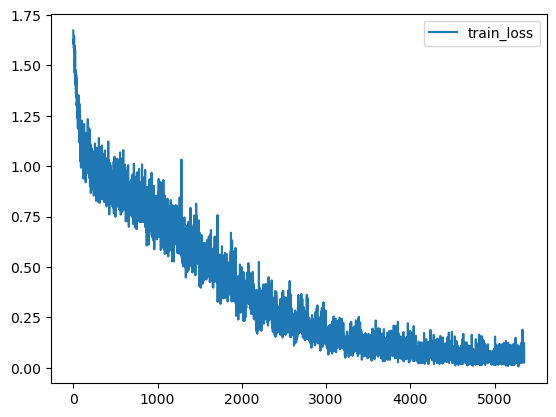

In [26]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.legend()
plt.show

Validation Loss: 2.5702, Validation Accuracy: 0.6547
Test Loss: 2.6213, Test Accuracy: 0.6488


<function matplotlib.pyplot.show(close=None, block=None)>

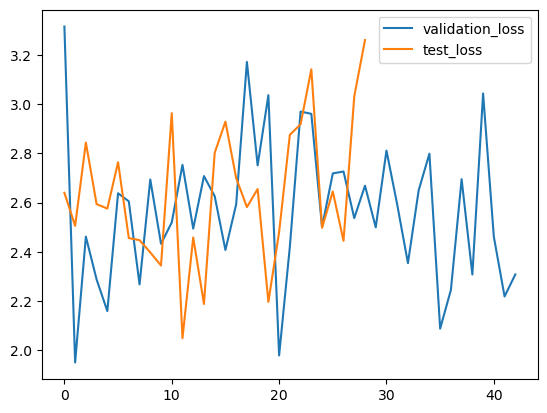

In [27]:
def evaluate(dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epoch_loss = [];
    
    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            inputs, targets = batch  # Adjust depending on your dataset structure
            
            # Move inputs and targets to the appropriate device (CPU/GPU)
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            epoch_loss.append(loss.item());
            total_loss += loss.item() * inputs.size(0)  # Accumulate loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy, epoch_loss

# Assuming 'validation_dataloader' and 'test_dataloader' are already defined
validation_loss, validation_accuracy, val_loss = evaluate(validation_dataloader)
test_loss, test_accuracy, test_val_loss = evaluate(test_dataloader)

print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
plt.plot(val_loss, label='validation_loss')
plt.plot(test_val_loss, label='test_loss')
plt.legend()
plt.show